In [1]:
import pandas as pd
import numpy as np
import random
from numpy.random import RandomState
from scipy import stats
from scipy.optimize import minimize
import scipy
import os
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Versions/4.1/Resources/'
import rpy2
from rpy2.robjects.packages import importr
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage
import datetime
from rpy2.robjects.vectors import FloatVector
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression

real_data_folder = "/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Data/sp500_mixed_period/"
np.random.seed(22001)

yuima = importr("yuima")
n_stvol_sim_string = """
n_stvol = function(random_seed, num_sim,
                    mu11, mu21, mu22, mu31, mu41, mu42, 
                    sigma11, sigma12, sigma13, sigma14,
                    sigma21, sigma22, sigma23, sigma24,
                    sigma31, sigma32, sigma33, sigma34,
                    sigma41, sigma42, sigma43, sigma44,
                    xinit_vec, vinit_vec, T0, T, length){
  
  set.seed(random_seed)
  
  drift = c("mu11-(1/2)*(v1)^2", "mu21-mu22*v1", "mu31-(1/2)*(v2)^2", "mu41-mu42*v2")
  diffusion = matrix(c("sigma11*v1", "sigma12*v1", "sigma13*v1", "sigma14*v1", 
                       "sigma21", "sigma22", "sigma23", "sigma24", 
                       "sigma31*v2", "sigma32*v2", "sigma33*v2", "sigma34*v2", 
                       "sigma41", "sigma42", "sigma43", "sigma44"), 
                     4, 4, byrow=TRUE)
  
  stvol_model = setModel(drift=drift, diffusion=diffusion,
                          time.variable = "t",
                          state.variable=c("X1", "v1", "X2", "v2"),
                          solve.variable=c("X1", "v1", "X2", "v2"))
  newsamp = setSampling(Initial=T0, Terminal=T, n=length)
  
  n_sim_data = data.frame(matrix(nrow=length+1, ncol=2*num_sim))
  for (i in 1:num_sim){
    stvol_sim = simulate(stvol_model, 
                          true.par=list(
                            mu11=mu11, mu21=mu21, mu22=mu22, mu31=mu31, mu41=mu41, mu42=mu42,  
                            sigma11=sigma11, sigma12=sigma12, sigma13=sigma13, sigma14=sigma14,
                            sigma21=sigma21, sigma22=sigma22, sigma23=sigma23, sigma24=sigma24,
                            sigma31=sigma31, sigma32=sigma32, sigma33=sigma33, sigma34=sigma34,
                            sigma41=sigma41, sigma42=sigma42, sigma43=sigma43, sigma44=sigma44), 
                          xinit=c(xinit_vec[[i]][1], vinit_vec[[i]][1], xinit_vec[[i]][2], vinit_vec[[i]][2]), 
                          sampling=newsamp)
    original_data = stvol_sim@data@original.data
    one_sim_stvol = data.frame(original_data[,1], original_data[,3])
    colnames(one_sim_stvol) = c('series1', 'series2')
    n_sim_data[, (2*i-1):(2*i)] = one_sim_stvol
  }
  return(n_sim_data)
}
"""

n_stvol_sim = SignatureTranslatedAnonymousPackage(n_stvol_sim_string, "n_stvol_sim")
def n_stvol_simulation(random_seed, num_sim,
                        mu11, mu21, mu22, mu31, mu41, mu42, 
                        sigma11, sigma12, sigma13, sigma14,
                        sigma21, sigma22, sigma23, sigma24,
                        sigma31, sigma32, sigma33, sigma34,
                        sigma41, sigma42, sigma43, sigma44,
                        xinit_vec, vinit_vec, T0, T, length):

    n_sim_data = pd.DataFrame(
        n_stvol_sim.n_stvol(random_seed=random_seed, num_sim=num_sim,
                              mu11=mu11, mu21=mu21, mu22=mu22, mu31=mu31, mu41=mu41, mu42=mu42,  
                              sigma11=sigma11, sigma12=sigma12, sigma13=sigma13, sigma14=sigma14,
                              sigma21=sigma21, sigma22=sigma22, sigma23=sigma23, sigma24=sigma24,
                              sigma31=sigma31, sigma32=sigma32, sigma33=sigma33, sigma34=sigma34,
                              sigma41=sigma41, sigma42=sigma42, sigma43=sigma43, sigma44=sigma44,
                              xinit_vec=xinit_vec, vinit_vec=vinit_vec, T0=T0, T=T, length=length)).transpose()
    return n_sim_data


def price_to_log_price(n_price):
    return(np.log(n_price))

def log_price_to_price(n_log_price):
    return(np.exp(n_log_price))

def price_to_return(n_price):
    n_return = pd.DataFrame()
    for i in range(n_price.shape[1]):
        ith_column_price_series = n_price.iloc[:, i]
        n_return = pd.concat([n_return, 100 * (np.log(ith_column_price_series[1:].values) - np.log(ith_column_price_series[:-1]))], axis=1)
    return n_return

def log_price_to_return(n_log_price):
    n_real_return = pd.DataFrame()
    for i in range(n_log_price.shape[1]):
        ith_column_price_series = n_log_price.iloc[:, i]
        n_real_return = pd.concat([n_real_return, 100 * (ith_column_price_series[1:].values - ith_column_price_series[:-1])], axis=1)
    return n_real_return

def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'
    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]
    return corr_coef
    
    



def cal_stats(n_return, n_price):
    
    return_series1 = n_return.iloc[:, ::2]
    return_series2 = n_return.iloc[:, 1::2]
    price_series1 = n_price.iloc[:, ::2]
    price_series2 = n_price.iloc[:, 1::2]
    sq_return_series1 = return_series1**2
    sq_return_series2 = return_series2**2

    
    mean1 = return_series1.mean(axis=0).values
    sd1 = return_series1.std(axis=0).values
    skew1 = return_series2.skew(axis=0).values
    kurtosis1 = return_series1.kurtosis(axis=0).values
       
    
    mean2 = return_series2.mean(axis=0).values
    sd2 = return_series2.std(axis=0).values
    skew2 = return_series1.skew(axis=0).values
    kurtosis2 = return_series2.kurtosis(axis=0).values #8(8)
    
    
    
    # Autocorrelation of the 2 return series with 3 lags respectively
    autocorr1_lag_1 = return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr1_lag_2 = return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr1_lag_3 = return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr2_lag_1 = return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr2_lag_2 = return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr2_lag_3 = return_series2.apply(lambda x: x.autocorr(lag=3)) #6(14)
    
    # Cross-correlation between return series
    corr_ts1_lag_0 = []
    corr_ts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_ts1_lag_2 = []
    corr_ts1_lag_3 = []
    corr_ts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_ts2_lag_2 = []
    corr_ts2_lag_3 = []
    for i in range(int(real_price.shape[1]/2)):
        corr_ts1_lag_0.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 0))
        corr_ts1_lag_1.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 1))
        corr_ts1_lag_2.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 2))
        corr_ts1_lag_3.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 3))
        corr_ts2_lag_1.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 1))
        corr_ts2_lag_2.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 2))
        corr_ts2_lag_3.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 3))
    corr_ts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_ts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_ts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_ts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_ts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_ts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_ts2_lag_3 = pd.Series(corr_ts2_lag_3)#7(21)
    
    
    
    # Autocorrelation of the 2 squared returns with 3 lags respectively
    autocorr_sqreturn_1_lag_1 = sq_return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr_sqreturn_1_lag_2 = sq_return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr_sqreturn_1_lag_3 = sq_return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr_sqreturn_2_lag_1 = sq_return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr_sqreturn_2_lag_2 = sq_return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr_sqreturn_2_lag_3 = sq_return_series2.apply(lambda x: x.autocorr(lag=3))#6(27)
    
    # Cross-correlation between squared returns series
    corr_sqts1_lag_0 = []
    corr_sqts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_sqts1_lag_2 = []
    corr_sqts1_lag_3 = []
    corr_sqts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_sqts2_lag_2 = []
    corr_sqts2_lag_3 = []
    for i in range(int(real_price.shape[1]/2)):
        corr_sqts1_lag_0.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 0))
        corr_sqts1_lag_1.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 1))
        corr_sqts1_lag_2.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 2))
        corr_sqts1_lag_3.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 3))
        corr_sqts2_lag_1.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 1))
        corr_sqts2_lag_2.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 2))
        corr_sqts2_lag_3.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 3))
    corr_sqts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_sqts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_sqts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_sqts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_sqts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_sqts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_sqts2_lag_3 = pd.Series(corr_ts2_lag_3)#7(34)
    
    
    
    
    stats_data = pd.DataFrame([mean1, mean2, sd1, sd2, 
                               skew1, skew2, kurtosis1, kurtosis2, #8(8)
                               
                               autocorr1_lag_1, autocorr1_lag_2, autocorr1_lag_3,
                               autocorr2_lag_1, autocorr2_lag_2, autocorr2_lag_3,#6(14)
                               
                               corr_ts1_lag_0, 
                               corr_ts1_lag_1, corr_ts1_lag_2, corr_ts1_lag_3,
                               corr_ts2_lag_1, corr_ts2_lag_2, corr_ts2_lag_3, #7(21)
                               
                               autocorr_sqreturn_1_lag_1, autocorr_sqreturn_1_lag_2, autocorr_sqreturn_1_lag_3,
                               autocorr_sqreturn_2_lag_1, autocorr_sqreturn_2_lag_2, autocorr_sqreturn_2_lag_3,#6(27)
                               
                               corr_sqts1_lag_0,
                               corr_sqts1_lag_1, corr_sqts1_lag_2, corr_sqts1_lag_3,
                               corr_sqts2_lag_1, corr_sqts2_lag_2, corr_sqts2_lag_3])#7(34)
    stats_data = stats_data.transpose()
    stats_data.columns = [
        'return_mean1', 'return_mean2',
        'return_sd1', 'return_sd2',
        'return_skew1', 'return_skew2',
        'return_kurtosis1', 'return_kurtosis2',
        
        'return_autocorrelation_ts1_lag1', 'return_autocorrelation_ts1_lag2', 'return_autocorrelation_ts1_lag3',
        'return_autocorrelation_ts2_lag1', 'return_autocorrelation_ts2_lag2', 'return_autocorrelation_ts2_lag3',
        
        'return_correlation_ts1_lag_0',
        'return_correlation_ts1_lag_1', 'return_correlation_ts1_lag_2', 'return_correlation_ts1_lag_3',
        'return_correlation_ts2_lag_1', 'return_correlation_ts2_lag_2', 'return_correlation_ts2_lag_3',
        
        'sqreturn_autocorrelation_ts1_lag1', 'sqreturn_autocorrelation_ts1_lag2', 'sqreturn_autocorrelation_ts1_lag3',
        'sqreturn_autocorrelation_ts2_lag1', 'sqreturn_autocorrelation_ts2_lag2', 'sqreturn_autocorrelation_ts2_lag3',
    
        'sqreturn_correlation_ts1_lag_0',
        'sqreturn_correlation_ts1_lag_1', 'sqreturn_correlation_ts1_lag_2', 'sqreturn_correlation_ts1_lag_3', 
        'sqreturn_correlation_ts2_lag_1', 'sqreturn_correlation_ts2_lag_2', 'sqreturn_correlation_ts2_lag_3']
    
    return stats_data







def loss_function(params):
    
    params = FloatVector(params)
    print(params)
    moment_loss = pd.DataFrame().reindex_like(real_stats)
    
    n_sim_log_price = n_stvol_simulation(
        random_seed=int(np.random.randint(low=0, high=980608, size=(1,))), num_sim=num_sim,
        mu11=params[0], 
        mu21=params[1], mu22=params[2], 
        mu31=params[3], 
        mu41=params[4], mu42=params[5],  
        sigma11=params[6],  sigma12=params[7],  sigma13=params[8],  sigma14=params[9],
        sigma21=params[10], sigma22=params[11], sigma23=params[12], sigma24=params[13],
        sigma31=params[14], sigma32=params[15], sigma33=params[16], sigma34=params[17],
        sigma41=params[18], sigma42=params[19], sigma43=params[20], sigma44=params[21],
        xinit_vec=xinit_vec, vinit_vec=vinit_vec, T0=T0, T=T, length=length)
    
    n_sim_price = log_price_to_price(n_log_price=n_sim_log_price)
    n_sim_return = price_to_return(n_sim_price)
    n_sim_stats = cal_stats(n_return=n_sim_return, n_price=n_sim_price)


    moment_loss = np.abs(n_real_stats - n_sim_stats)
    sum_loss = np.sum(moment_loss)

    sum_loss[6] = sum_loss[6]/10 
    sum_loss[7] = sum_loss[7]/10 
    
    loss = np.sum(sum_loss)

    print(sum_loss)
    print(loss)
    print('----------')

    return loss


real_price = pd.read_csv(real_data_folder + "pair_price_mixed_period_calibration.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv(real_data_folder + "pair_return_mixed_period_calibration.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)


xinit_vec = []
vinit_vec = []
for i in range(int(real_price.shape[1]/2)):

    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)
    
    init_pair_volatility = [np.std(real_return.iloc[:, 2*i]/100), np.std(real_return.iloc[:, 2*i+1]/100)]
    init_pair_volatility = FloatVector(init_pair_volatility)
    vinit_vec.append(init_pair_volatility)


num_sim, T0, T, length = real_stats.shape[0], 0, 1, real_price.shape[0]

n_real_stats = real_stats




initial0 = [0.1, 
            1, 1, 
            0.1, 
            1, 1,
            0.1, 0.1, 0.1, 0.1,
            0.1, 0.1, 0.1, 0.1,
            0.1, 0.1, 0.1, 0.1,
            0.1, 0.1, 0.1, 0.1]

begin_time = datetime.datetime.now()
res = minimize(loss_function, initial0, method='Powell',
               tol=1e-6, options={'disp': True},
               bounds=[(0, None), 
                       (None, None), (None, None), 
                       (0, None), 
                       (None, None), (None, None),
                       (0, None), (0, None), (0, None), (0, None),
                       (0, None), (0, None), (0, None), (0, None),
                       (0, None), (0, None), (0, None), (0, None),
                       (0, None), (0, None), (0, None), (0, None)])
print(res.x)

time = datetime.datetime.now() - begin_time
print(time)

params = (res.x)
loss = loss_function((params))
print(loss)

 [1] 0.1 1.0 1.0 0.1 1.0 1.0 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
[20] 0.1 0.1 0.1

return_mean1                          24.579290
return_mean2                          22.950342
return_sd1                           272.068326
return_sd2                           289.730545
return_skew1                         213.187605
return_skew2                         168.026917
return_kurtosis1                     100.566009
return_kurtosis2                     151.653502
return_autocorrelation_ts1_lag1       20.518839
return_autocorrelation_ts1_lag2       21.028420
return_autocorrelation_ts1_lag3       19.649696
return_autocorrelation_ts2_lag1       20.236835
return_autocorrelation_ts2_lag2       20.745451
return_autocorrelation_ts2_lag3       20.420796
return_correlation_ts1_lag_0         168.107709
return_correlation_ts1_lag_1          18.604514
return_correlation_ts1_lag_2          19.960430
return_correlation_ts1_lag_3          21.196094
return_correlation_ts2_lag_1         

return_mean1                          31.889554
return_mean2                          22.902441
return_sd1                           274.763038
return_sd2                           292.433625
return_skew1                         212.147425
return_skew2                         163.474136
return_kurtosis1                     102.280999
return_kurtosis2                     152.089430
return_autocorrelation_ts1_lag1       21.548599
return_autocorrelation_ts1_lag2       19.716971
return_autocorrelation_ts1_lag3       21.098077
return_autocorrelation_ts2_lag1       20.971891
return_autocorrelation_ts2_lag2       20.259359
return_autocorrelation_ts2_lag3       20.343165
return_correlation_ts1_lag_0         168.107222
return_correlation_ts1_lag_1          21.384971
return_correlation_ts1_lag_2          19.624643
return_correlation_ts1_lag_3          21.327133
return_correlation_ts2_lag_1          21.378096
return_correlation_ts2_lag_2          19.739632
return_correlation_ts2_lag_3          19

return_mean1                          28.603106
return_mean2                          23.064038
return_sd1                           272.336380
return_sd2                           289.997183
return_skew1                         211.670823
return_skew2                         160.245936
return_kurtosis1                     101.380920
return_kurtosis2                     149.714811
return_autocorrelation_ts1_lag1       20.853257
return_autocorrelation_ts1_lag2       21.484513
return_autocorrelation_ts1_lag3       20.521817
return_autocorrelation_ts2_lag1       18.975478
return_autocorrelation_ts2_lag2       20.867228
return_autocorrelation_ts2_lag3       19.209611
return_correlation_ts1_lag_0         168.108281
return_correlation_ts1_lag_1          20.426537
return_correlation_ts1_lag_2          20.207293
return_correlation_ts1_lag_3          20.165283
return_correlation_ts2_lag_1          20.068583
return_correlation_ts2_lag_2          19.666707
return_correlation_ts2_lag_3          20

return_mean1                          28.040555
return_mean2                          23.321131
return_sd1                           273.659153
return_sd2                           291.320898
return_skew1                         208.966480
return_skew2                         156.655192
return_kurtosis1                      98.036724
return_kurtosis2                     148.686745
return_autocorrelation_ts1_lag1       22.245256
return_autocorrelation_ts1_lag2       20.729395
return_autocorrelation_ts1_lag3       21.553108
return_autocorrelation_ts2_lag1       21.408482
return_autocorrelation_ts2_lag2       20.079643
return_autocorrelation_ts2_lag3       21.293863
return_correlation_ts1_lag_0         168.107811
return_correlation_ts1_lag_1          21.951335
return_correlation_ts1_lag_2          19.869965
return_correlation_ts1_lag_3          22.228914
return_correlation_ts2_lag_1          21.357166
return_correlation_ts2_lag_2          20.280247
return_correlation_ts2_lag_3          20

return_mean1                          28.768368
return_mean2                          23.482094
return_sd1                           273.023296
return_sd2                           290.690148
return_skew1                         218.059919
return_skew2                         165.730110
return_kurtosis1                     100.333472
return_kurtosis2                     148.639780
return_autocorrelation_ts1_lag1       21.508430
return_autocorrelation_ts1_lag2       20.945282
return_autocorrelation_ts1_lag3       22.092088
return_autocorrelation_ts2_lag1       21.288777
return_autocorrelation_ts2_lag2       19.937382
return_autocorrelation_ts2_lag3       21.365915
return_correlation_ts1_lag_0         168.107842
return_correlation_ts1_lag_1          21.385171
return_correlation_ts1_lag_2          20.283780
return_correlation_ts1_lag_3          21.799881
return_correlation_ts2_lag_1          22.654963
return_correlation_ts2_lag_2          20.045172
return_correlation_ts2_lag_3          21

return_mean1                          28.898693
return_mean2                          23.105031
return_sd1                           270.182512
return_sd2                           287.850034
return_skew1                         215.645251
return_skew2                         159.587848
return_kurtosis1                      99.546883
return_kurtosis2                     151.232948
return_autocorrelation_ts1_lag1       19.980457
return_autocorrelation_ts1_lag2       20.105135
return_autocorrelation_ts1_lag3       20.773848
return_autocorrelation_ts2_lag1       19.683047
return_autocorrelation_ts2_lag2       20.923718
return_autocorrelation_ts2_lag3       19.259173
return_correlation_ts1_lag_0         168.108041
return_correlation_ts1_lag_1          20.275996
return_correlation_ts1_lag_2          19.958404
return_correlation_ts1_lag_3          21.596299
return_correlation_ts2_lag_1          21.637743
return_correlation_ts2_lag_2          18.585018
return_correlation_ts2_lag_3          18

return_mean1                          28.879667
return_mean2                          23.481939
return_sd1                           275.023882
return_sd2                           292.690623
return_skew1                         216.248646
return_skew2                         168.228477
return_kurtosis1                     100.921327
return_kurtosis2                     148.892766
return_autocorrelation_ts1_lag1       19.248440
return_autocorrelation_ts1_lag2       20.306868
return_autocorrelation_ts1_lag3       19.646932
return_autocorrelation_ts2_lag1       20.361527
return_autocorrelation_ts2_lag2       21.332805
return_autocorrelation_ts2_lag3       20.043347
return_correlation_ts1_lag_0         168.107506
return_correlation_ts1_lag_1          19.936443
return_correlation_ts1_lag_2          20.222106
return_correlation_ts1_lag_3          20.634674
return_correlation_ts2_lag_1          21.435411
return_correlation_ts2_lag_2          20.560449
return_correlation_ts2_lag_3          19

return_mean1                          46.763388
return_mean2                          23.160559
return_sd1                            90.721942
return_sd2                           291.178815
return_skew1                         220.194974
return_skew2                         162.742938
return_kurtosis1                     100.657449
return_kurtosis2                     150.785926
return_autocorrelation_ts1_lag1       20.540075
return_autocorrelation_ts1_lag2       21.036439
return_autocorrelation_ts1_lag3       20.255107
return_autocorrelation_ts2_lag1       21.323987
return_autocorrelation_ts2_lag2       20.212919
return_autocorrelation_ts2_lag3       19.686158
return_correlation_ts1_lag_0         165.613980
return_correlation_ts1_lag_1          19.611456
return_correlation_ts1_lag_2          20.184182
return_correlation_ts1_lag_3          21.038155
return_correlation_ts2_lag_1          18.519469
return_correlation_ts2_lag_2          20.361666
return_correlation_ts2_lag_3          20

return_mean1                          27.895764
return_mean2                          22.987072
return_sd1                           111.586965
return_sd2                           291.234811
return_skew1                         215.436977
return_skew2                         156.898363
return_kurtosis1                      98.572696
return_kurtosis2                     150.102627
return_autocorrelation_ts1_lag1       21.294330
return_autocorrelation_ts1_lag2       21.977660
return_autocorrelation_ts1_lag3       17.924189
return_autocorrelation_ts2_lag1       21.661303
return_autocorrelation_ts2_lag2       20.759361
return_autocorrelation_ts2_lag3       20.095006
return_correlation_ts1_lag_0         166.361843
return_correlation_ts1_lag_1          21.568903
return_correlation_ts1_lag_2          21.239732
return_correlation_ts1_lag_3          20.272212
return_correlation_ts2_lag_1          22.285336
return_correlation_ts2_lag_2          21.093630
return_correlation_ts2_lag_3          19

return_mean1                          29.156542
return_mean2                          22.659512
return_sd1                           106.341126
return_sd2                           290.842599
return_skew1                         213.320109
return_skew2                         157.914315
return_kurtosis1                     101.126935
return_kurtosis2                     150.847878
return_autocorrelation_ts1_lag1       22.072330
return_autocorrelation_ts1_lag2       21.859208
return_autocorrelation_ts1_lag3       18.422373
return_autocorrelation_ts2_lag1       21.654722
return_autocorrelation_ts2_lag2       20.366804
return_autocorrelation_ts2_lag3       19.387641
return_correlation_ts1_lag_0         166.327195
return_correlation_ts1_lag_1          20.408302
return_correlation_ts1_lag_2          20.515850
return_correlation_ts1_lag_3          20.034899
return_correlation_ts2_lag_1          20.829087
return_correlation_ts2_lag_2          21.506359
return_correlation_ts2_lag_3          17

return_mean1                          28.520049
return_mean2                          23.540064
return_sd1                           109.129869
return_sd2                           288.855409
return_skew1                         210.115438
return_skew2                         156.609668
return_kurtosis1                     100.627470
return_kurtosis2                     148.680750
return_autocorrelation_ts1_lag1       21.011414
return_autocorrelation_ts1_lag2       21.094649
return_autocorrelation_ts1_lag3       20.443669
return_autocorrelation_ts2_lag1       19.735854
return_autocorrelation_ts2_lag2       20.269448
return_autocorrelation_ts2_lag3       22.131835
return_correlation_ts1_lag_0         166.456795
return_correlation_ts1_lag_1          19.941892
return_correlation_ts1_lag_2          19.674518
return_correlation_ts1_lag_3          22.900686
return_correlation_ts2_lag_1          20.198429
return_correlation_ts2_lag_2          21.171589
return_correlation_ts2_lag_3          19

return_mean1                          29.935848
return_mean2                          23.060261
return_sd1                           108.163120
return_sd2                           291.838261
return_skew1                         213.909185
return_skew2                         160.639891
return_kurtosis1                      97.245238
return_kurtosis2                     151.462719
return_autocorrelation_ts1_lag1       18.589392
return_autocorrelation_ts1_lag2       21.455593
return_autocorrelation_ts1_lag3       20.881017
return_autocorrelation_ts2_lag1       18.966415
return_autocorrelation_ts2_lag2       20.086335
return_autocorrelation_ts2_lag3       20.455053
return_correlation_ts1_lag_0         166.349123
return_correlation_ts1_lag_1          17.911642
return_correlation_ts1_lag_2          19.796134
return_correlation_ts1_lag_3          21.945067
return_correlation_ts2_lag_1          20.254579
return_correlation_ts2_lag_2          20.303322
return_correlation_ts2_lag_3          21

return_mean1                          30.578887
return_mean2                          23.690339
return_sd1                           111.294490
return_sd2                           291.090349
return_skew1                         218.026874
return_skew2                         159.011875
return_kurtosis1                      98.696673
return_kurtosis2                     151.271908
return_autocorrelation_ts1_lag1       22.388862
return_autocorrelation_ts1_lag2       20.638329
return_autocorrelation_ts1_lag3       20.109662
return_autocorrelation_ts2_lag1       21.215049
return_autocorrelation_ts2_lag2       19.907437
return_autocorrelation_ts2_lag3       21.225686
return_correlation_ts1_lag_0         166.366021
return_correlation_ts1_lag_1          21.459667
return_correlation_ts1_lag_2          19.182452
return_correlation_ts1_lag_3          21.167386
return_correlation_ts2_lag_1          21.747356
return_correlation_ts2_lag_2          19.810876
return_correlation_ts2_lag_3          19

return_mean1                          29.815912
return_mean2                          24.049922
return_sd1                           105.802714
return_sd2                           293.618382
return_skew1                         217.099890
return_skew2                         157.999649
return_kurtosis1                      96.314100
return_kurtosis2                     149.200584
return_autocorrelation_ts1_lag1       19.803709
return_autocorrelation_ts1_lag2       23.043407
return_autocorrelation_ts1_lag3       21.469556
return_autocorrelation_ts2_lag1       21.102506
return_autocorrelation_ts2_lag2       20.309031
return_autocorrelation_ts2_lag3       20.687655
return_correlation_ts1_lag_0         166.231701
return_correlation_ts1_lag_1          19.572002
return_correlation_ts1_lag_2          21.446288
return_correlation_ts1_lag_3          22.078802
return_correlation_ts2_lag_1          21.087967
return_correlation_ts2_lag_2          20.441894
return_correlation_ts2_lag_3          20

return_mean1                          30.017855
return_mean2                          23.250799
return_sd1                           106.146330
return_sd2                           290.466207
return_skew1                         215.167748
return_skew2                         156.141233
return_kurtosis1                      98.038123
return_kurtosis2                     149.984836
return_autocorrelation_ts1_lag1       20.690659
return_autocorrelation_ts1_lag2       21.523412
return_autocorrelation_ts1_lag3       20.703263
return_autocorrelation_ts2_lag1       21.144886
return_autocorrelation_ts2_lag2       20.134436
return_autocorrelation_ts2_lag3       19.729966
return_correlation_ts1_lag_0         166.285165
return_correlation_ts1_lag_1          21.238298
return_correlation_ts1_lag_2          19.024040
return_correlation_ts1_lag_3          20.590649
return_correlation_ts2_lag_1          19.678786
return_correlation_ts2_lag_2          17.936863
return_correlation_ts2_lag_3          20

return_mean1                          30.410206
return_mean2                          23.274819
return_sd1                           106.345067
return_sd2                           292.197674
return_skew1                         215.742781
return_skew2                         166.331870
return_kurtosis1                      99.079172
return_kurtosis2                     149.309834
return_autocorrelation_ts1_lag1       20.894198
return_autocorrelation_ts1_lag2       21.039493
return_autocorrelation_ts1_lag3       18.412521
return_autocorrelation_ts2_lag1       20.604606
return_autocorrelation_ts2_lag2       19.623460
return_autocorrelation_ts2_lag3       19.765948
return_correlation_ts1_lag_0         166.393759
return_correlation_ts1_lag_1          20.268184
return_correlation_ts1_lag_2          18.800604
return_correlation_ts1_lag_3          19.127157
return_correlation_ts2_lag_1          21.279653
return_correlation_ts2_lag_2          19.752228
return_correlation_ts2_lag_3          18

return_mean1                          31.451142
return_mean2                          52.831947
return_sd1                           107.564571
return_sd2                           291.384342
return_skew1                         215.634131
return_skew2                         158.226867
return_kurtosis1                      99.646333
return_kurtosis2                     151.494200
return_autocorrelation_ts1_lag1       21.149832
return_autocorrelation_ts1_lag2       20.408416
return_autocorrelation_ts1_lag3       19.247047
return_autocorrelation_ts2_lag1       19.581025
return_autocorrelation_ts2_lag2       19.092378
return_autocorrelation_ts2_lag3       19.245320
return_correlation_ts1_lag_0         166.258330
return_correlation_ts1_lag_1          20.595769
return_correlation_ts1_lag_2          18.773364
return_correlation_ts1_lag_3          20.114249
return_correlation_ts2_lag_1          20.354401
return_correlation_ts2_lag_2          19.590811
return_correlation_ts2_lag_3          18

return_mean1                          30.941788
return_mean2                          47.869658
return_sd1                           106.459124
return_sd2                           291.486028
return_skew1                         213.721351
return_skew2                         164.175405
return_kurtosis1                      98.539270
return_kurtosis2                     150.209073
return_autocorrelation_ts1_lag1       21.530004
return_autocorrelation_ts1_lag2       19.689175
return_autocorrelation_ts1_lag3       20.641934
return_autocorrelation_ts2_lag1       20.378133
return_autocorrelation_ts2_lag2       19.704524
return_autocorrelation_ts2_lag3       19.695366
return_correlation_ts1_lag_0         166.418383
return_correlation_ts1_lag_1          20.584814
return_correlation_ts1_lag_2          19.678887
return_correlation_ts1_lag_3          20.926068
return_correlation_ts2_lag_1          21.255288
return_correlation_ts2_lag_2          18.599172
return_correlation_ts2_lag_3          20

return_mean1                          31.022913
return_mean2                          45.451371
return_sd1                           107.690006
return_sd2                           293.360618
return_skew1                         221.024916
return_skew2                         159.418794
return_kurtosis1                     102.642770
return_kurtosis2                     152.208820
return_autocorrelation_ts1_lag1       19.810698
return_autocorrelation_ts1_lag2       22.254748
return_autocorrelation_ts1_lag3       20.084889
return_autocorrelation_ts2_lag1       18.688250
return_autocorrelation_ts2_lag2       19.965035
return_autocorrelation_ts2_lag3       19.293473
return_correlation_ts1_lag_0         166.259946
return_correlation_ts1_lag_1          19.166128
return_correlation_ts1_lag_2          18.781358
return_correlation_ts1_lag_3          20.463306
return_correlation_ts2_lag_1          19.510899
return_correlation_ts2_lag_2          21.187505
return_correlation_ts2_lag_3          19

return_mean1                          31.831371
return_mean2                          45.272944
return_sd1                           102.023962
return_sd2                           290.004528
return_skew1                         209.326925
return_skew2                         157.525639
return_kurtosis1                      98.141739
return_kurtosis2                     150.373832
return_autocorrelation_ts1_lag1       20.765534
return_autocorrelation_ts1_lag2       20.736639
return_autocorrelation_ts1_lag3       19.792751
return_autocorrelation_ts2_lag1       19.645178
return_autocorrelation_ts2_lag2       22.187085
return_autocorrelation_ts2_lag3       20.412137
return_correlation_ts1_lag_0         166.359081
return_correlation_ts1_lag_1          19.156891
return_correlation_ts1_lag_2          20.594591
return_correlation_ts1_lag_3          20.415492
return_correlation_ts2_lag_1          20.001095
return_correlation_ts2_lag_2          21.256555
return_correlation_ts2_lag_3          20

return_mean1                          31.172976
return_mean2                          45.488470
return_sd1                           106.168747
return_sd2                           291.649233
return_skew1                         217.775209
return_skew2                         159.913659
return_kurtosis1                      99.674320
return_kurtosis2                     151.076508
return_autocorrelation_ts1_lag1       22.503741
return_autocorrelation_ts1_lag2       19.708376
return_autocorrelation_ts1_lag3       20.639875
return_autocorrelation_ts2_lag1       21.303169
return_autocorrelation_ts2_lag2       20.757342
return_autocorrelation_ts2_lag3       20.623855
return_correlation_ts1_lag_0         166.218271
return_correlation_ts1_lag_1          20.646842
return_correlation_ts1_lag_2          19.400630
return_correlation_ts1_lag_3          21.587088
return_correlation_ts2_lag_1          21.682968
return_correlation_ts2_lag_2          20.145943
return_correlation_ts2_lag_3          20

return_mean1                          30.230915
return_mean2                          45.864681
return_sd1                           106.252741
return_sd2                           293.019013
return_skew1                         208.645796
return_skew2                         159.675812
return_kurtosis1                      99.023677
return_kurtosis2                     151.606248
return_autocorrelation_ts1_lag1       19.975862
return_autocorrelation_ts1_lag2       22.699812
return_autocorrelation_ts1_lag3       20.947776
return_autocorrelation_ts2_lag1       20.902578
return_autocorrelation_ts2_lag2       19.432565
return_autocorrelation_ts2_lag3       22.290189
return_correlation_ts1_lag_0         166.108440
return_correlation_ts1_lag_1          20.932279
return_correlation_ts1_lag_2          20.842488
return_correlation_ts1_lag_3          21.833415
return_correlation_ts2_lag_1          21.001693
return_correlation_ts2_lag_2          20.332273
return_correlation_ts2_lag_3          21

return_mean1                          32.241244
return_mean2                          59.785263
return_sd1                           105.889994
return_sd2                           119.366371
return_skew1                         209.808595
return_skew2                         158.371059
return_kurtosis1                     100.031071
return_kurtosis2                     150.039409
return_autocorrelation_ts1_lag1       20.865822
return_autocorrelation_ts1_lag2       20.199018
return_autocorrelation_ts1_lag3       21.555403
return_autocorrelation_ts2_lag1       21.831929
return_autocorrelation_ts2_lag2       20.741855
return_autocorrelation_ts2_lag3       20.510765
return_correlation_ts1_lag_0         167.724544
return_correlation_ts1_lag_1          21.288794
return_correlation_ts1_lag_2          18.768979
return_correlation_ts1_lag_3          22.254665
return_correlation_ts2_lag_1          21.255668
return_correlation_ts2_lag_2          20.496822
return_correlation_ts2_lag_3          19

return_mean1                          29.462415
return_mean2                          26.577178
return_sd1                           103.538057
return_sd2                           107.891325
return_skew1                         210.561658
return_skew2                         161.845989
return_kurtosis1                     100.208774
return_kurtosis2                     148.892406
return_autocorrelation_ts1_lag1       21.748972
return_autocorrelation_ts1_lag2       20.742132
return_autocorrelation_ts1_lag3       19.418028
return_autocorrelation_ts2_lag1       22.170011
return_autocorrelation_ts2_lag2       20.913759
return_autocorrelation_ts2_lag3       22.636787
return_correlation_ts1_lag_0         168.093410
return_correlation_ts1_lag_1          21.488031
return_correlation_ts1_lag_2          19.105418
return_correlation_ts1_lag_3          21.825292
return_correlation_ts2_lag_1          22.446249
return_correlation_ts2_lag_2          20.689105
return_correlation_ts2_lag_3          19

return_mean1                          31.608198
return_mean2                          26.717319
return_sd1                           107.191963
return_sd2                           117.150652
return_skew1                         208.322023
return_skew2                         158.004004
return_kurtosis1                      99.657886
return_kurtosis2                     151.592225
return_autocorrelation_ts1_lag1       21.845930
return_autocorrelation_ts1_lag2       22.813386
return_autocorrelation_ts1_lag3       19.748647
return_autocorrelation_ts2_lag1       20.739983
return_autocorrelation_ts2_lag2       21.948653
return_autocorrelation_ts2_lag3       19.746103
return_correlation_ts1_lag_0         168.112925
return_correlation_ts1_lag_1          20.944209
return_correlation_ts1_lag_2          21.822000
return_correlation_ts1_lag_3          19.877188
return_correlation_ts2_lag_1          21.139781
return_correlation_ts2_lag_2          21.991604
return_correlation_ts2_lag_3          21

return_mean1                          29.169853
return_mean2                          23.214141
return_sd1                           104.850450
return_sd2                           117.815698
return_skew1                         207.919105
return_skew2                         159.585100
return_kurtosis1                      98.656364
return_kurtosis2                     149.154650
return_autocorrelation_ts1_lag1       19.536840
return_autocorrelation_ts1_lag2       21.943644
return_autocorrelation_ts1_lag3       21.020593
return_autocorrelation_ts2_lag1       19.250591
return_autocorrelation_ts2_lag2       20.449805
return_autocorrelation_ts2_lag3       23.106028
return_correlation_ts1_lag_0         168.112771
return_correlation_ts1_lag_1          20.544790
return_correlation_ts1_lag_2          20.930598
return_correlation_ts1_lag_3          22.189071
return_correlation_ts2_lag_1          20.208453
return_correlation_ts2_lag_2          21.337729
return_correlation_ts2_lag_3          19

return_mean1                          31.492904
return_mean2                          26.019276
return_sd1                           106.116644
return_sd2                           139.778722
return_skew1                         214.208879
return_skew2                         157.198672
return_kurtosis1                      98.248639
return_kurtosis2                     152.474519
return_autocorrelation_ts1_lag1       19.633137
return_autocorrelation_ts1_lag2       23.586576
return_autocorrelation_ts1_lag3       19.440694
return_autocorrelation_ts2_lag1       20.741010
return_autocorrelation_ts2_lag2       20.882757
return_autocorrelation_ts2_lag3       21.979867
return_correlation_ts1_lag_0         167.941838
return_correlation_ts1_lag_1          19.734843
return_correlation_ts1_lag_2          20.950080
return_correlation_ts1_lag_3          20.835869
return_correlation_ts2_lag_1          21.397965
return_correlation_ts2_lag_2          22.683148
return_correlation_ts2_lag_3          19

return_mean1                          30.854904
return_mean2                          27.908164
return_sd1                           104.388358
return_sd2                           110.371462
return_skew1                         203.683248
return_skew2                         155.234234
return_kurtosis1                      98.225546
return_kurtosis2                     149.540716
return_autocorrelation_ts1_lag1       22.129630
return_autocorrelation_ts1_lag2       22.243217
return_autocorrelation_ts1_lag3       20.572973
return_autocorrelation_ts2_lag1       21.400407
return_autocorrelation_ts2_lag2       22.130177
return_autocorrelation_ts2_lag3       20.458545
return_correlation_ts1_lag_0         168.079307
return_correlation_ts1_lag_1          22.092482
return_correlation_ts1_lag_2          20.290099
return_correlation_ts1_lag_3          21.112097
return_correlation_ts2_lag_1          22.492521
return_correlation_ts2_lag_2          21.550109
return_correlation_ts2_lag_3          19

return_mean1                          30.407684
return_mean2                          27.119433
return_sd1                           105.928051
return_sd2                           114.794126
return_skew1                         206.631515
return_skew2                         156.239088
return_kurtosis1                     100.473072
return_kurtosis2                     151.103857
return_autocorrelation_ts1_lag1       20.675468
return_autocorrelation_ts1_lag2       21.061612
return_autocorrelation_ts1_lag3       20.104018
return_autocorrelation_ts2_lag1       19.716697
return_autocorrelation_ts2_lag2       21.181034
return_autocorrelation_ts2_lag3       21.021881
return_correlation_ts1_lag_0         168.098821
return_correlation_ts1_lag_1          19.789187
return_correlation_ts1_lag_2          20.780772
return_correlation_ts1_lag_3          21.815389
return_correlation_ts2_lag_1          20.116311
return_correlation_ts2_lag_2          20.999185
return_correlation_ts2_lag_3          21

return_mean1                          29.990328
return_mean2                          26.180304
return_sd1                           107.077585
return_sd2                           116.609405
return_skew1                         214.065867
return_skew2                         166.323549
return_kurtosis1                      98.463183
return_kurtosis2                     146.565717
return_autocorrelation_ts1_lag1       20.238998
return_autocorrelation_ts1_lag2       21.547210
return_autocorrelation_ts1_lag3       20.058138
return_autocorrelation_ts2_lag1       20.619373
return_autocorrelation_ts2_lag2       22.983969
return_autocorrelation_ts2_lag3       22.333293
return_correlation_ts1_lag_0         168.101118
return_correlation_ts1_lag_1          20.877536
return_correlation_ts1_lag_2          21.550654
return_correlation_ts1_lag_3          21.208261
return_correlation_ts2_lag_1          19.480111
return_correlation_ts2_lag_2          21.324449
return_correlation_ts2_lag_3          21

return_mean1                          29.428967
return_mean2                          24.947808
return_sd1                           107.408912
return_sd2                           112.681418
return_skew1                         212.188724
return_skew2                         159.308265
return_kurtosis1                      99.615697
return_kurtosis2                     148.799174
return_autocorrelation_ts1_lag1       21.206212
return_autocorrelation_ts1_lag2       20.995937
return_autocorrelation_ts1_lag3       21.952806
return_autocorrelation_ts2_lag1       20.967028
return_autocorrelation_ts2_lag2       21.088368
return_autocorrelation_ts2_lag3       21.851971
return_correlation_ts1_lag_0         168.100680
return_correlation_ts1_lag_1          19.717317
return_correlation_ts1_lag_2          20.284292
return_correlation_ts1_lag_3          22.967849
return_correlation_ts2_lag_1          21.998076
return_correlation_ts2_lag_2          20.644843
return_correlation_ts2_lag_3          20

return_mean1                          56.658011
return_mean2                          27.319481
return_sd1                           758.318924
return_sd2                           114.176231
return_skew1                         208.674318
return_skew2                         171.794707
return_kurtosis1                      98.379149
return_kurtosis2                     150.549842
return_autocorrelation_ts1_lag1       20.711570
return_autocorrelation_ts1_lag2       21.013323
return_autocorrelation_ts1_lag3       20.346512
return_autocorrelation_ts2_lag1       21.153072
return_autocorrelation_ts2_lag2       19.996962
return_autocorrelation_ts2_lag3       21.051225
return_correlation_ts1_lag_0          92.853338
return_correlation_ts1_lag_1          20.499458
return_correlation_ts1_lag_2          20.228795
return_correlation_ts1_lag_3          20.668832
return_correlation_ts2_lag_1          21.025803
return_correlation_ts2_lag_2          19.856304
return_correlation_ts2_lag_3          22

return_mean1                          31.357788
return_mean2                          25.282464
return_sd1                            95.414130
return_sd2                           112.159212
return_skew1                         210.729329
return_skew2                         162.092951
return_kurtosis1                      98.137232
return_kurtosis2                     150.666569
return_autocorrelation_ts1_lag1       20.364058
return_autocorrelation_ts1_lag2       21.063924
return_autocorrelation_ts1_lag3       20.193592
return_autocorrelation_ts2_lag1       21.528744
return_autocorrelation_ts2_lag2       19.999621
return_autocorrelation_ts2_lag3       20.385599
return_correlation_ts1_lag_0         156.560162
return_correlation_ts1_lag_1          20.247676
return_correlation_ts1_lag_2          19.256723
return_correlation_ts1_lag_3          20.950514
return_correlation_ts2_lag_1          21.610553
return_correlation_ts2_lag_2          19.759484
return_correlation_ts2_lag_3          19

return_mean1                          32.870745
return_mean2                          26.283244
return_sd1                            98.312161
return_sd2                           113.638303
return_skew1                         217.218601
return_skew2                         163.164774
return_kurtosis1                      98.444271
return_kurtosis2                     148.808168
return_autocorrelation_ts1_lag1       22.459992
return_autocorrelation_ts1_lag2       19.977031
return_autocorrelation_ts1_lag3       19.616826
return_autocorrelation_ts2_lag1       22.720535
return_autocorrelation_ts2_lag2       21.207922
return_autocorrelation_ts2_lag3       20.264813
return_correlation_ts1_lag_0         155.778883
return_correlation_ts1_lag_1          21.468448
return_correlation_ts1_lag_2          20.321684
return_correlation_ts1_lag_3          20.685007
return_correlation_ts2_lag_1          22.025828
return_correlation_ts2_lag_2          20.798081
return_correlation_ts2_lag_3          19

return_mean1                          32.988977
return_mean2                          26.594835
return_sd1                            98.046552
return_sd2                           113.816207
return_skew1                         212.913574
return_skew2                         167.795463
return_kurtosis1                      98.388841
return_kurtosis2                     148.350547
return_autocorrelation_ts1_lag1       20.831899
return_autocorrelation_ts1_lag2       21.959894
return_autocorrelation_ts1_lag3       19.496115
return_autocorrelation_ts2_lag1       20.781736
return_autocorrelation_ts2_lag2       23.088117
return_autocorrelation_ts2_lag3       19.993056
return_correlation_ts1_lag_0         156.547264
return_correlation_ts1_lag_1          20.436303
return_correlation_ts1_lag_2          21.839072
return_correlation_ts1_lag_3          19.038824
return_correlation_ts2_lag_1          21.187952
return_correlation_ts2_lag_2          21.354510
return_correlation_ts2_lag_3          19

return_mean1                          31.904797
return_mean2                          25.646910
return_sd1                            96.574042
return_sd2                           110.515390
return_skew1                         203.016099
return_skew2                         160.408293
return_kurtosis1                      99.379117
return_kurtosis2                     149.228463
return_autocorrelation_ts1_lag1       19.269487
return_autocorrelation_ts1_lag2       21.120794
return_autocorrelation_ts1_lag3       19.627173
return_autocorrelation_ts2_lag1       20.655552
return_autocorrelation_ts2_lag2       20.344504
return_autocorrelation_ts2_lag3       20.367200
return_correlation_ts1_lag_0         156.432577
return_correlation_ts1_lag_1          19.821997
return_correlation_ts1_lag_2          20.066198
return_correlation_ts1_lag_3          22.093961
return_correlation_ts2_lag_1          21.516465
return_correlation_ts2_lag_2          21.432723
return_correlation_ts2_lag_3          17

return_mean1                          32.083093
return_mean2                          27.114471
return_sd1                            93.604391
return_sd2                           113.191755
return_skew1                         208.117284
return_skew2                         152.710703
return_kurtosis1                      99.585054
return_kurtosis2                     149.888580
return_autocorrelation_ts1_lag1       22.179953
return_autocorrelation_ts1_lag2       20.503263
return_autocorrelation_ts1_lag3       20.710483
return_autocorrelation_ts2_lag1       21.481510
return_autocorrelation_ts2_lag2       20.478773
return_autocorrelation_ts2_lag3       20.224183
return_correlation_ts1_lag_0         156.473336
return_correlation_ts1_lag_1          20.901026
return_correlation_ts1_lag_2          19.522961
return_correlation_ts1_lag_3          21.623530
return_correlation_ts2_lag_1          21.782284
return_correlation_ts2_lag_2          21.409863
return_correlation_ts2_lag_3          20

return_mean1                          30.545041
return_mean2                          25.237791
return_sd1                            88.328457
return_sd2                           113.369224
return_skew1                         214.741088
return_skew2                         163.129754
return_kurtosis1                      98.774820
return_kurtosis2                     150.976966
return_autocorrelation_ts1_lag1       21.085283
return_autocorrelation_ts1_lag2       20.720193
return_autocorrelation_ts1_lag3       20.066529
return_autocorrelation_ts2_lag1       20.449666
return_autocorrelation_ts2_lag2       20.605175
return_autocorrelation_ts2_lag3       20.039946
return_correlation_ts1_lag_0         136.341788
return_correlation_ts1_lag_1          19.882254
return_correlation_ts1_lag_2          19.166723
return_correlation_ts1_lag_3          20.072270
return_correlation_ts2_lag_1          19.330119
return_correlation_ts2_lag_2          19.854720
return_correlation_ts2_lag_3          20

return_mean1                          31.413410
return_mean2                          24.763084
return_sd1                            92.624930
return_sd2                           113.579925
return_skew1                         205.236916
return_skew2                         153.096171
return_kurtosis1                     100.664573
return_kurtosis2                     150.550307
return_autocorrelation_ts1_lag1       22.065973
return_autocorrelation_ts1_lag2       21.189453
return_autocorrelation_ts1_lag3       19.356965
return_autocorrelation_ts2_lag1       20.199041
return_autocorrelation_ts2_lag2       23.784646
return_autocorrelation_ts2_lag3       19.789083
return_correlation_ts1_lag_0         144.637950
return_correlation_ts1_lag_1          20.405504
return_correlation_ts1_lag_2          21.242987
return_correlation_ts1_lag_3          21.072457
return_correlation_ts2_lag_1          22.054638
return_correlation_ts2_lag_2          22.313121
return_correlation_ts2_lag_3          19

return_mean1                          31.742040
return_mean2                          24.487158
return_sd1                            89.989129
return_sd2                           114.827503
return_skew1                         212.468444
return_skew2                         158.722852
return_kurtosis1                      98.100416
return_kurtosis2                     149.204173
return_autocorrelation_ts1_lag1       21.284680
return_autocorrelation_ts1_lag2       21.667647
return_autocorrelation_ts1_lag3       19.613281
return_autocorrelation_ts2_lag1       21.889049
return_autocorrelation_ts2_lag2       19.816971
return_autocorrelation_ts2_lag3       19.590763
return_correlation_ts1_lag_0         143.150229
return_correlation_ts1_lag_1          20.933047
return_correlation_ts1_lag_2          20.569205
return_correlation_ts1_lag_3          20.080511
return_correlation_ts2_lag_1          22.481592
return_correlation_ts2_lag_2          20.677423
return_correlation_ts2_lag_3          20

return_mean1                          32.941174
return_mean2                          27.228358
return_sd1                            94.297878
return_sd2                           116.580176
return_skew1                         208.003658
return_skew2                         167.781733
return_kurtosis1                      98.622680
return_kurtosis2                     150.582153
return_autocorrelation_ts1_lag1       20.869612
return_autocorrelation_ts1_lag2       21.019588
return_autocorrelation_ts1_lag3       19.972140
return_autocorrelation_ts2_lag1       20.821751
return_autocorrelation_ts2_lag2       20.909287
return_autocorrelation_ts2_lag3       20.659491
return_correlation_ts1_lag_0         142.989222
return_correlation_ts1_lag_1          19.770462
return_correlation_ts1_lag_2          21.351020
return_correlation_ts1_lag_3          21.154377
return_correlation_ts2_lag_1          20.276210
return_correlation_ts2_lag_2          19.923029
return_correlation_ts2_lag_3          20

return_mean1                          33.715378
return_mean2                          25.623371
return_sd1                            90.713823
return_sd2                           116.748031
return_skew1                         207.512529
return_skew2                         160.987069
return_kurtosis1                      98.779845
return_kurtosis2                     151.529465
return_autocorrelation_ts1_lag1       19.854214
return_autocorrelation_ts1_lag2       20.694472
return_autocorrelation_ts1_lag3       19.864446
return_autocorrelation_ts2_lag1       21.414117
return_autocorrelation_ts2_lag2       21.317290
return_autocorrelation_ts2_lag3       21.502027
return_correlation_ts1_lag_0         142.773415
return_correlation_ts1_lag_1          20.086639
return_correlation_ts1_lag_2          20.764344
return_correlation_ts1_lag_3          21.095510
return_correlation_ts2_lag_1          21.708864
return_correlation_ts2_lag_2          21.515102
return_correlation_ts2_lag_3          21

return_mean1                          33.005002
return_mean2                          27.528758
return_sd1                            89.760003
return_sd2                           110.173978
return_skew1                         213.795865
return_skew2                         163.038361
return_kurtosis1                     100.421463
return_kurtosis2                     151.031125
return_autocorrelation_ts1_lag1       20.014504
return_autocorrelation_ts1_lag2       20.562772
return_autocorrelation_ts1_lag3       21.234386
return_autocorrelation_ts2_lag1       21.302441
return_autocorrelation_ts2_lag2       20.593438
return_autocorrelation_ts2_lag3       20.085395
return_correlation_ts1_lag_0         143.369809
return_correlation_ts1_lag_1          20.524630
return_correlation_ts1_lag_2          21.114057
return_correlation_ts1_lag_3          22.787131
return_correlation_ts2_lag_1          20.600547
return_correlation_ts2_lag_2          20.536540
return_correlation_ts2_lag_3          19

return_mean1                          35.670594
return_mean2                          25.895369
return_sd1                           123.761988
return_sd2                           113.319171
return_skew1                         204.909953
return_skew2                         161.300919
return_kurtosis1                      99.788114
return_kurtosis2                     148.502488
return_autocorrelation_ts1_lag1       20.806505
return_autocorrelation_ts1_lag2       20.274975
return_autocorrelation_ts1_lag3       20.509181
return_autocorrelation_ts2_lag1       21.856420
return_autocorrelation_ts2_lag2       20.403322
return_autocorrelation_ts2_lag3       20.572646
return_correlation_ts1_lag_0         142.650717
return_correlation_ts1_lag_1          21.625790
return_correlation_ts1_lag_2          20.725401
return_correlation_ts1_lag_3          22.251720
return_correlation_ts2_lag_1          20.491128
return_correlation_ts2_lag_2          20.177733
return_correlation_ts2_lag_3          20

return_mean1                          31.619963
return_mean2                          25.793327
return_sd1                            90.812875
return_sd2                           113.694540
return_skew1                         215.324691
return_skew2                         165.083122
return_kurtosis1                     100.737526
return_kurtosis2                     150.144976
return_autocorrelation_ts1_lag1       20.974819
return_autocorrelation_ts1_lag2       21.501301
return_autocorrelation_ts1_lag3       21.082185
return_autocorrelation_ts2_lag1       21.583783
return_autocorrelation_ts2_lag2       20.212378
return_autocorrelation_ts2_lag3       20.399214
return_correlation_ts1_lag_0         139.944139
return_correlation_ts1_lag_1          20.030545
return_correlation_ts1_lag_2          19.888937
return_correlation_ts1_lag_3          20.381867
return_correlation_ts2_lag_1          22.641312
return_correlation_ts2_lag_2          20.537587
return_correlation_ts2_lag_3          20

return_mean1                          33.547317
return_mean2                          28.394669
return_sd1                            95.928007
return_sd2                           114.534501
return_skew1                         210.931056
return_skew2                         161.195917
return_kurtosis1                      98.086146
return_kurtosis2                     148.270779
return_autocorrelation_ts1_lag1       22.141700
return_autocorrelation_ts1_lag2       19.996917
return_autocorrelation_ts1_lag3       20.184176
return_autocorrelation_ts2_lag1       20.175714
return_autocorrelation_ts2_lag2       20.325976
return_autocorrelation_ts2_lag3       20.145134
return_correlation_ts1_lag_0         140.938216
return_correlation_ts1_lag_1          21.113470
return_correlation_ts1_lag_2          18.429506
return_correlation_ts1_lag_3          19.889028
return_correlation_ts2_lag_1          21.717098
return_correlation_ts2_lag_2          19.810792
return_correlation_ts2_lag_3          19

return_mean1                          30.999418
return_mean2                          25.337414
return_sd1                            94.101554
return_sd2                           113.457487
return_skew1                         208.119095
return_skew2                         158.294203
return_kurtosis1                      97.363382
return_kurtosis2                     148.222414
return_autocorrelation_ts1_lag1       21.299921
return_autocorrelation_ts1_lag2       20.436329
return_autocorrelation_ts1_lag3       20.603082
return_autocorrelation_ts2_lag1       21.885577
return_autocorrelation_ts2_lag2       20.777971
return_autocorrelation_ts2_lag3       21.943571
return_correlation_ts1_lag_0         141.469231
return_correlation_ts1_lag_1          21.581877
return_correlation_ts1_lag_2          19.793085
return_correlation_ts1_lag_3          21.995714
return_correlation_ts2_lag_1          21.755901
return_correlation_ts2_lag_2          20.475949
return_correlation_ts2_lag_3          22

return_mean1                          31.265406
return_mean2                          25.781258
return_sd1                            89.995462
return_sd2                           112.122603
return_skew1                         205.019018
return_skew2                         163.326436
return_kurtosis1                      99.702961
return_kurtosis2                     147.632143
return_autocorrelation_ts1_lag1       22.346618
return_autocorrelation_ts1_lag2       21.551930
return_autocorrelation_ts1_lag3       20.998475
return_autocorrelation_ts2_lag1       21.582876
return_autocorrelation_ts2_lag2       22.680145
return_autocorrelation_ts2_lag3       21.531895
return_correlation_ts1_lag_0         140.978886
return_correlation_ts1_lag_1          21.196285
return_correlation_ts1_lag_2          22.244501
return_correlation_ts1_lag_3          21.417178
return_correlation_ts2_lag_1          23.219941
return_correlation_ts2_lag_2          21.765974
return_correlation_ts2_lag_3          21

return_mean1                          65.147869
return_mean2                          26.414202
return_sd1                           764.108954
return_sd2                           111.812422
return_skew1                         203.424949
return_skew2                         163.824697
return_kurtosis1                      99.362851
return_kurtosis2                     151.149231
return_autocorrelation_ts1_lag1       20.548192
return_autocorrelation_ts1_lag2       20.978165
return_autocorrelation_ts1_lag3       20.747829
return_autocorrelation_ts2_lag1       21.455094
return_autocorrelation_ts2_lag2       20.707664
return_autocorrelation_ts2_lag3       20.398693
return_correlation_ts1_lag_0          93.742142
return_correlation_ts1_lag_1          21.211465
return_correlation_ts1_lag_2          20.909453
return_correlation_ts1_lag_3          20.954245
return_correlation_ts2_lag_1          21.153774
return_correlation_ts2_lag_2          20.607368
return_correlation_ts2_lag_3          20

return_mean1                          31.554017
return_mean2                          24.006069
return_sd1                            95.841674
return_sd2                           114.757611
return_skew1                         210.070682
return_skew2                         161.594675
return_kurtosis1                      99.384378
return_kurtosis2                     149.340083
return_autocorrelation_ts1_lag1       18.942496
return_autocorrelation_ts1_lag2       20.658470
return_autocorrelation_ts1_lag3       20.605926
return_autocorrelation_ts2_lag1       21.241951
return_autocorrelation_ts2_lag2       19.950551
return_autocorrelation_ts2_lag3       21.002776
return_correlation_ts1_lag_0         130.515256
return_correlation_ts1_lag_1          19.616034
return_correlation_ts1_lag_2          18.309454
return_correlation_ts1_lag_3          21.132114
return_correlation_ts2_lag_1          20.377537
return_correlation_ts2_lag_2          20.970934
return_correlation_ts2_lag_3          19

return_mean1                          31.717919
return_mean2                          24.971665
return_sd1                            92.626255
return_sd2                           111.191454
return_skew1                         210.267312
return_skew2                         159.003403
return_kurtosis1                     100.036428
return_kurtosis2                     151.928456
return_autocorrelation_ts1_lag1       20.029276
return_autocorrelation_ts1_lag2       22.736346
return_autocorrelation_ts1_lag3       17.823528
return_autocorrelation_ts2_lag1       20.097544
return_autocorrelation_ts2_lag2       21.344114
return_autocorrelation_ts2_lag3       19.429468
return_correlation_ts1_lag_0         139.131548
return_correlation_ts1_lag_1          19.443242
return_correlation_ts1_lag_2          20.914197
return_correlation_ts1_lag_3          19.405096
return_correlation_ts2_lag_1          19.384551
return_correlation_ts2_lag_2          21.162670
return_correlation_ts2_lag_3          19

return_mean1                          29.189193
return_mean2                          26.155751
return_sd1                            91.375301
return_sd2                           113.536977
return_skew1                         205.215640
return_skew2                         148.784403
return_kurtosis1                      99.092313
return_kurtosis2                     150.268403
return_autocorrelation_ts1_lag1       21.939595
return_autocorrelation_ts1_lag2       21.950739
return_autocorrelation_ts1_lag3       20.246081
return_autocorrelation_ts2_lag1       21.357468
return_autocorrelation_ts2_lag2       21.580205
return_autocorrelation_ts2_lag3       21.417165
return_correlation_ts1_lag_0         138.210628
return_correlation_ts1_lag_1          21.890217
return_correlation_ts1_lag_2          21.546644
return_correlation_ts1_lag_3          20.199192
return_correlation_ts2_lag_1          22.641797
return_correlation_ts2_lag_2          20.576045
return_correlation_ts2_lag_3          20

return_mean1                          30.062229
return_mean2                          26.488932
return_sd1                            91.129822
return_sd2                           108.498932
return_skew1                         206.230271
return_skew2                         158.492360
return_kurtosis1                      99.026085
return_kurtosis2                     150.405516
return_autocorrelation_ts1_lag1       21.575745
return_autocorrelation_ts1_lag2       20.425876
return_autocorrelation_ts1_lag3       21.178681
return_autocorrelation_ts2_lag1       22.032333
return_autocorrelation_ts2_lag2       19.996984
return_autocorrelation_ts2_lag3       20.930297
return_correlation_ts1_lag_0         139.099092
return_correlation_ts1_lag_1          19.866460
return_correlation_ts1_lag_2          20.297215
return_correlation_ts1_lag_3          22.440216
return_correlation_ts2_lag_1          21.511898
return_correlation_ts2_lag_2          19.981372
return_correlation_ts2_lag_3          20

return_mean1                          30.728230
return_mean2                          26.359520
return_sd1                            91.491544
return_sd2                           114.277642
return_skew1                         211.332494
return_skew2                         160.955561
return_kurtosis1                      99.608383
return_kurtosis2                     149.014557
return_autocorrelation_ts1_lag1       19.985333
return_autocorrelation_ts1_lag2       21.001832
return_autocorrelation_ts1_lag3       20.827476
return_autocorrelation_ts2_lag1       21.333214
return_autocorrelation_ts2_lag2       19.958034
return_autocorrelation_ts2_lag3       21.425554
return_correlation_ts1_lag_0         139.107743
return_correlation_ts1_lag_1          19.021571
return_correlation_ts1_lag_2          19.725894
return_correlation_ts1_lag_3          20.187332
return_correlation_ts2_lag_1          21.489291
return_correlation_ts2_lag_2          19.917354
return_correlation_ts2_lag_3          21

return_mean1                          35.558763
return_mean2                          25.459936
return_sd1                           127.451288
return_sd2                           113.425031
return_skew1                         199.283593
return_skew2                         161.089780
return_kurtosis1                     101.105221
return_kurtosis2                     150.173908
return_autocorrelation_ts1_lag1       21.123036
return_autocorrelation_ts1_lag2       22.169884
return_autocorrelation_ts1_lag3       20.899453
return_autocorrelation_ts2_lag1       21.602191
return_autocorrelation_ts2_lag2       21.381947
return_autocorrelation_ts2_lag3       19.285684
return_correlation_ts1_lag_0         133.128905
return_correlation_ts1_lag_1          22.154781
return_correlation_ts1_lag_2          21.950652
return_correlation_ts1_lag_3          19.306760
return_correlation_ts2_lag_1          22.147638
return_correlation_ts2_lag_2          20.574285
return_correlation_ts2_lag_3          18

return_mean1                          31.501282
return_mean2                          24.719125
return_sd1                            99.466723
return_sd2                           114.201732
return_skew1                         210.040025
return_skew2                         168.458883
return_kurtosis1                     101.146147
return_kurtosis2                     148.514217
return_autocorrelation_ts1_lag1       19.146939
return_autocorrelation_ts1_lag2       20.853999
return_autocorrelation_ts1_lag3       21.619589
return_autocorrelation_ts2_lag1       19.825534
return_autocorrelation_ts2_lag2       19.881334
return_autocorrelation_ts2_lag3       20.164528
return_correlation_ts1_lag_0         137.342320
return_correlation_ts1_lag_1          19.701194
return_correlation_ts1_lag_2          19.313641
return_correlation_ts1_lag_3          20.340744
return_correlation_ts2_lag_1          20.634597
return_correlation_ts2_lag_2          20.295622
return_correlation_ts2_lag_3          20

return_mean1                          31.702654
return_mean2                          24.477145
return_sd1                           106.001588
return_sd2                           112.187749
return_skew1                         206.376893
return_skew2                         161.411581
return_kurtosis1                      99.753315
return_kurtosis2                     149.407810
return_autocorrelation_ts1_lag1       20.263349
return_autocorrelation_ts1_lag2       22.758122
return_autocorrelation_ts1_lag3       21.274929
return_autocorrelation_ts2_lag1       20.289359
return_autocorrelation_ts2_lag2       21.055338
return_autocorrelation_ts2_lag3       19.510580
return_correlation_ts1_lag_0         137.639459
return_correlation_ts1_lag_1          20.502928
return_correlation_ts1_lag_2          21.549895
return_correlation_ts1_lag_3          22.316336
return_correlation_ts2_lag_1          19.882593
return_correlation_ts2_lag_2          21.614050
return_correlation_ts2_lag_3          20

return_mean1                          33.121617
return_mean2                          26.138519
return_sd1                           104.042638
return_sd2                           110.290178
return_skew1                         204.878342
return_skew2                         153.193250
return_kurtosis1                     101.157479
return_kurtosis2                     149.957377
return_autocorrelation_ts1_lag1       21.382124
return_autocorrelation_ts1_lag2       22.826911
return_autocorrelation_ts1_lag3       20.847313
return_autocorrelation_ts2_lag1       22.249209
return_autocorrelation_ts2_lag2       22.194680
return_autocorrelation_ts2_lag3       20.989364
return_correlation_ts1_lag_0         137.963283
return_correlation_ts1_lag_1          20.887691
return_correlation_ts1_lag_2          22.223742
return_correlation_ts1_lag_3          19.714228
return_correlation_ts2_lag_1          22.647713
return_correlation_ts2_lag_2          21.266397
return_correlation_ts2_lag_3          20

return_mean1                          32.572222
return_mean2                          24.806573
return_sd1                           104.694720
return_sd2                           114.884282
return_skew1                         202.832594
return_skew2                         160.005563
return_kurtosis1                     100.694285
return_kurtosis2                     150.366577
return_autocorrelation_ts1_lag1       19.194373
return_autocorrelation_ts1_lag2       21.562831
return_autocorrelation_ts1_lag3       19.203257
return_autocorrelation_ts2_lag1       20.041094
return_autocorrelation_ts2_lag2       20.387470
return_autocorrelation_ts2_lag3       19.887675
return_correlation_ts1_lag_0         138.200015
return_correlation_ts1_lag_1          19.261591
return_correlation_ts1_lag_2          20.338054
return_correlation_ts1_lag_3          22.036364
return_correlation_ts2_lag_1          20.719898
return_correlation_ts2_lag_2          20.257274
return_correlation_ts2_lag_3          20

return_mean1                          33.236833
return_mean2                          26.804613
return_sd1                           109.858282
return_sd2                           112.046461
return_skew1                         207.824470
return_skew2                         160.577637
return_kurtosis1                     100.770076
return_kurtosis2                     150.589813
return_autocorrelation_ts1_lag1       20.791548
return_autocorrelation_ts1_lag2       22.612606
return_autocorrelation_ts1_lag3       20.710578
return_autocorrelation_ts2_lag1       20.385158
return_autocorrelation_ts2_lag2       20.901285
return_autocorrelation_ts2_lag3       20.907340
return_correlation_ts1_lag_0         138.009883
return_correlation_ts1_lag_1          21.000656
return_correlation_ts1_lag_2          19.153494
return_correlation_ts1_lag_3          20.829854
return_correlation_ts2_lag_1          21.962204
return_correlation_ts2_lag_2          21.399767
return_correlation_ts2_lag_3          20

return_mean1                          38.427362
return_mean2                          27.118391
return_sd1                           144.989027
return_sd2                           114.072462
return_skew1                         204.509165
return_skew2                         174.814407
return_kurtosis1                     104.638275
return_kurtosis2                     149.331891
return_autocorrelation_ts1_lag1       21.186688
return_autocorrelation_ts1_lag2       22.711927
return_autocorrelation_ts1_lag3       20.925995
return_autocorrelation_ts2_lag1       19.929544
return_autocorrelation_ts2_lag2       20.862468
return_autocorrelation_ts2_lag3       21.454353
return_correlation_ts1_lag_0         131.577722
return_correlation_ts1_lag_1          19.978979
return_correlation_ts1_lag_2          20.954882
return_correlation_ts1_lag_3          21.059219
return_correlation_ts2_lag_1          21.626803
return_correlation_ts2_lag_2          21.682325
return_correlation_ts2_lag_3          19

return_mean1                          31.045538
return_mean2                          24.889957
return_sd1                           116.188378
return_sd2                           114.602372
return_skew1                         210.073348
return_skew2                         164.075689
return_kurtosis1                      99.867195
return_kurtosis2                     149.528930
return_autocorrelation_ts1_lag1       20.783588
return_autocorrelation_ts1_lag2       21.841453
return_autocorrelation_ts1_lag3       20.793338
return_autocorrelation_ts2_lag1       20.510459
return_autocorrelation_ts2_lag2       21.731101
return_autocorrelation_ts2_lag3       19.657814
return_correlation_ts1_lag_0         137.778026
return_correlation_ts1_lag_1          20.537015
return_correlation_ts1_lag_2          21.151502
return_correlation_ts1_lag_3          19.639227
return_correlation_ts2_lag_1          21.229613
return_correlation_ts2_lag_2          20.509008
return_correlation_ts2_lag_3          18

return_mean1                          32.586305
return_mean2                          26.746691
return_sd1                           106.697325
return_sd2                           114.135034
return_skew1                         206.577026
return_skew2                         163.184873
return_kurtosis1                     101.386424
return_kurtosis2                     151.088788
return_autocorrelation_ts1_lag1       22.747105
return_autocorrelation_ts1_lag2       20.257198
return_autocorrelation_ts1_lag3       20.770421
return_autocorrelation_ts2_lag1       20.794905
return_autocorrelation_ts2_lag2       20.670127
return_autocorrelation_ts2_lag3       20.479768
return_correlation_ts1_lag_0         137.681010
return_correlation_ts1_lag_1          20.262505
return_correlation_ts1_lag_2          19.858186
return_correlation_ts1_lag_3          21.845925
return_correlation_ts2_lag_1          21.566914
return_correlation_ts2_lag_2          21.518182
return_correlation_ts2_lag_3          21

return_mean1                          31.716238
return_mean2                          26.634772
return_sd1                           104.874558
return_sd2                           112.742101
return_skew1                         207.394110
return_skew2                         156.770920
return_kurtosis1                     100.124227
return_kurtosis2                     149.585732
return_autocorrelation_ts1_lag1       20.887162
return_autocorrelation_ts1_lag2       21.175046
return_autocorrelation_ts1_lag3       21.401349
return_autocorrelation_ts2_lag1       19.633257
return_autocorrelation_ts2_lag2       19.528132
return_autocorrelation_ts2_lag3       20.799801
return_correlation_ts1_lag_0         137.909677
return_correlation_ts1_lag_1          19.207979
return_correlation_ts1_lag_2          21.316620
return_correlation_ts1_lag_3          20.483522
return_correlation_ts2_lag_1          20.647836
return_correlation_ts2_lag_2          21.052840
return_correlation_ts2_lag_3          19

return_mean1                          31.385379
return_mean2                          27.137687
return_sd1                           100.028586
return_sd2                           112.133552
return_skew1                         209.975942
return_skew2                         157.040097
return_kurtosis1                      96.739273
return_kurtosis2                     151.112534
return_autocorrelation_ts1_lag1       20.806917
return_autocorrelation_ts1_lag2       21.902644
return_autocorrelation_ts1_lag3       22.182963
return_autocorrelation_ts2_lag1       20.348578
return_autocorrelation_ts2_lag2       23.815214
return_autocorrelation_ts2_lag3       22.369921
return_correlation_ts1_lag_0         137.289806
return_correlation_ts1_lag_1          19.801941
return_correlation_ts1_lag_2          20.653962
return_correlation_ts1_lag_3          22.246479
return_correlation_ts2_lag_1          20.329306
return_correlation_ts2_lag_2          21.616721
return_correlation_ts2_lag_3          21

return_mean1                          33.133272
return_mean2                          27.613603
return_sd1                           106.878101
return_sd2                           110.272344
return_skew1                         206.438706
return_skew2                         162.660298
return_kurtosis1                     101.413358
return_kurtosis2                     150.798108
return_autocorrelation_ts1_lag1       20.032538
return_autocorrelation_ts1_lag2       21.425757
return_autocorrelation_ts1_lag3       19.180170
return_autocorrelation_ts2_lag1       20.960564
return_autocorrelation_ts2_lag2       23.046636
return_autocorrelation_ts2_lag3       21.045493
return_correlation_ts1_lag_0         137.965848
return_correlation_ts1_lag_1          19.514702
return_correlation_ts1_lag_2          20.390440
return_correlation_ts1_lag_3          19.189200
return_correlation_ts2_lag_1          20.885614
return_correlation_ts2_lag_2          22.500584
return_correlation_ts2_lag_3          19

return_mean1                          32.544847
return_mean2                          26.300888
return_sd1                           114.273286
return_sd2                           112.323632
return_skew1                         210.091791
return_skew2                         166.583041
return_kurtosis1                     101.150557
return_kurtosis2                     150.121940
return_autocorrelation_ts1_lag1       20.917665
return_autocorrelation_ts1_lag2       23.198366
return_autocorrelation_ts1_lag3       21.673457
return_autocorrelation_ts2_lag1       19.530611
return_autocorrelation_ts2_lag2       22.050756
return_autocorrelation_ts2_lag3       21.650942
return_correlation_ts1_lag_0         137.737471
return_correlation_ts1_lag_1          20.691598
return_correlation_ts1_lag_2          21.947176
return_correlation_ts1_lag_3          23.277282
return_correlation_ts2_lag_1          21.257217
return_correlation_ts2_lag_2          20.365890
return_correlation_ts2_lag_3          20

return_mean1                          33.265589
return_mean2                          25.499253
return_sd1                           103.076915
return_sd2                           110.888475
return_skew1                         211.781344
return_skew2                         163.687136
return_kurtosis1                     100.192903
return_kurtosis2                     150.968428
return_autocorrelation_ts1_lag1       21.959046
return_autocorrelation_ts1_lag2       19.942404
return_autocorrelation_ts1_lag3       20.883288
return_autocorrelation_ts2_lag1       20.559986
return_autocorrelation_ts2_lag2       20.761775
return_autocorrelation_ts2_lag3       22.545950
return_correlation_ts1_lag_0         137.756235
return_correlation_ts1_lag_1          19.968582
return_correlation_ts1_lag_2          20.040799
return_correlation_ts1_lag_3          22.039289
return_correlation_ts2_lag_1          22.813843
return_correlation_ts2_lag_2          20.147782
return_correlation_ts2_lag_3          20

return_mean1                          32.551954
return_mean2                          26.153543
return_sd1                           107.744554
return_sd2                           114.669408
return_skew1                         212.930151
return_skew2                         161.690180
return_kurtosis1                     102.270354
return_kurtosis2                     149.513478
return_autocorrelation_ts1_lag1       20.844130
return_autocorrelation_ts1_lag2       22.043024
return_autocorrelation_ts1_lag3       20.773604
return_autocorrelation_ts2_lag1       21.002354
return_autocorrelation_ts2_lag2       20.253790
return_autocorrelation_ts2_lag3       20.220953
return_correlation_ts1_lag_0         137.689646
return_correlation_ts1_lag_1          21.192649
return_correlation_ts1_lag_2          20.400779
return_correlation_ts1_lag_3          20.198377
return_correlation_ts2_lag_1          20.710663
return_correlation_ts2_lag_2          19.822902
return_correlation_ts2_lag_3          19

return_mean1                          33.350379
return_mean2                          26.366299
return_sd1                           113.524708
return_sd2                           116.249469
return_skew1                         210.717872
return_skew2                         161.519772
return_kurtosis1                     102.488749
return_kurtosis2                     150.509890
return_autocorrelation_ts1_lag1       20.483563
return_autocorrelation_ts1_lag2       22.373531
return_autocorrelation_ts1_lag3       20.559609
return_autocorrelation_ts2_lag1       20.476440
return_autocorrelation_ts2_lag2       19.448976
return_autocorrelation_ts2_lag3       20.771369
return_correlation_ts1_lag_0         137.610179
return_correlation_ts1_lag_1          18.923631
return_correlation_ts1_lag_2          19.831015
return_correlation_ts1_lag_3          21.559033
return_correlation_ts2_lag_1          20.576732
return_correlation_ts2_lag_2          20.444718
return_correlation_ts2_lag_3          19

return_mean1                          32.970163
return_mean2                          25.005595
return_sd1                           109.566123
return_sd2                           117.017062
return_skew1                         205.470452
return_skew2                         151.405214
return_kurtosis1                      99.168959
return_kurtosis2                     149.795848
return_autocorrelation_ts1_lag1       20.922206
return_autocorrelation_ts1_lag2       22.032047
return_autocorrelation_ts1_lag3       21.976494
return_autocorrelation_ts2_lag1       21.640897
return_autocorrelation_ts2_lag2       21.754550
return_autocorrelation_ts2_lag3       20.271831
return_correlation_ts1_lag_0         137.468595
return_correlation_ts1_lag_1          19.637646
return_correlation_ts1_lag_2          21.066977
return_correlation_ts1_lag_3          22.189280
return_correlation_ts2_lag_1          20.876041
return_correlation_ts2_lag_2          21.461533
return_correlation_ts2_lag_3          20

return_mean1                          33.680689
return_mean2                          26.361477
return_sd1                           112.549034
return_sd2                           114.767555
return_skew1                         211.539397
return_skew2                         157.647578
return_kurtosis1                      98.453864
return_kurtosis2                     150.413099
return_autocorrelation_ts1_lag1       21.359716
return_autocorrelation_ts1_lag2       22.992996
return_autocorrelation_ts1_lag3       21.570166
return_autocorrelation_ts2_lag1       20.294342
return_autocorrelation_ts2_lag2       21.452986
return_autocorrelation_ts2_lag3       21.685809
return_correlation_ts1_lag_0         137.743026
return_correlation_ts1_lag_1          20.728347
return_correlation_ts1_lag_2          19.798086
return_correlation_ts1_lag_3          22.469505
return_correlation_ts2_lag_1          21.664929
return_correlation_ts2_lag_2          21.661294
return_correlation_ts2_lag_3          21

return_mean1                          30.862919
return_mean2                          24.392942
return_sd1                           111.322569
return_sd2                           112.579545
return_skew1                         204.958542
return_skew2                         163.608743
return_kurtosis1                     101.806007
return_kurtosis2                     150.342315
return_autocorrelation_ts1_lag1       20.412419
return_autocorrelation_ts1_lag2       20.402551
return_autocorrelation_ts1_lag3       21.154402
return_autocorrelation_ts2_lag1       19.525054
return_autocorrelation_ts2_lag2       20.966189
return_autocorrelation_ts2_lag3       20.059846
return_correlation_ts1_lag_0         137.450990
return_correlation_ts1_lag_1          20.264281
return_correlation_ts1_lag_2          20.177393
return_correlation_ts1_lag_3          22.259394
return_correlation_ts2_lag_1          21.111730
return_correlation_ts2_lag_2          21.145846
return_correlation_ts2_lag_3          20

return_mean1                          34.044192
return_mean2                          25.796184
return_sd1                           111.133106
return_sd2                           117.365568
return_skew1                         208.262547
return_skew2                         154.847341
return_kurtosis1                      99.873025
return_kurtosis2                     153.279516
return_autocorrelation_ts1_lag1       20.062773
return_autocorrelation_ts1_lag2       21.815279
return_autocorrelation_ts1_lag3       21.108073
return_autocorrelation_ts2_lag1       20.486374
return_autocorrelation_ts2_lag2       21.957220
return_autocorrelation_ts2_lag3       20.434749
return_correlation_ts1_lag_0         137.833461
return_correlation_ts1_lag_1          19.296008
return_correlation_ts1_lag_2          19.041850
return_correlation_ts1_lag_3          21.400361
return_correlation_ts2_lag_1          20.274387
return_correlation_ts2_lag_2          21.201501
return_correlation_ts2_lag_3          20

return_mean1                          33.263559
return_mean2                          25.818759
return_sd1                           115.027639
return_sd2                           114.067649
return_skew1                         212.461986
return_skew2                         164.266764
return_kurtosis1                      96.695895
return_kurtosis2                     149.764803
return_autocorrelation_ts1_lag1       20.317241
return_autocorrelation_ts1_lag2       21.498679
return_autocorrelation_ts1_lag3       21.450231
return_autocorrelation_ts2_lag1       21.038911
return_autocorrelation_ts2_lag2       22.232975
return_autocorrelation_ts2_lag3       21.109816
return_correlation_ts1_lag_0         136.999416
return_correlation_ts1_lag_1          20.317736
return_correlation_ts1_lag_2          20.323064
return_correlation_ts1_lag_3          19.872624
return_correlation_ts2_lag_1          20.768884
return_correlation_ts2_lag_2          21.517378
return_correlation_ts2_lag_3          20

return_mean1                          32.704634
return_mean2                          24.903499
return_sd1                           123.167505
return_sd2                           113.354721
return_skew1                         212.797378
return_skew2                         151.962052
return_kurtosis1                      98.265941
return_kurtosis2                     151.329894
return_autocorrelation_ts1_lag1       20.525115
return_autocorrelation_ts1_lag2       21.152948
return_autocorrelation_ts1_lag3       20.525221
return_autocorrelation_ts2_lag1       21.065740
return_autocorrelation_ts2_lag2       20.403717
return_autocorrelation_ts2_lag3       22.150617
return_correlation_ts1_lag_0         137.591212
return_correlation_ts1_lag_1          21.020611
return_correlation_ts1_lag_2          20.166147
return_correlation_ts1_lag_3          21.924139
return_correlation_ts2_lag_1          20.292379
return_correlation_ts2_lag_2          19.850361
return_correlation_ts2_lag_3          20

return_mean1                          35.008186
return_mean2                          26.252839
return_sd1                           109.539549
return_sd2                           112.500208
return_skew1                         207.735557
return_skew2                         165.587853
return_kurtosis1                      98.691126
return_kurtosis2                     149.543547
return_autocorrelation_ts1_lag1       20.702905
return_autocorrelation_ts1_lag2       22.872181
return_autocorrelation_ts1_lag3       20.156274
return_autocorrelation_ts2_lag1       20.329443
return_autocorrelation_ts2_lag2       21.454028
return_autocorrelation_ts2_lag3       20.707897
return_correlation_ts1_lag_0         137.287422
return_correlation_ts1_lag_1          20.197974
return_correlation_ts1_lag_2          21.164679
return_correlation_ts1_lag_3          20.997948
return_correlation_ts2_lag_1          21.646362
return_correlation_ts2_lag_2          22.477582
return_correlation_ts2_lag_3          19

return_mean1                          32.492272
return_mean2                          27.803295
return_sd1                           111.957889
return_sd2                           113.050067
return_skew1                         207.220048
return_skew2                         157.825263
return_kurtosis1                     102.951542
return_kurtosis2                     149.512985
return_autocorrelation_ts1_lag1       22.718794
return_autocorrelation_ts1_lag2       21.631337
return_autocorrelation_ts1_lag3       22.282861
return_autocorrelation_ts2_lag1       21.015279
return_autocorrelation_ts2_lag2       21.017260
return_autocorrelation_ts2_lag3       21.089516
return_correlation_ts1_lag_0         136.056138
return_correlation_ts1_lag_1          20.591650
return_correlation_ts1_lag_2          20.497370
return_correlation_ts1_lag_3          21.477300
return_correlation_ts2_lag_1          22.018727
return_correlation_ts2_lag_2          22.092460
return_correlation_ts2_lag_3          20

return_mean1                          33.372132
return_mean2                          25.725654
return_sd1                           117.378586
return_sd2                           115.380541
return_skew1                         212.493667
return_skew2                         159.586265
return_kurtosis1                     100.135862
return_kurtosis2                     150.874922
return_autocorrelation_ts1_lag1       21.634863
return_autocorrelation_ts1_lag2       20.906394
return_autocorrelation_ts1_lag3       20.343875
return_autocorrelation_ts2_lag1       21.442160
return_autocorrelation_ts2_lag2       19.459832
return_autocorrelation_ts2_lag3       20.867234
return_correlation_ts1_lag_0         136.697582
return_correlation_ts1_lag_1          21.435296
return_correlation_ts1_lag_2          21.246080
return_correlation_ts1_lag_3          20.672198
return_correlation_ts2_lag_1          21.152864
return_correlation_ts2_lag_2          19.917353
return_correlation_ts2_lag_3          21

return_mean1                          33.273553
return_mean2                          31.556944
return_sd1                           118.324523
return_sd2                           143.396692
return_skew1                         213.679705
return_skew2                         163.706885
return_kurtosis1                     100.019644
return_kurtosis2                     151.011225
return_autocorrelation_ts1_lag1       21.124633
return_autocorrelation_ts1_lag2       20.148981
return_autocorrelation_ts1_lag3       21.301956
return_autocorrelation_ts2_lag1       19.268900
return_autocorrelation_ts2_lag2       19.730529
return_autocorrelation_ts2_lag3       20.732440
return_correlation_ts1_lag_0         162.777061
return_correlation_ts1_lag_1          19.571821
return_correlation_ts1_lag_2          18.856883
return_correlation_ts1_lag_3          21.405239
return_correlation_ts2_lag_1          20.301483
return_correlation_ts2_lag_2          20.353943
return_correlation_ts2_lag_3          19

return_mean1                          33.549077
return_mean2                          25.502741
return_sd1                           108.765113
return_sd2                           134.541828
return_skew1                         211.380906
return_skew2                         160.954490
return_kurtosis1                      99.209359
return_kurtosis2                     150.191258
return_autocorrelation_ts1_lag1       21.134171
return_autocorrelation_ts1_lag2       20.736689
return_autocorrelation_ts1_lag3       22.277028
return_autocorrelation_ts2_lag1       21.149107
return_autocorrelation_ts2_lag2       21.274061
return_autocorrelation_ts2_lag3       21.017986
return_correlation_ts1_lag_0          82.211604
return_correlation_ts1_lag_1          20.116440
return_correlation_ts1_lag_2          20.494426
return_correlation_ts1_lag_3          22.136479
return_correlation_ts2_lag_1          21.618738
return_correlation_ts2_lag_2          22.529288
return_correlation_ts2_lag_3          21

return_mean1                          35.165820
return_mean2                          26.961230
return_sd1                           106.624220
return_sd2                           134.298928
return_skew1                         204.930160
return_skew2                         156.807178
return_kurtosis1                     102.568541
return_kurtosis2                     151.160942
return_autocorrelation_ts1_lag1       20.402426
return_autocorrelation_ts1_lag2       20.361474
return_autocorrelation_ts1_lag3       20.916584
return_autocorrelation_ts2_lag1       21.028384
return_autocorrelation_ts2_lag2       23.003886
return_autocorrelation_ts2_lag3       19.440256
return_correlation_ts1_lag_0          84.908962
return_correlation_ts1_lag_1          19.411589
return_correlation_ts1_lag_2          22.981583
return_correlation_ts1_lag_3          20.231722
return_correlation_ts2_lag_1          21.854316
return_correlation_ts2_lag_2          20.621220
return_correlation_ts2_lag_3          20

return_mean1                          32.259673
return_mean2                          23.805473
return_sd1                           116.519410
return_sd2                           135.007443
return_skew1                         195.335317
return_skew2                         156.005309
return_kurtosis1                      99.581806
return_kurtosis2                     149.973396
return_autocorrelation_ts1_lag1       19.340041
return_autocorrelation_ts1_lag2       19.979105
return_autocorrelation_ts1_lag3       19.399254
return_autocorrelation_ts2_lag1       20.613350
return_autocorrelation_ts2_lag2       21.541509
return_autocorrelation_ts2_lag3       19.303019
return_correlation_ts1_lag_0          86.781765
return_correlation_ts1_lag_1          19.973532
return_correlation_ts1_lag_2          19.949889
return_correlation_ts1_lag_3          19.451309
return_correlation_ts2_lag_1          21.187372
return_correlation_ts2_lag_2          21.125289
return_correlation_ts2_lag_3          19

return_mean1                          34.442597
return_mean2                          25.689570
return_sd1                           116.573995
return_sd2                           132.037626
return_skew1                         209.852539
return_skew2                         164.501944
return_kurtosis1                     100.428374
return_kurtosis2                     150.195068
return_autocorrelation_ts1_lag1       20.564474
return_autocorrelation_ts1_lag2       21.561065
return_autocorrelation_ts1_lag3       19.512336
return_autocorrelation_ts2_lag1       20.978723
return_autocorrelation_ts2_lag2       20.817039
return_autocorrelation_ts2_lag3       22.288012
return_correlation_ts1_lag_0          86.500740
return_correlation_ts1_lag_1          20.837756
return_correlation_ts1_lag_2          20.673387
return_correlation_ts1_lag_3          20.991023
return_correlation_ts2_lag_1          21.961021
return_correlation_ts2_lag_2          19.819239
return_correlation_ts2_lag_3          19

return_mean1                          33.636767
return_mean2                          26.505044
return_sd1                           113.451515
return_sd2                           131.350776
return_skew1                         204.499877
return_skew2                         163.982269
return_kurtosis1                     100.391950
return_kurtosis2                     149.107081
return_autocorrelation_ts1_lag1       20.931668
return_autocorrelation_ts1_lag2       21.573826
return_autocorrelation_ts1_lag3       21.765111
return_autocorrelation_ts2_lag1       20.854807
return_autocorrelation_ts2_lag2       21.778779
return_autocorrelation_ts2_lag3       20.448587
return_correlation_ts1_lag_0          85.178594
return_correlation_ts1_lag_1          20.852128
return_correlation_ts1_lag_2          21.127405
return_correlation_ts1_lag_3          21.013201
return_correlation_ts2_lag_1          20.068486
return_correlation_ts2_lag_2          20.972733
return_correlation_ts2_lag_3          20

return_mean1                          31.788423
return_mean2                          27.725720
return_sd1                           114.431416
return_sd2                           109.177432
return_skew1                         202.754935
return_skew2                         167.109264
return_kurtosis1                      99.539302
return_kurtosis2                     150.148278
return_autocorrelation_ts1_lag1       20.515801
return_autocorrelation_ts1_lag2       21.782856
return_autocorrelation_ts1_lag3       20.609408
return_autocorrelation_ts2_lag1       20.003614
return_autocorrelation_ts2_lag2       21.772949
return_autocorrelation_ts2_lag3       20.801318
return_correlation_ts1_lag_0          71.538248
return_correlation_ts1_lag_1          20.695115
return_correlation_ts1_lag_2          19.810418
return_correlation_ts1_lag_3          20.574257
return_correlation_ts2_lag_1          21.498886
return_correlation_ts2_lag_2          20.693721
return_correlation_ts2_lag_3          18

return_mean1                          35.124397
return_mean2                          29.740720
return_sd1                           117.077072
return_sd2                           108.315453
return_skew1                         211.366262
return_skew2                         159.511617
return_kurtosis1                     100.494801
return_kurtosis2                     148.959953
return_autocorrelation_ts1_lag1       20.268254
return_autocorrelation_ts1_lag2       21.979166
return_autocorrelation_ts1_lag3       20.377745
return_autocorrelation_ts2_lag1       20.913910
return_autocorrelation_ts2_lag2       21.259140
return_autocorrelation_ts2_lag3       20.651317
return_correlation_ts1_lag_0          58.800059
return_correlation_ts1_lag_1          20.584383
return_correlation_ts1_lag_2          21.668332
return_correlation_ts1_lag_3          22.298371
return_correlation_ts2_lag_1          21.726511
return_correlation_ts2_lag_2          20.849727
return_correlation_ts2_lag_3          20

return_mean1                          32.715164
return_mean2                          28.770741
return_sd1                           120.795536
return_sd2                           106.982124
return_skew1                         212.690593
return_skew2                         164.463496
return_kurtosis1                     101.593921
return_kurtosis2                     149.942902
return_autocorrelation_ts1_lag1       20.892388
return_autocorrelation_ts1_lag2       20.819533
return_autocorrelation_ts1_lag3       20.516206
return_autocorrelation_ts2_lag1       21.300692
return_autocorrelation_ts2_lag2       20.868345
return_autocorrelation_ts2_lag3       20.302394
return_correlation_ts1_lag_0          58.320762
return_correlation_ts1_lag_1          18.909992
return_correlation_ts1_lag_2          18.987505
return_correlation_ts1_lag_3          20.897293
return_correlation_ts2_lag_1          20.873943
return_correlation_ts2_lag_2          20.651386
return_correlation_ts2_lag_3          21

return_mean1                          32.881879
return_mean2                          29.698945
return_sd1                           115.696224
return_sd2                           107.476307
return_skew1                         206.902125
return_skew2                         164.646305
return_kurtosis1                      99.545615
return_kurtosis2                     149.862314
return_autocorrelation_ts1_lag1       21.677092
return_autocorrelation_ts1_lag2       20.717784
return_autocorrelation_ts1_lag3       21.828011
return_autocorrelation_ts2_lag1       21.632985
return_autocorrelation_ts2_lag2       21.601130
return_autocorrelation_ts2_lag3       20.536478
return_correlation_ts1_lag_0          59.021579
return_correlation_ts1_lag_1          21.439032
return_correlation_ts1_lag_2          22.079022
return_correlation_ts1_lag_3          21.652051
return_correlation_ts2_lag_1          21.904134
return_correlation_ts2_lag_2          20.365019
return_correlation_ts2_lag_3          20

return_mean1                          32.990224
return_mean2                          27.867465
return_sd1                           113.674224
return_sd2                           111.083241
return_skew1                         212.234781
return_skew2                         167.512321
return_kurtosis1                      98.459490
return_kurtosis2                     151.123168
return_autocorrelation_ts1_lag1       19.893963
return_autocorrelation_ts1_lag2       20.796927
return_autocorrelation_ts1_lag3       20.705755
return_autocorrelation_ts2_lag1       20.855793
return_autocorrelation_ts2_lag2       21.802210
return_autocorrelation_ts2_lag3       21.307066
return_correlation_ts1_lag_0          58.304955
return_correlation_ts1_lag_1          20.126639
return_correlation_ts1_lag_2          19.832111
return_correlation_ts1_lag_3          21.444104
return_correlation_ts2_lag_1          22.538288
return_correlation_ts2_lag_2          22.273444
return_correlation_ts2_lag_3          20

return_mean1                           32.537617
return_mean2                          130.488481
return_sd1                            114.086243
return_sd2                           2112.437848
return_skew1                          226.140682
return_skew2                          159.141053
return_kurtosis1                      101.103483
return_kurtosis2                      148.331981
return_autocorrelation_ts1_lag1        20.845835
return_autocorrelation_ts1_lag2        21.671282
return_autocorrelation_ts1_lag3        21.789179
return_autocorrelation_ts2_lag1        21.109718
return_autocorrelation_ts2_lag2        20.943075
return_autocorrelation_ts2_lag3        20.158431
return_correlation_ts1_lag_0           42.465952
return_correlation_ts1_lag_1           17.770073
return_correlation_ts1_lag_2           20.254141
return_correlation_ts1_lag_3           20.659664
return_correlation_ts2_lag_1           21.522625
return_correlation_ts2_lag_2           19.857162
return_correlation_t

return_mean1                          33.049591
return_mean2                          30.238110
return_sd1                           113.940668
return_sd2                           109.136873
return_skew1                         214.759664
return_skew2                         166.234471
return_kurtosis1                     101.408633
return_kurtosis2                     151.755192
return_autocorrelation_ts1_lag1       21.801373
return_autocorrelation_ts1_lag2       22.892148
return_autocorrelation_ts1_lag3       19.833436
return_autocorrelation_ts2_lag1       20.476059
return_autocorrelation_ts2_lag2       19.153634
return_autocorrelation_ts2_lag3       20.767808
return_correlation_ts1_lag_0          59.223767
return_correlation_ts1_lag_1          20.532884
return_correlation_ts1_lag_2          19.731516
return_correlation_ts1_lag_3          21.705169
return_correlation_ts2_lag_1          21.875124
return_correlation_ts2_lag_2          20.743038
return_correlation_ts2_lag_3          22

return_mean1                          33.170447
return_mean2                          28.467674
return_sd1                           111.850846
return_sd2                           101.232341
return_skew1                         211.625558
return_skew2                         161.015544
return_kurtosis1                      99.552093
return_kurtosis2                     149.498177
return_autocorrelation_ts1_lag1       20.437057
return_autocorrelation_ts1_lag2       21.287072
return_autocorrelation_ts1_lag3       22.230414
return_autocorrelation_ts2_lag1       21.972854
return_autocorrelation_ts2_lag2       20.554231
return_autocorrelation_ts2_lag3       18.656309
return_correlation_ts1_lag_0          54.698183
return_correlation_ts1_lag_1          22.397398
return_correlation_ts1_lag_2          21.366004
return_correlation_ts1_lag_3          20.235369
return_correlation_ts2_lag_1          21.085979
return_correlation_ts2_lag_2          22.861983
return_correlation_ts2_lag_3          19

return_mean1                          34.955319
return_mean2                          29.796275
return_sd1                           113.274788
return_sd2                            98.821441
return_skew1                         216.280085
return_skew2                         164.338764
return_kurtosis1                     103.017477
return_kurtosis2                     151.222703
return_autocorrelation_ts1_lag1       20.651046
return_autocorrelation_ts1_lag2       21.483945
return_autocorrelation_ts1_lag3       20.340519
return_autocorrelation_ts2_lag1       19.911676
return_autocorrelation_ts2_lag2       20.595103
return_autocorrelation_ts2_lag3       21.561038
return_correlation_ts1_lag_0          54.721474
return_correlation_ts1_lag_1          18.906488
return_correlation_ts1_lag_2          20.729916
return_correlation_ts1_lag_3          20.600980
return_correlation_ts2_lag_1          20.742492
return_correlation_ts2_lag_2          20.760654
return_correlation_ts2_lag_3          19

return_mean1                          35.149986
return_mean2                          26.788968
return_sd1                           118.535409
return_sd2                           106.476181
return_skew1                         202.209699
return_skew2                         159.306402
return_kurtosis1                      98.635390
return_kurtosis2                     148.214621
return_autocorrelation_ts1_lag1       21.305465
return_autocorrelation_ts1_lag2       20.685956
return_autocorrelation_ts1_lag3       20.171275
return_autocorrelation_ts2_lag1       20.433674
return_autocorrelation_ts2_lag2       20.218939
return_autocorrelation_ts2_lag3       20.983771
return_correlation_ts1_lag_0          54.994626
return_correlation_ts1_lag_1          20.906091
return_correlation_ts1_lag_2          19.785556
return_correlation_ts1_lag_3          21.045442
return_correlation_ts2_lag_1          21.096155
return_correlation_ts2_lag_2          20.979911
return_correlation_ts2_lag_3          17

return_mean1                          34.596999
return_mean2                          28.355890
return_sd1                           117.335546
return_sd2                           106.319242
return_skew1                         209.026162
return_skew2                         161.455442
return_kurtosis1                     100.981888
return_kurtosis2                     150.242755
return_autocorrelation_ts1_lag1       21.310199
return_autocorrelation_ts1_lag2       21.560203
return_autocorrelation_ts1_lag3       20.785849
return_autocorrelation_ts2_lag1       19.626796
return_autocorrelation_ts2_lag2       21.034128
return_autocorrelation_ts2_lag3       19.631635
return_correlation_ts1_lag_0          53.367051
return_correlation_ts1_lag_1          20.027279
return_correlation_ts1_lag_2          22.233931
return_correlation_ts1_lag_3          21.956232
return_correlation_ts2_lag_1          18.778096
return_correlation_ts2_lag_2          20.379917
return_correlation_ts2_lag_3          20

return_mean1                          33.295995
return_mean2                          27.612997
return_sd1                           115.185825
return_sd2                           106.705915
return_skew1                         207.808382
return_skew2                         157.243838
return_kurtosis1                     100.022997
return_kurtosis2                     147.956862
return_autocorrelation_ts1_lag1       22.399625
return_autocorrelation_ts1_lag2       21.802794
return_autocorrelation_ts1_lag3       20.423609
return_autocorrelation_ts2_lag1       19.285486
return_autocorrelation_ts2_lag2       19.379722
return_autocorrelation_ts2_lag3       19.326968
return_correlation_ts1_lag_0          55.071213
return_correlation_ts1_lag_1          20.991998
return_correlation_ts1_lag_2          19.795433
return_correlation_ts1_lag_3          21.417548
return_correlation_ts2_lag_1          23.327213
return_correlation_ts2_lag_2          19.650512
return_correlation_ts2_lag_3          20

return_mean1                          33.508399
return_mean2                          32.879272
return_sd1                           112.234759
return_sd2                           157.996781
return_skew1                         214.512500
return_skew2                         162.900655
return_kurtosis1                      99.571121
return_kurtosis2                     151.001387
return_autocorrelation_ts1_lag1       19.829160
return_autocorrelation_ts1_lag2       21.154066
return_autocorrelation_ts1_lag3       20.209221
return_autocorrelation_ts2_lag1       20.680132
return_autocorrelation_ts2_lag2       20.838122
return_autocorrelation_ts2_lag3       22.034657
return_correlation_ts1_lag_0          60.297687
return_correlation_ts1_lag_1          19.280272
return_correlation_ts1_lag_2          18.615988
return_correlation_ts1_lag_3          21.333322
return_correlation_ts2_lag_1          21.424647
return_correlation_ts2_lag_2          21.005242
return_correlation_ts2_lag_3          20

return_mean1                          31.750001
return_mean2                          25.950547
return_sd1                           114.813344
return_sd2                           105.559336
return_skew1                         212.549499
return_skew2                         164.563681
return_kurtosis1                     100.565535
return_kurtosis2                     150.735383
return_autocorrelation_ts1_lag1       20.948535
return_autocorrelation_ts1_lag2       21.050005
return_autocorrelation_ts1_lag3       19.220723
return_autocorrelation_ts2_lag1       20.197424
return_autocorrelation_ts2_lag2       20.497198
return_autocorrelation_ts2_lag3       22.215689
return_correlation_ts1_lag_0          43.841948
return_correlation_ts1_lag_1          19.682352
return_correlation_ts1_lag_2          17.975843
return_correlation_ts1_lag_3          20.883396
return_correlation_ts2_lag_1          21.500719
return_correlation_ts2_lag_2          19.278994
return_correlation_ts2_lag_3          19

return_mean1                          33.084947
return_mean2                          28.451986
return_sd1                           107.954193
return_sd2                           104.080962
return_skew1                         216.997587
return_skew2                         168.475895
return_kurtosis1                     101.880357
return_kurtosis2                     150.121405
return_autocorrelation_ts1_lag1       20.656234
return_autocorrelation_ts1_lag2       19.557859
return_autocorrelation_ts1_lag3       20.495918
return_autocorrelation_ts2_lag1       20.196882
return_autocorrelation_ts2_lag2       20.779078
return_autocorrelation_ts2_lag3       20.380195
return_correlation_ts1_lag_0          45.808641
return_correlation_ts1_lag_1          19.621568
return_correlation_ts1_lag_2          20.263292
return_correlation_ts1_lag_3          23.908854
return_correlation_ts2_lag_1          20.443429
return_correlation_ts2_lag_2          20.752282
return_correlation_ts2_lag_3          19

return_mean1                          32.819734
return_mean2                          28.329221
return_sd1                           111.518510
return_sd2                           102.418837
return_skew1                         212.369312
return_skew2                         165.734615
return_kurtosis1                      99.918625
return_kurtosis2                     149.350737
return_autocorrelation_ts1_lag1       19.720624
return_autocorrelation_ts1_lag2       22.410672
return_autocorrelation_ts1_lag3       22.989124
return_autocorrelation_ts2_lag1       19.046296
return_autocorrelation_ts2_lag2       21.380456
return_autocorrelation_ts2_lag3       20.464030
return_correlation_ts1_lag_0          45.309217
return_correlation_ts1_lag_1          19.720100
return_correlation_ts1_lag_2          20.570624
return_correlation_ts1_lag_3          22.170300
return_correlation_ts2_lag_1          21.540721
return_correlation_ts2_lag_2          21.520547
return_correlation_ts2_lag_3          20

return_mean1                          35.069411
return_mean2                          26.882808
return_sd1                           117.770931
return_sd2                           104.242441
return_skew1                         205.188141
return_skew2                         164.907598
return_kurtosis1                     101.922328
return_kurtosis2                     149.109325
return_autocorrelation_ts1_lag1       22.140901
return_autocorrelation_ts1_lag2       22.724608
return_autocorrelation_ts1_lag3       20.253124
return_autocorrelation_ts2_lag1       20.537227
return_autocorrelation_ts2_lag2       19.156671
return_autocorrelation_ts2_lag3       21.333817
return_correlation_ts1_lag_0          45.780355
return_correlation_ts1_lag_1          20.408198
return_correlation_ts1_lag_2          19.874688
return_correlation_ts1_lag_3          21.160985
return_correlation_ts2_lag_1          20.474595
return_correlation_ts2_lag_2          22.155269
return_correlation_ts2_lag_3          19

return_mean1                          34.047148
return_mean2                          66.200214
return_sd1                           115.620754
return_sd2                           192.149229
return_skew1                         218.029015
return_skew2                         161.859968
return_kurtosis1                      98.739428
return_kurtosis2                     151.800554
return_autocorrelation_ts1_lag1       22.132247
return_autocorrelation_ts1_lag2       21.644957
return_autocorrelation_ts1_lag3       19.832952
return_autocorrelation_ts2_lag1       23.199693
return_autocorrelation_ts2_lag2       24.046625
return_autocorrelation_ts2_lag3       22.902715
return_correlation_ts1_lag_0          44.727938
return_correlation_ts1_lag_1          21.382413
return_correlation_ts1_lag_2          22.370973
return_correlation_ts1_lag_3          20.481663
return_correlation_ts2_lag_1          21.603331
return_correlation_ts2_lag_2          18.757266
return_correlation_ts2_lag_3          20

return_mean1                          34.412975
return_mean2                          32.116239
return_sd1                           110.701992
return_sd2                           120.344513
return_skew1                         215.097836
return_skew2                         164.473840
return_kurtosis1                     100.934050
return_kurtosis2                     149.714085
return_autocorrelation_ts1_lag1       19.465402
return_autocorrelation_ts1_lag2       20.670190
return_autocorrelation_ts1_lag3       21.746758
return_autocorrelation_ts2_lag1       22.043152
return_autocorrelation_ts2_lag2       21.897015
return_autocorrelation_ts2_lag3       21.285620
return_correlation_ts1_lag_0          44.586942
return_correlation_ts1_lag_1          18.933895
return_correlation_ts1_lag_2          21.275169
return_correlation_ts1_lag_3          20.480693
return_correlation_ts2_lag_1          21.782549
return_correlation_ts2_lag_2          20.434532
return_correlation_ts2_lag_3          19

return_mean1                          33.463531
return_mean2                          31.438911
return_sd1                           118.384284
return_sd2                           116.574447
return_skew1                         212.791004
return_skew2                         156.901205
return_kurtosis1                     100.632399
return_kurtosis2                     150.659960
return_autocorrelation_ts1_lag1       21.835272
return_autocorrelation_ts1_lag2       20.668334
return_autocorrelation_ts1_lag3       20.762292
return_autocorrelation_ts2_lag1       21.934240
return_autocorrelation_ts2_lag2       21.466276
return_autocorrelation_ts2_lag3       22.280485
return_correlation_ts1_lag_0          45.784905
return_correlation_ts1_lag_1          21.713698
return_correlation_ts1_lag_2          19.736858
return_correlation_ts1_lag_3          22.156451
return_correlation_ts2_lag_1          21.540569
return_correlation_ts2_lag_2          22.260132
return_correlation_ts2_lag_3          20

return_mean1                          34.502075
return_mean2                          30.593153
return_sd1                           113.224827
return_sd2                           118.598229
return_skew1                         212.927222
return_skew2                         168.840936
return_kurtosis1                     102.708358
return_kurtosis2                     149.704761
return_autocorrelation_ts1_lag1       21.207815
return_autocorrelation_ts1_lag2       21.409025
return_autocorrelation_ts1_lag3       20.340749
return_autocorrelation_ts2_lag1       20.481906
return_autocorrelation_ts2_lag2       21.661983
return_autocorrelation_ts2_lag3       19.285424
return_correlation_ts1_lag_0          47.417652
return_correlation_ts1_lag_1          18.967813
return_correlation_ts1_lag_2          20.285165
return_correlation_ts1_lag_3          19.990718
return_correlation_ts2_lag_1          21.791826
return_correlation_ts2_lag_2          22.608983
return_correlation_ts2_lag_3          20

return_mean1                          33.630053
return_mean2                          31.884765
return_sd1                           121.319783
return_sd2                           115.343354
return_skew1                         210.013156
return_skew2                         162.572483
return_kurtosis1                     102.007827
return_kurtosis2                     150.352425
return_autocorrelation_ts1_lag1       21.281716
return_autocorrelation_ts1_lag2       20.360706
return_autocorrelation_ts1_lag3       19.576274
return_autocorrelation_ts2_lag1       19.014188
return_autocorrelation_ts2_lag2       21.336977
return_autocorrelation_ts2_lag3       20.243424
return_correlation_ts1_lag_0          45.139514
return_correlation_ts1_lag_1          19.667571
return_correlation_ts1_lag_2          19.625242
return_correlation_ts1_lag_3          20.679903
return_correlation_ts2_lag_1          20.136240
return_correlation_ts2_lag_2          22.119379
return_correlation_ts2_lag_3          19

return_mean1                          34.176554
return_mean2                          33.442494
return_sd1                           113.086380
return_sd2                           125.627844
return_skew1                         210.319377
return_skew2                         163.660341
return_kurtosis1                     100.624906
return_kurtosis2                     148.129205
return_autocorrelation_ts1_lag1       20.737551
return_autocorrelation_ts1_lag2       21.041748
return_autocorrelation_ts1_lag3       19.501236
return_autocorrelation_ts2_lag1       21.908141
return_autocorrelation_ts2_lag2       21.700709
return_autocorrelation_ts2_lag3       21.188041
return_correlation_ts1_lag_0          44.737115
return_correlation_ts1_lag_1          20.957991
return_correlation_ts1_lag_2          21.303005
return_correlation_ts1_lag_3          20.584784
return_correlation_ts2_lag_1          21.923666
return_correlation_ts2_lag_2          21.438581
return_correlation_ts2_lag_3          18

return_mean1                          35.386555
return_mean2                          59.877388
return_sd1                           122.975768
return_sd2                           195.460764
return_skew1                         224.963839
return_skew2                         170.246832
return_kurtosis1                     100.956041
return_kurtosis2                     145.934775
return_autocorrelation_ts1_lag1       19.700553
return_autocorrelation_ts1_lag2       21.364930
return_autocorrelation_ts1_lag3       20.688220
return_autocorrelation_ts2_lag1       21.347468
return_autocorrelation_ts2_lag2       21.873592
return_autocorrelation_ts2_lag3       21.728808
return_correlation_ts1_lag_0          45.739124
return_correlation_ts1_lag_1          20.158647
return_correlation_ts1_lag_2          19.980822
return_correlation_ts1_lag_3          20.859674
return_correlation_ts2_lag_1          20.286988
return_correlation_ts2_lag_2          21.226767
return_correlation_ts2_lag_3          19

return_mean1                          34.002775
return_mean2                          36.271281
return_sd1                           110.919308
return_sd2                           120.260004
return_skew1                         220.965976
return_skew2                         165.987751
return_kurtosis1                      99.965400
return_kurtosis2                     149.501889
return_autocorrelation_ts1_lag1       21.997089
return_autocorrelation_ts1_lag2       22.392982
return_autocorrelation_ts1_lag3       21.314775
return_autocorrelation_ts2_lag1       21.351449
return_autocorrelation_ts2_lag2       21.468902
return_autocorrelation_ts2_lag3       20.992086
return_correlation_ts1_lag_0          44.331884
return_correlation_ts1_lag_1          21.848251
return_correlation_ts1_lag_2          22.535809
return_correlation_ts1_lag_3          22.005142
return_correlation_ts2_lag_1          21.956896
return_correlation_ts2_lag_2          19.698658
return_correlation_ts2_lag_3          19

return_mean1                          33.628027
return_mean2                          31.221375
return_sd1                           120.604253
return_sd2                           113.734361
return_skew1                         215.150030
return_skew2                         162.988181
return_kurtosis1                     106.010082
return_kurtosis2                     149.973700
return_autocorrelation_ts1_lag1       21.057404
return_autocorrelation_ts1_lag2       22.227966
return_autocorrelation_ts1_lag3       20.614971
return_autocorrelation_ts2_lag1       20.861058
return_autocorrelation_ts2_lag2       20.649232
return_autocorrelation_ts2_lag3       20.672867
return_correlation_ts1_lag_0          45.250237
return_correlation_ts1_lag_1          19.707253
return_correlation_ts1_lag_2          19.475139
return_correlation_ts1_lag_3          22.258975
return_correlation_ts2_lag_1          22.912679
return_correlation_ts2_lag_2          19.997076
return_correlation_ts2_lag_3          20

return_mean1                          33.980756
return_mean2                          31.978538
return_sd1                           122.337628
return_sd2                           119.299336
return_skew1                         203.362572
return_skew2                         164.272439
return_kurtosis1                      99.594741
return_kurtosis2                     148.813585
return_autocorrelation_ts1_lag1       19.927506
return_autocorrelation_ts1_lag2       21.012943
return_autocorrelation_ts1_lag3       21.240122
return_autocorrelation_ts2_lag1       20.160596
return_autocorrelation_ts2_lag2       23.721153
return_autocorrelation_ts2_lag3       19.716691
return_correlation_ts1_lag_0          45.313708
return_correlation_ts1_lag_1          20.714825
return_correlation_ts1_lag_2          20.419769
return_correlation_ts1_lag_3          23.761232
return_correlation_ts2_lag_1          22.580157
return_correlation_ts2_lag_2          21.597098
return_correlation_ts2_lag_3          19

return_mean1                          33.817508
return_mean2                          32.360064
return_sd1                           117.979112
return_sd2                           116.962492
return_skew1                         211.951685
return_skew2                         160.724724
return_kurtosis1                     100.348141
return_kurtosis2                     151.950023
return_autocorrelation_ts1_lag1       22.138288
return_autocorrelation_ts1_lag2       20.800209
return_autocorrelation_ts1_lag3       21.125609
return_autocorrelation_ts2_lag1       21.835289
return_autocorrelation_ts2_lag2       19.593291
return_autocorrelation_ts2_lag3       19.644242
return_correlation_ts1_lag_0          45.153562
return_correlation_ts1_lag_1          21.015715
return_correlation_ts1_lag_2          19.536607
return_correlation_ts1_lag_3          22.044260
return_correlation_ts2_lag_1          21.649300
return_correlation_ts2_lag_2          21.956940
return_correlation_ts2_lag_3          20

return_mean1                          33.467194
return_mean2                          31.906181
return_sd1                           118.480668
return_sd2                           115.370829
return_skew1                         214.047892
return_skew2                         160.199012
return_kurtosis1                      99.324198
return_kurtosis2                     150.435875
return_autocorrelation_ts1_lag1       20.189224
return_autocorrelation_ts1_lag2       22.605929
return_autocorrelation_ts1_lag3       21.659202
return_autocorrelation_ts2_lag1       20.789142
return_autocorrelation_ts2_lag2       22.651022
return_autocorrelation_ts2_lag3       22.928757
return_correlation_ts1_lag_0          44.824764
return_correlation_ts1_lag_1          18.417180
return_correlation_ts1_lag_2          21.801844
return_correlation_ts1_lag_3          21.853973
return_correlation_ts2_lag_1          20.642640
return_correlation_ts2_lag_2          21.119566
return_correlation_ts2_lag_3          22

return_mean1                          33.043145
return_mean2                          65.021799
return_sd1                           116.328795
return_sd2                           200.434314
return_skew1                         214.970090
return_skew2                         162.116438
return_kurtosis1                     100.485401
return_kurtosis2                     146.941689
return_autocorrelation_ts1_lag1       20.856170
return_autocorrelation_ts1_lag2       23.130231
return_autocorrelation_ts1_lag3       19.889320
return_autocorrelation_ts2_lag1       23.037881
return_autocorrelation_ts2_lag2       21.166994
return_autocorrelation_ts2_lag3       21.969319
return_correlation_ts1_lag_0          45.566779
return_correlation_ts1_lag_1          20.286398
return_correlation_ts1_lag_2          19.567029
return_correlation_ts1_lag_3          19.398469
return_correlation_ts2_lag_1          21.961662
return_correlation_ts2_lag_2          20.112661
return_correlation_ts2_lag_3          20

return_mean1                          32.844738
return_mean2                          31.886221
return_sd1                           114.549983
return_sd2                           116.488172
return_skew1                         214.652395
return_skew2                         160.477654
return_kurtosis1                      99.033304
return_kurtosis2                     150.011615
return_autocorrelation_ts1_lag1       21.041121
return_autocorrelation_ts1_lag2       23.271232
return_autocorrelation_ts1_lag3       20.603757
return_autocorrelation_ts2_lag1       19.780425
return_autocorrelation_ts2_lag2       21.412877
return_autocorrelation_ts2_lag3       21.522596
return_correlation_ts1_lag_0          45.062723
return_correlation_ts1_lag_1          21.789028
return_correlation_ts1_lag_2          22.383038
return_correlation_ts1_lag_3          22.842894
return_correlation_ts2_lag_1          20.476283
return_correlation_ts2_lag_2          22.261505
return_correlation_ts2_lag_3          21

return_mean1                          34.072089
return_mean2                          31.883499
return_sd1                           111.499056
return_sd2                           117.439477
return_skew1                         209.108021
return_skew2                         158.630448
return_kurtosis1                     100.771193
return_kurtosis2                     150.094836
return_autocorrelation_ts1_lag1       22.655510
return_autocorrelation_ts1_lag2       21.396072
return_autocorrelation_ts1_lag3       20.944864
return_autocorrelation_ts2_lag1       18.645943
return_autocorrelation_ts2_lag2       21.486231
return_autocorrelation_ts2_lag3       18.620459
return_correlation_ts1_lag_0          45.480807
return_correlation_ts1_lag_1          20.584244
return_correlation_ts1_lag_2          21.026088
return_correlation_ts1_lag_3          20.857102
return_correlation_ts2_lag_1          20.350484
return_correlation_ts2_lag_2          19.844213
return_correlation_ts2_lag_3          21

return_mean1                          33.467312
return_mean2                          32.131521
return_sd1                           112.338620
return_sd2                           114.673373
return_skew1                         208.448615
return_skew2                         168.306273
return_kurtosis1                      98.507565
return_kurtosis2                     150.128010
return_autocorrelation_ts1_lag1       20.960534
return_autocorrelation_ts1_lag2       21.354111
return_autocorrelation_ts1_lag3       20.314079
return_autocorrelation_ts2_lag1       20.893208
return_autocorrelation_ts2_lag2       21.402389
return_autocorrelation_ts2_lag3       20.249640
return_correlation_ts1_lag_0          45.970634
return_correlation_ts1_lag_1          19.778871
return_correlation_ts1_lag_2          21.332370
return_correlation_ts1_lag_3          21.199145
return_correlation_ts2_lag_1          21.667718
return_correlation_ts2_lag_2          22.372669
return_correlation_ts2_lag_3          20

return_mean1                          34.522418
return_mean2                          32.290949
return_sd1                           110.657047
return_sd2                           123.573524
return_skew1                         213.844900
return_skew2                         161.625420
return_kurtosis1                     100.005161
return_kurtosis2                     150.945570
return_autocorrelation_ts1_lag1       20.163773
return_autocorrelation_ts1_lag2       21.227879
return_autocorrelation_ts1_lag3       21.627959
return_autocorrelation_ts2_lag1       21.544751
return_autocorrelation_ts2_lag2       21.795574
return_autocorrelation_ts2_lag3       19.833043
return_correlation_ts1_lag_0          46.313170
return_correlation_ts1_lag_1          21.136102
return_correlation_ts1_lag_2          21.200252
return_correlation_ts1_lag_3          21.341233
return_correlation_ts2_lag_1          21.007511
return_correlation_ts2_lag_2          20.158271
return_correlation_ts2_lag_3          20

return_mean1                          32.718300
return_mean2                          32.209725
return_sd1                           113.035461
return_sd2                           117.926272
return_skew1                         212.553457
return_skew2                         162.003110
return_kurtosis1                      97.073646
return_kurtosis2                     150.927789
return_autocorrelation_ts1_lag1       20.635676
return_autocorrelation_ts1_lag2       23.604993
return_autocorrelation_ts1_lag3       20.073908
return_autocorrelation_ts2_lag1       22.413719
return_autocorrelation_ts2_lag2       21.052262
return_autocorrelation_ts2_lag3       20.571578
return_correlation_ts1_lag_0          45.542125
return_correlation_ts1_lag_1          20.451257
return_correlation_ts1_lag_2          21.770826
return_correlation_ts1_lag_3          21.064783
return_correlation_ts2_lag_1          22.159161
return_correlation_ts2_lag_2          21.806043
return_correlation_ts2_lag_3          20

return_mean1                          34.098948
return_mean2                          34.817437
return_sd1                           115.362490
return_sd2                           135.735490
return_skew1                         211.186992
return_skew2                         157.273258
return_kurtosis1                      98.137343
return_kurtosis2                     150.890275
return_autocorrelation_ts1_lag1       18.951686
return_autocorrelation_ts1_lag2       20.915682
return_autocorrelation_ts1_lag3       20.759126
return_autocorrelation_ts2_lag1       21.343597
return_autocorrelation_ts2_lag2       20.993876
return_autocorrelation_ts2_lag3       20.612174
return_correlation_ts1_lag_0          46.900905
return_correlation_ts1_lag_1          19.813545
return_correlation_ts1_lag_2          21.115771
return_correlation_ts1_lag_3          21.881942
return_correlation_ts2_lag_1          21.342096
return_correlation_ts2_lag_2          21.194995
return_correlation_ts2_lag_3          20

return_mean1                          34.406382
return_mean2                          32.830402
return_sd1                           108.591479
return_sd2                           121.069830
return_skew1                         214.532321
return_skew2                         160.376746
return_kurtosis1                     101.885196
return_kurtosis2                     150.931198
return_autocorrelation_ts1_lag1       22.070566
return_autocorrelation_ts1_lag2       22.135134
return_autocorrelation_ts1_lag3       21.051895
return_autocorrelation_ts2_lag1       20.711581
return_autocorrelation_ts2_lag2       21.507812
return_autocorrelation_ts2_lag3       23.780799
return_correlation_ts1_lag_0          46.672545
return_correlation_ts1_lag_1          20.626125
return_correlation_ts1_lag_2          19.235146
return_correlation_ts1_lag_3          22.932755
return_correlation_ts2_lag_1          22.054485
return_correlation_ts2_lag_2          19.903921
return_correlation_ts2_lag_3          20

return_mean1                          32.213088
return_mean2                          33.269882
return_sd1                           120.359780
return_sd2                           133.961996
return_skew1                         208.639445
return_skew2                         157.652237
return_kurtosis1                      99.050405
return_kurtosis2                     146.871701
return_autocorrelation_ts1_lag1       22.680501
return_autocorrelation_ts1_lag2       21.905147
return_autocorrelation_ts1_lag3       21.171092
return_autocorrelation_ts2_lag1       20.305704
return_autocorrelation_ts2_lag2       22.146934
return_autocorrelation_ts2_lag3       21.433571
return_correlation_ts1_lag_0          47.273483
return_correlation_ts1_lag_1          21.261419
return_correlation_ts1_lag_2          20.716960
return_correlation_ts1_lag_3          21.720870
return_correlation_ts2_lag_1          21.344825
return_correlation_ts2_lag_2          20.490022
return_correlation_ts2_lag_3          21

return_mean1                          34.723983
return_mean2                          33.154287
return_sd1                           116.672847
return_sd2                           126.831974
return_skew1                         210.653150
return_skew2                         166.239485
return_kurtosis1                     101.140707
return_kurtosis2                     149.709666
return_autocorrelation_ts1_lag1       22.315520
return_autocorrelation_ts1_lag2       21.845811
return_autocorrelation_ts1_lag3       21.460404
return_autocorrelation_ts2_lag1       20.554238
return_autocorrelation_ts2_lag2       21.497542
return_autocorrelation_ts2_lag3       21.111374
return_correlation_ts1_lag_0          44.721773
return_correlation_ts1_lag_1          21.037226
return_correlation_ts1_lag_2          20.243188
return_correlation_ts1_lag_3          21.862544
return_correlation_ts2_lag_1          21.210925
return_correlation_ts2_lag_2          19.998422
return_correlation_ts2_lag_3          20

return_mean1                          35.012737
return_mean2                          36.041643
return_sd1                           115.944458
return_sd2                           127.925759
return_skew1                         218.101521
return_skew2                         165.262242
return_kurtosis1                      98.978941
return_kurtosis2                     149.967802
return_autocorrelation_ts1_lag1       19.367873
return_autocorrelation_ts1_lag2       20.742116
return_autocorrelation_ts1_lag3       20.388886
return_autocorrelation_ts2_lag1       19.749220
return_autocorrelation_ts2_lag2       20.311552
return_autocorrelation_ts2_lag3       20.604295
return_correlation_ts1_lag_0          45.302588
return_correlation_ts1_lag_1          19.181665
return_correlation_ts1_lag_2          19.337628
return_correlation_ts1_lag_3          21.108759
return_correlation_ts2_lag_1          20.399055
return_correlation_ts2_lag_2          20.005382
return_correlation_ts2_lag_3          21

return_mean1                          34.816639
return_mean2                          30.237626
return_sd1                           110.957004
return_sd2                           127.129176
return_skew1                         206.084929
return_skew2                         162.219800
return_kurtosis1                     102.537265
return_kurtosis2                     148.868227
return_autocorrelation_ts1_lag1       20.343708
return_autocorrelation_ts1_lag2       21.458566
return_autocorrelation_ts1_lag3       19.659151
return_autocorrelation_ts2_lag1       21.554171
return_autocorrelation_ts2_lag2       21.348336
return_autocorrelation_ts2_lag3       20.993655
return_correlation_ts1_lag_0          45.510053
return_correlation_ts1_lag_1          20.402163
return_correlation_ts1_lag_2          20.802470
return_correlation_ts1_lag_3          21.365427
return_correlation_ts2_lag_1          21.020540
return_correlation_ts2_lag_2          20.384866
return_correlation_ts2_lag_3          21

return_mean1                          83.206119
return_mean2                          88.934193
return_sd1                           396.368112
return_sd2                           521.113993
return_skew1                         209.352955
return_skew2                         158.631324
return_kurtosis1                      98.383646
return_kurtosis2                     151.820842
return_autocorrelation_ts1_lag1       21.860938
return_autocorrelation_ts1_lag2       21.641955
return_autocorrelation_ts1_lag3       22.148203
return_autocorrelation_ts2_lag1       21.356988
return_autocorrelation_ts2_lag2       21.550770
return_autocorrelation_ts2_lag3       22.181370
return_correlation_ts1_lag_0         116.790454
return_correlation_ts1_lag_1          20.376839
return_correlation_ts1_lag_2          20.191315
return_correlation_ts1_lag_3          21.432321
return_correlation_ts2_lag_1          21.683279
return_correlation_ts2_lag_2          22.597432
return_correlation_ts2_lag_3          19

return_mean1                          26.249271
return_mean2                          32.266478
return_sd1                           109.167206
return_sd2                           121.414908
return_skew1                         219.008706
return_skew2                         162.879228
return_kurtosis1                     102.485394
return_kurtosis2                     151.007708
return_autocorrelation_ts1_lag1       20.790233
return_autocorrelation_ts1_lag2       22.222742
return_autocorrelation_ts1_lag3       20.002662
return_autocorrelation_ts2_lag1       18.249812
return_autocorrelation_ts2_lag2       20.410322
return_autocorrelation_ts2_lag3       20.816162
return_correlation_ts1_lag_0          44.678783
return_correlation_ts1_lag_1          21.932584
return_correlation_ts1_lag_2          19.974839
return_correlation_ts1_lag_3          21.846327
return_correlation_ts2_lag_1          19.763980
return_correlation_ts2_lag_2          20.444914
return_correlation_ts2_lag_3          20

return_mean1                          27.701471
return_mean2                          33.243300
return_sd1                           114.460649
return_sd2                           128.241004
return_skew1                         210.114661
return_skew2                         159.828013
return_kurtosis1                     102.094438
return_kurtosis2                     148.564592
return_autocorrelation_ts1_lag1       20.495808
return_autocorrelation_ts1_lag2       22.969251
return_autocorrelation_ts1_lag3       21.562027
return_autocorrelation_ts2_lag1       19.526731
return_autocorrelation_ts2_lag2       22.557311
return_autocorrelation_ts2_lag3       20.498197
return_correlation_ts1_lag_0          43.617266
return_correlation_ts1_lag_1          19.342310
return_correlation_ts1_lag_2          21.314412
return_correlation_ts1_lag_3          20.803717
return_correlation_ts2_lag_1          21.743390
return_correlation_ts2_lag_2          21.907923
return_correlation_ts2_lag_3          20

return_mean1                          25.626865
return_mean2                          32.796366
return_sd1                           108.645126
return_sd2                           117.487491
return_skew1                         212.576320
return_skew2                         158.263459
return_kurtosis1                      95.929315
return_kurtosis2                     148.210423
return_autocorrelation_ts1_lag1       22.502679
return_autocorrelation_ts1_lag2       20.866915
return_autocorrelation_ts1_lag3       19.871986
return_autocorrelation_ts2_lag1       21.071110
return_autocorrelation_ts2_lag2       21.080714
return_autocorrelation_ts2_lag3       20.474814
return_correlation_ts1_lag_0          44.948376
return_correlation_ts1_lag_1          18.844612
return_correlation_ts1_lag_2          20.313522
return_correlation_ts1_lag_3          20.718891
return_correlation_ts2_lag_1          22.528901
return_correlation_ts2_lag_2          19.546524
return_correlation_ts2_lag_3          18

return_mean1                          26.438808
return_mean2                          34.383666
return_sd1                           114.953351
return_sd2                           124.744047
return_skew1                         215.662120
return_skew2                         164.481098
return_kurtosis1                     101.800864
return_kurtosis2                     150.522983
return_autocorrelation_ts1_lag1       20.131243
return_autocorrelation_ts1_lag2       22.319496
return_autocorrelation_ts1_lag3       20.274272
return_autocorrelation_ts2_lag1       21.369184
return_autocorrelation_ts2_lag2       20.384673
return_autocorrelation_ts2_lag3       19.787510
return_correlation_ts1_lag_0          45.481321
return_correlation_ts1_lag_1          20.805904
return_correlation_ts1_lag_2          21.190594
return_correlation_ts1_lag_3          20.804284
return_correlation_ts2_lag_1          20.077593
return_correlation_ts2_lag_2          19.732800
return_correlation_ts2_lag_3          21

return_mean1                          26.915964
return_mean2                          31.679424
return_sd1                           115.395743
return_sd2                           119.547782
return_skew1                         211.047862
return_skew2                         161.958541
return_kurtosis1                      99.577601
return_kurtosis2                     150.030116
return_autocorrelation_ts1_lag1       19.573737
return_autocorrelation_ts1_lag2       20.612260
return_autocorrelation_ts1_lag3       21.115450
return_autocorrelation_ts2_lag1       20.239227
return_autocorrelation_ts2_lag2       21.567247
return_autocorrelation_ts2_lag3       19.561059
return_correlation_ts1_lag_0          46.631344
return_correlation_ts1_lag_1          20.704664
return_correlation_ts1_lag_2          20.333735
return_correlation_ts1_lag_3          21.120326
return_correlation_ts2_lag_1          20.600567
return_correlation_ts2_lag_2          22.155345
return_correlation_ts2_lag_3          21

return_mean1                          26.231821
return_mean2                          35.319880
return_sd1                           108.701985
return_sd2                           126.730667
return_skew1                         207.291772
return_skew2                         161.847099
return_kurtosis1                      99.499673
return_kurtosis2                     150.247367
return_autocorrelation_ts1_lag1       21.755711
return_autocorrelation_ts1_lag2       22.552407
return_autocorrelation_ts1_lag3       20.874566
return_autocorrelation_ts2_lag1       21.766221
return_autocorrelation_ts2_lag2       20.599571
return_autocorrelation_ts2_lag3       21.129679
return_correlation_ts1_lag_0          45.797686
return_correlation_ts1_lag_1          19.508371
return_correlation_ts1_lag_2          21.060203
return_correlation_ts1_lag_3          21.191898
return_correlation_ts2_lag_1          21.104676
return_correlation_ts2_lag_2          19.502804
return_correlation_ts2_lag_3          21

return_mean1                          26.788104
return_mean2                          34.599413
return_sd1                           122.970553
return_sd2                           125.168436
return_skew1                         207.669866
return_skew2                         160.109187
return_kurtosis1                      98.081994
return_kurtosis2                     147.951096
return_autocorrelation_ts1_lag1       20.613733
return_autocorrelation_ts1_lag2       22.437637
return_autocorrelation_ts1_lag3       20.649310
return_autocorrelation_ts2_lag1       19.735784
return_autocorrelation_ts2_lag2       21.563702
return_autocorrelation_ts2_lag3       22.723762
return_correlation_ts1_lag_0          45.529266
return_correlation_ts1_lag_1          21.880585
return_correlation_ts1_lag_2          20.386538
return_correlation_ts1_lag_3          21.414760
return_correlation_ts2_lag_1          22.297459
return_correlation_ts2_lag_2          20.823485
return_correlation_ts2_lag_3          18

return_mean1                          26.830827
return_mean2                          33.826552
return_sd1                           109.733339
return_sd2                           119.963376
return_skew1                         212.109590
return_skew2                         161.893407
return_kurtosis1                      98.865234
return_kurtosis2                     149.098833
return_autocorrelation_ts1_lag1       21.318148
return_autocorrelation_ts1_lag2       19.551293
return_autocorrelation_ts1_lag3       20.410155
return_autocorrelation_ts2_lag1       19.526263
return_autocorrelation_ts2_lag2       19.229930
return_autocorrelation_ts2_lag3       20.698918
return_correlation_ts1_lag_0          46.375154
return_correlation_ts1_lag_1          21.039255
return_correlation_ts1_lag_2          19.925986
return_correlation_ts1_lag_3          22.973468
return_correlation_ts2_lag_1          22.562900
return_correlation_ts2_lag_2          19.130382
return_correlation_ts2_lag_3          20

return_mean1                          26.031596
return_mean2                          34.490927
return_sd1                           114.498866
return_sd2                           124.147791
return_skew1                         215.980587
return_skew2                         159.690211
return_kurtosis1                      97.911876
return_kurtosis2                     150.518338
return_autocorrelation_ts1_lag1       21.698969
return_autocorrelation_ts1_lag2       21.436435
return_autocorrelation_ts1_lag3       21.735921
return_autocorrelation_ts2_lag1       20.922118
return_autocorrelation_ts2_lag2       22.684081
return_autocorrelation_ts2_lag3       20.614246
return_correlation_ts1_lag_0          44.504203
return_correlation_ts1_lag_1          20.066295
return_correlation_ts1_lag_2          21.694958
return_correlation_ts1_lag_3          21.697963
return_correlation_ts2_lag_1          21.674636
return_correlation_ts2_lag_2          21.095476
return_correlation_ts2_lag_3          19

return_mean1                          25.854567
return_mean2                          36.390213
return_sd1                           119.101766
return_sd2                           128.466685
return_skew1                         210.076961
return_skew2                         162.456347
return_kurtosis1                      99.810971
return_kurtosis2                     151.374835
return_autocorrelation_ts1_lag1       20.920719
return_autocorrelation_ts1_lag2       20.490772
return_autocorrelation_ts1_lag3       23.541010
return_autocorrelation_ts2_lag1       21.362062
return_autocorrelation_ts2_lag2       19.842930
return_autocorrelation_ts2_lag3       20.503212
return_correlation_ts1_lag_0          45.436319
return_correlation_ts1_lag_1          22.340772
return_correlation_ts1_lag_2          20.152915
return_correlation_ts1_lag_3          21.180842
return_correlation_ts2_lag_1          21.344962
return_correlation_ts2_lag_2          20.580757
return_correlation_ts2_lag_3          19

return_mean1                          25.519753
return_mean2                          31.918212
return_sd1                           113.289457
return_sd2                           128.079943
return_skew1                         212.368865
return_skew2                         158.125588
return_kurtosis1                      99.203553
return_kurtosis2                     150.235262
return_autocorrelation_ts1_lag1       18.560031
return_autocorrelation_ts1_lag2       20.515559
return_autocorrelation_ts1_lag3       20.889514
return_autocorrelation_ts2_lag1       20.036422
return_autocorrelation_ts2_lag2       22.354149
return_autocorrelation_ts2_lag3       21.042519
return_correlation_ts1_lag_0          46.655542
return_correlation_ts1_lag_1          20.095692
return_correlation_ts1_lag_2          22.276347
return_correlation_ts1_lag_3          20.205965
return_correlation_ts2_lag_1          21.606111
return_correlation_ts2_lag_2          20.903451
return_correlation_ts2_lag_3          22

return_mean1                          26.667419
return_mean2                          33.621985
return_sd1                           112.765370
return_sd2                           124.739718
return_skew1                         208.045073
return_skew2                         162.677570
return_kurtosis1                      99.641293
return_kurtosis2                     149.603649
return_autocorrelation_ts1_lag1       20.564015
return_autocorrelation_ts1_lag2       21.237230
return_autocorrelation_ts1_lag3       21.327236
return_autocorrelation_ts2_lag1       21.592832
return_autocorrelation_ts2_lag2       21.225567
return_autocorrelation_ts2_lag3       21.276797
return_correlation_ts1_lag_0          45.584685
return_correlation_ts1_lag_1          20.428188
return_correlation_ts1_lag_2          20.438453
return_correlation_ts1_lag_3          21.306036
return_correlation_ts2_lag_1          19.795324
return_correlation_ts2_lag_2          20.752673
return_correlation_ts2_lag_3          20

return_mean1                          28.215315
return_mean2                          35.582947
return_sd1                           116.435769
return_sd2                           131.004651
return_skew1                         212.081510
return_skew2                         165.424966
return_kurtosis1                     102.359921
return_kurtosis2                     148.194139
return_autocorrelation_ts1_lag1       21.242955
return_autocorrelation_ts1_lag2       20.768454
return_autocorrelation_ts1_lag3       20.437976
return_autocorrelation_ts2_lag1       21.737556
return_autocorrelation_ts2_lag2       21.207129
return_autocorrelation_ts2_lag3       21.383270
return_correlation_ts1_lag_0          46.355820
return_correlation_ts1_lag_1          20.486111
return_correlation_ts1_lag_2          21.590976
return_correlation_ts1_lag_3          22.751262
return_correlation_ts2_lag_1          22.027372
return_correlation_ts2_lag_2          19.944861
return_correlation_ts2_lag_3          19

return_mean1                          26.482106
return_mean2                          35.018925
return_sd1                           115.880840
return_sd2                           140.192769
return_skew1                         207.805721
return_skew2                         165.433144
return_kurtosis1                     100.129290
return_kurtosis2                     147.278265
return_autocorrelation_ts1_lag1       20.671008
return_autocorrelation_ts1_lag2       21.967418
return_autocorrelation_ts1_lag3       20.257007
return_autocorrelation_ts2_lag1       21.686947
return_autocorrelation_ts2_lag2       20.983592
return_autocorrelation_ts2_lag3       20.028290
return_correlation_ts1_lag_0          46.668807
return_correlation_ts1_lag_1          20.605010
return_correlation_ts1_lag_2          21.768135
return_correlation_ts1_lag_3          20.551195
return_correlation_ts2_lag_1          22.064592
return_correlation_ts2_lag_2          21.946807
return_correlation_ts2_lag_3          20

return_mean1                          26.620051
return_mean2                          36.072324
return_sd1                           110.682128
return_sd2                           123.795649
return_skew1                         203.004552
return_skew2                         158.297059
return_kurtosis1                     101.934609
return_kurtosis2                     149.549449
return_autocorrelation_ts1_lag1       21.134284
return_autocorrelation_ts1_lag2       20.428672
return_autocorrelation_ts1_lag3       19.073581
return_autocorrelation_ts2_lag1       20.933227
return_autocorrelation_ts2_lag2       21.568421
return_autocorrelation_ts2_lag3       20.743835
return_correlation_ts1_lag_0          46.219618
return_correlation_ts1_lag_1          21.335947
return_correlation_ts1_lag_2          21.347951
return_correlation_ts1_lag_3          20.510219
return_correlation_ts2_lag_1          21.957040
return_correlation_ts2_lag_2          20.215768
return_correlation_ts2_lag_3          18

return_mean1                          26.414688
return_mean2                          33.170611
return_sd1                           110.425654
return_sd2                           122.297706
return_skew1                         209.386466
return_skew2                         161.928038
return_kurtosis1                     100.734002
return_kurtosis2                     147.745688
return_autocorrelation_ts1_lag1       21.850047
return_autocorrelation_ts1_lag2       21.506027
return_autocorrelation_ts1_lag3       20.628362
return_autocorrelation_ts2_lag1       21.733355
return_autocorrelation_ts2_lag2       21.768023
return_autocorrelation_ts2_lag3       22.102770
return_correlation_ts1_lag_0          45.499910
return_correlation_ts1_lag_1          21.502034
return_correlation_ts1_lag_2          21.348552
return_correlation_ts1_lag_3          21.627236
return_correlation_ts2_lag_1          21.342829
return_correlation_ts2_lag_2          20.376519
return_correlation_ts2_lag_3          20

return_mean1                          26.763555
return_mean2                          33.326229
return_sd1                           114.222763
return_sd2                           127.564928
return_skew1                         215.360194
return_skew2                         165.754087
return_kurtosis1                     100.507796
return_kurtosis2                     152.146650
return_autocorrelation_ts1_lag1       20.657152
return_autocorrelation_ts1_lag2       22.648890
return_autocorrelation_ts1_lag3       19.712377
return_autocorrelation_ts2_lag1       21.728382
return_autocorrelation_ts2_lag2       21.316380
return_autocorrelation_ts2_lag3       19.989969
return_correlation_ts1_lag_0          47.909851
return_correlation_ts1_lag_1          19.522709
return_correlation_ts1_lag_2          20.132082
return_correlation_ts1_lag_3          21.703890
return_correlation_ts2_lag_1          20.627971
return_correlation_ts2_lag_2          21.762104
return_correlation_ts2_lag_3          20

return_mean1                          26.472410
return_mean2                          35.682230
return_sd1                           116.016006
return_sd2                           130.709587
return_skew1                         213.820200
return_skew2                         162.114184
return_kurtosis1                     101.214775
return_kurtosis2                     151.262424
return_autocorrelation_ts1_lag1       20.713979
return_autocorrelation_ts1_lag2       19.493623
return_autocorrelation_ts1_lag3       21.102717
return_autocorrelation_ts2_lag1       21.616755
return_autocorrelation_ts2_lag2       21.511547
return_autocorrelation_ts2_lag3       20.898621
return_correlation_ts1_lag_0          45.857219
return_correlation_ts1_lag_1          18.825279
return_correlation_ts1_lag_2          20.474095
return_correlation_ts1_lag_3          20.618437
return_correlation_ts2_lag_1          21.203366
return_correlation_ts2_lag_2          20.946434
return_correlation_ts2_lag_3          20

return_mean1                          26.982450
return_mean2                          35.017113
return_sd1                           112.686645
return_sd2                           127.179036
return_skew1                         212.697318
return_skew2                         161.364722
return_kurtosis1                     100.992465
return_kurtosis2                     152.217358
return_autocorrelation_ts1_lag1       20.611805
return_autocorrelation_ts1_lag2       21.962383
return_autocorrelation_ts1_lag3       19.200541
return_autocorrelation_ts2_lag1       20.913879
return_autocorrelation_ts2_lag2       20.384677
return_autocorrelation_ts2_lag3       21.109565
return_correlation_ts1_lag_0          46.118659
return_correlation_ts1_lag_1          18.534263
return_correlation_ts1_lag_2          20.676217
return_correlation_ts1_lag_3          22.057887
return_correlation_ts2_lag_1          22.240744
return_correlation_ts2_lag_2          20.601692
return_correlation_ts2_lag_3          22

return_mean1                          27.567455
return_mean2                          33.019959
return_sd1                           114.114785
return_sd2                           122.776040
return_skew1                         211.902015
return_skew2                         156.659784
return_kurtosis1                      99.345961
return_kurtosis2                     152.242275
return_autocorrelation_ts1_lag1       21.543207
return_autocorrelation_ts1_lag2       22.166867
return_autocorrelation_ts1_lag3       21.364435
return_autocorrelation_ts2_lag1       20.645889
return_autocorrelation_ts2_lag2       21.471960
return_autocorrelation_ts2_lag3       21.359739
return_correlation_ts1_lag_0          45.340647
return_correlation_ts1_lag_1          22.307926
return_correlation_ts1_lag_2          20.797384
return_correlation_ts1_lag_3          22.036570
return_correlation_ts2_lag_1          20.817811
return_correlation_ts2_lag_2          21.243893
return_correlation_ts2_lag_3          20

return_mean1                          26.103981
return_mean2                          35.604515
return_sd1                           112.629800
return_sd2                           134.047548
return_skew1                         210.896752
return_skew2                         162.772697
return_kurtosis1                     103.389635
return_kurtosis2                     150.242859
return_autocorrelation_ts1_lag1       20.446419
return_autocorrelation_ts1_lag2       20.609885
return_autocorrelation_ts1_lag3       20.197000
return_autocorrelation_ts2_lag1       20.911892
return_autocorrelation_ts2_lag2       21.771336
return_autocorrelation_ts2_lag3       19.734887
return_correlation_ts1_lag_0          47.963660
return_correlation_ts1_lag_1          20.081909
return_correlation_ts1_lag_2          21.557912
return_correlation_ts1_lag_3          21.999279
return_correlation_ts2_lag_1          21.335485
return_correlation_ts2_lag_2          20.110112
return_correlation_ts2_lag_3          21

return_mean1                          25.753997
return_mean2                          36.897485
return_sd1                           117.899546
return_sd2                           128.335949
return_skew1                         207.326552
return_skew2                         164.733530
return_kurtosis1                     103.576120
return_kurtosis2                     148.981992
return_autocorrelation_ts1_lag1       20.504530
return_autocorrelation_ts1_lag2       20.847913
return_autocorrelation_ts1_lag3       21.131330
return_autocorrelation_ts2_lag1       22.120107
return_autocorrelation_ts2_lag2       22.413127
return_autocorrelation_ts2_lag3       22.809724
return_correlation_ts1_lag_0          44.839345
return_correlation_ts1_lag_1          21.357162
return_correlation_ts1_lag_2          20.595026
return_correlation_ts1_lag_3          21.894324
return_correlation_ts2_lag_1          21.488533
return_correlation_ts2_lag_2          21.646874
return_correlation_ts2_lag_3          20

return_mean1                          26.898945
return_mean2                          34.691021
return_sd1                           113.206723
return_sd2                           127.565330
return_skew1                         215.721238
return_skew2                         163.131937
return_kurtosis1                      99.913700
return_kurtosis2                     150.122238
return_autocorrelation_ts1_lag1       22.091909
return_autocorrelation_ts1_lag2       21.917098
return_autocorrelation_ts1_lag3       20.117571
return_autocorrelation_ts2_lag1       20.316257
return_autocorrelation_ts2_lag2       20.385848
return_autocorrelation_ts2_lag3       20.399521
return_correlation_ts1_lag_0          44.998183
return_correlation_ts1_lag_1          21.130506
return_correlation_ts1_lag_2          20.911766
return_correlation_ts1_lag_3          20.025218
return_correlation_ts2_lag_1          21.937505
return_correlation_ts2_lag_2          21.845613
return_correlation_ts2_lag_3          20

return_mean1                          26.656782
return_mean2                          46.060999
return_sd1                           112.285429
return_sd2                           124.537668
return_skew1                         218.771635
return_skew2                         161.262625
return_kurtosis1                     100.841379
return_kurtosis2                     149.382645
return_autocorrelation_ts1_lag1       20.472689
return_autocorrelation_ts1_lag2       20.047978
return_autocorrelation_ts1_lag3       20.288190
return_autocorrelation_ts2_lag1       21.243320
return_autocorrelation_ts2_lag2       20.602504
return_autocorrelation_ts2_lag3       21.086490
return_correlation_ts1_lag_0          45.523048
return_correlation_ts1_lag_1          19.995007
return_correlation_ts1_lag_2          20.128496
return_correlation_ts1_lag_3          21.021003
return_correlation_ts2_lag_1          21.303125
return_correlation_ts2_lag_2          19.211248
return_correlation_ts2_lag_3          20

return_mean1                          26.530142
return_mean2                          45.269277
return_sd1                           114.572152
return_sd2                           126.110090
return_skew1                         222.496489
return_skew2                         162.167842
return_kurtosis1                      99.408842
return_kurtosis2                     151.225805
return_autocorrelation_ts1_lag1       20.080734
return_autocorrelation_ts1_lag2       22.088554
return_autocorrelation_ts1_lag3       20.060387
return_autocorrelation_ts2_lag1       22.566165
return_autocorrelation_ts2_lag2       20.179152
return_autocorrelation_ts2_lag3       21.441553
return_correlation_ts1_lag_0          47.035360
return_correlation_ts1_lag_1          20.014409
return_correlation_ts1_lag_2          21.542807
return_correlation_ts1_lag_3          20.894710
return_correlation_ts2_lag_1          22.249880
return_correlation_ts2_lag_2          18.926221
return_correlation_ts2_lag_3          20

return_mean1                          26.647626
return_mean2                          45.940682
return_sd1                           110.433184
return_sd2                           132.276351
return_skew1                         213.950449
return_skew2                         163.040558
return_kurtosis1                      99.904437
return_kurtosis2                     150.751303
return_autocorrelation_ts1_lag1       21.593163
return_autocorrelation_ts1_lag2       21.433388
return_autocorrelation_ts1_lag3       20.659398
return_autocorrelation_ts2_lag1       21.543020
return_autocorrelation_ts2_lag2       21.720834
return_autocorrelation_ts2_lag3       21.803301
return_correlation_ts1_lag_0          46.099756
return_correlation_ts1_lag_1          22.158797
return_correlation_ts1_lag_2          21.228263
return_correlation_ts1_lag_3          21.190749
return_correlation_ts2_lag_1          19.946959
return_correlation_ts2_lag_2          21.024613
return_correlation_ts2_lag_3          20

return_mean1                          26.805391
return_mean2                          43.250951
return_sd1                           118.351811
return_sd2                           128.636693
return_skew1                         211.504791
return_skew2                         153.807495
return_kurtosis1                     103.071722
return_kurtosis2                     150.202789
return_autocorrelation_ts1_lag1       21.112415
return_autocorrelation_ts1_lag2       21.014396
return_autocorrelation_ts1_lag3       20.863547
return_autocorrelation_ts2_lag1       21.689537
return_autocorrelation_ts2_lag2       20.961697
return_autocorrelation_ts2_lag3       23.410240
return_correlation_ts1_lag_0          45.413172
return_correlation_ts1_lag_1          21.012766
return_correlation_ts1_lag_2          21.140719
return_correlation_ts1_lag_3          22.574751
return_correlation_ts2_lag_1          21.438244
return_correlation_ts2_lag_2          20.565725
return_correlation_ts2_lag_3          20

return_mean1                          28.120026
return_mean2                          46.182991
return_sd1                           118.203968
return_sd2                           131.176195
return_skew1                         206.901269
return_skew2                         161.153779
return_kurtosis1                      98.287571
return_kurtosis2                     150.198684
return_autocorrelation_ts1_lag1       21.445705
return_autocorrelation_ts1_lag2       21.022443
return_autocorrelation_ts1_lag3       22.252599
return_autocorrelation_ts2_lag1       21.381177
return_autocorrelation_ts2_lag2       20.334700
return_autocorrelation_ts2_lag3       20.320119
return_correlation_ts1_lag_0          47.223126
return_correlation_ts1_lag_1          18.837702
return_correlation_ts1_lag_2          20.198348
return_correlation_ts1_lag_3          21.839609
return_correlation_ts2_lag_1          20.212595
return_correlation_ts2_lag_2          21.084898
return_correlation_ts2_lag_3          20

return_mean1                          26.927395
return_mean2                          28.017348
return_sd1                           113.865338
return_sd2                           165.531537
return_skew1                         209.455184
return_skew2                         159.844146
return_kurtosis1                      99.211751
return_kurtosis2                     154.925135
return_autocorrelation_ts1_lag1       22.130472
return_autocorrelation_ts1_lag2       20.650986
return_autocorrelation_ts1_lag3       20.388657
return_autocorrelation_ts2_lag1       20.744080
return_autocorrelation_ts2_lag2       18.528804
return_autocorrelation_ts2_lag3       20.425991
return_correlation_ts1_lag_0          43.376998
return_correlation_ts1_lag_1          18.738981
return_correlation_ts1_lag_2          20.187334
return_correlation_ts1_lag_3          21.788776
return_correlation_ts2_lag_1          20.327016
return_correlation_ts2_lag_2          18.693732
return_correlation_ts2_lag_3          19

return_mean1                          27.041455
return_mean2                          29.305276
return_sd1                           113.627734
return_sd2                           144.527415
return_skew1                         213.406410
return_skew2                         162.750235
return_kurtosis1                      99.429404
return_kurtosis2                     155.730257
return_autocorrelation_ts1_lag1       21.528458
return_autocorrelation_ts1_lag2       20.340072
return_autocorrelation_ts1_lag3       20.445709
return_autocorrelation_ts2_lag1       21.530963
return_autocorrelation_ts2_lag2       20.420863
return_autocorrelation_ts2_lag3       21.325159
return_correlation_ts1_lag_0          45.401538
return_correlation_ts1_lag_1          20.511157
return_correlation_ts1_lag_2          19.623671
return_correlation_ts1_lag_3          20.875835
return_correlation_ts2_lag_1          20.314725
return_correlation_ts2_lag_2          21.067939
return_correlation_ts2_lag_3          19

return_mean1                          25.254204
return_mean2                          27.878476
return_sd1                           108.016475
return_sd2                           147.417510
return_skew1                         213.624784
return_skew2                         159.415227
return_kurtosis1                      99.549220
return_kurtosis2                     156.011913
return_autocorrelation_ts1_lag1       21.199196
return_autocorrelation_ts1_lag2       21.792419
return_autocorrelation_ts1_lag3       19.960919
return_autocorrelation_ts2_lag1       19.647890
return_autocorrelation_ts2_lag2       19.299443
return_autocorrelation_ts2_lag3       20.545059
return_correlation_ts1_lag_0          45.259186
return_correlation_ts1_lag_1          19.510567
return_correlation_ts1_lag_2          19.734992
return_correlation_ts1_lag_3          20.744766
return_correlation_ts2_lag_1          22.290586
return_correlation_ts2_lag_2          20.898927
return_correlation_ts2_lag_3          20

return_mean1                          26.574506
return_mean2                          29.717691
return_sd1                           121.483069
return_sd2                           152.250002
return_skew1                         218.605071
return_skew2                         175.710341
return_kurtosis1                      99.395345
return_kurtosis2                     155.991432
return_autocorrelation_ts1_lag1       19.667880
return_autocorrelation_ts1_lag2       22.081011
return_autocorrelation_ts1_lag3       20.220487
return_autocorrelation_ts2_lag1       19.363312
return_autocorrelation_ts2_lag2       21.119128
return_autocorrelation_ts2_lag3       19.823520
return_correlation_ts1_lag_0          45.111424
return_correlation_ts1_lag_1          18.973154
return_correlation_ts1_lag_2          18.801360
return_correlation_ts1_lag_3          22.801699
return_correlation_ts2_lag_1          22.277002
return_correlation_ts2_lag_2          20.595726
return_correlation_ts2_lag_3          20

return_mean1                          28.436263
return_mean2                          31.011840
return_sd1                           135.367639
return_sd2                           152.842754
return_skew1                         208.086962
return_skew2                         169.384167
return_kurtosis1                     100.859573
return_kurtosis2                     154.777162
return_autocorrelation_ts1_lag1       21.134599
return_autocorrelation_ts1_lag2       22.882997
return_autocorrelation_ts1_lag3       20.100219
return_autocorrelation_ts2_lag1       20.087525
return_autocorrelation_ts2_lag2       19.168164
return_autocorrelation_ts2_lag3       21.024399
return_correlation_ts1_lag_0          38.483621
return_correlation_ts1_lag_1          20.678231
return_correlation_ts1_lag_2          19.291588
return_correlation_ts1_lag_3          19.429930
return_correlation_ts2_lag_1          20.520046
return_correlation_ts2_lag_2          19.669235
return_correlation_ts2_lag_3          18

return_mean1                          27.063763
return_mean2                          29.524760
return_sd1                           112.858235
return_sd2                           141.895024
return_skew1                         207.373739
return_skew2                         157.538228
return_kurtosis1                      97.840948
return_kurtosis2                     155.795561
return_autocorrelation_ts1_lag1       21.452665
return_autocorrelation_ts1_lag2       21.462740
return_autocorrelation_ts1_lag3       21.772670
return_autocorrelation_ts2_lag1       19.654886
return_autocorrelation_ts2_lag2       19.079208
return_autocorrelation_ts2_lag3       21.038006
return_correlation_ts1_lag_0          48.014569
return_correlation_ts1_lag_1          18.884497
return_correlation_ts1_lag_2          18.866266
return_correlation_ts1_lag_3          19.368879
return_correlation_ts2_lag_1          19.658859
return_correlation_ts2_lag_2          19.602903
return_correlation_ts2_lag_3          19

return_mean1                          27.486350
return_mean2                          28.948351
return_sd1                           109.343890
return_sd2                           150.063472
return_skew1                         212.423250
return_skew2                         160.271673
return_kurtosis1                     102.512475
return_kurtosis2                     156.192560
return_autocorrelation_ts1_lag1       20.779409
return_autocorrelation_ts1_lag2       23.207909
return_autocorrelation_ts1_lag3       18.721750
return_autocorrelation_ts2_lag1       20.381553
return_autocorrelation_ts2_lag2       20.050880
return_autocorrelation_ts2_lag3       20.449296
return_correlation_ts1_lag_0          46.354303
return_correlation_ts1_lag_1          22.572287
return_correlation_ts1_lag_2          20.189852
return_correlation_ts1_lag_3          20.742815
return_correlation_ts2_lag_1          21.268857
return_correlation_ts2_lag_2          19.210579
return_correlation_ts2_lag_3          19

return_mean1                          27.710419
return_mean2                          28.968543
return_sd1                           121.262859
return_sd2                           148.345802
return_skew1                         211.354679
return_skew2                         163.643240
return_kurtosis1                     100.375376
return_kurtosis2                     155.194013
return_autocorrelation_ts1_lag1       21.739701
return_autocorrelation_ts1_lag2       21.002297
return_autocorrelation_ts1_lag3       21.379961
return_autocorrelation_ts2_lag1       20.971237
return_autocorrelation_ts2_lag2       20.193057
return_autocorrelation_ts2_lag3       20.008695
return_correlation_ts1_lag_0          47.012557
return_correlation_ts1_lag_1          20.217718
return_correlation_ts1_lag_2          20.344080
return_correlation_ts1_lag_3          20.059643
return_correlation_ts2_lag_1          21.269891
return_correlation_ts2_lag_2          19.853097
return_correlation_ts2_lag_3          19

return_mean1                          25.348502
return_mean2                          29.517247
return_sd1                           116.886363
return_sd2                           148.465522
return_skew1                         207.995640
return_skew2                         157.179951
return_kurtosis1                      99.025320
return_kurtosis2                     155.163121
return_autocorrelation_ts1_lag1       21.168129
return_autocorrelation_ts1_lag2       20.719691
return_autocorrelation_ts1_lag3       20.436594
return_autocorrelation_ts2_lag1       19.669701
return_autocorrelation_ts2_lag2       21.297798
return_autocorrelation_ts2_lag3       20.054831
return_correlation_ts1_lag_0          46.740361
return_correlation_ts1_lag_1          20.303602
return_correlation_ts1_lag_2          21.112560
return_correlation_ts1_lag_3          21.628019
return_correlation_ts2_lag_1          21.590019
return_correlation_ts2_lag_2          20.314962
return_correlation_ts2_lag_3          18

return_mean1                          27.061043
return_mean2                          28.751362
return_sd1                           126.613211
return_sd2                           152.232932
return_skew1                         204.528012
return_skew2                         164.243058
return_kurtosis1                      99.571012
return_kurtosis2                     152.177723
return_autocorrelation_ts1_lag1       21.279563
return_autocorrelation_ts1_lag2       21.941820
return_autocorrelation_ts1_lag3       19.866649
return_autocorrelation_ts2_lag1       20.797345
return_autocorrelation_ts2_lag2       20.770867
return_autocorrelation_ts2_lag3       19.191621
return_correlation_ts1_lag_0          47.903364
return_correlation_ts1_lag_1          20.756358
return_correlation_ts1_lag_2          21.292907
return_correlation_ts1_lag_3          22.013815
return_correlation_ts2_lag_1          20.997708
return_correlation_ts2_lag_2          20.371859
return_correlation_ts2_lag_3          18

return_mean1                          30.836493
return_mean2                          27.652996
return_sd1                           136.093927
return_sd2                           156.281778
return_skew1                         220.552053
return_skew2                         163.188824
return_kurtosis1                      99.024996
return_kurtosis2                     151.697972
return_autocorrelation_ts1_lag1       22.162743
return_autocorrelation_ts1_lag2       21.451429
return_autocorrelation_ts1_lag3       20.864719
return_autocorrelation_ts2_lag1       19.810059
return_autocorrelation_ts2_lag2       21.549569
return_autocorrelation_ts2_lag3       19.121662
return_correlation_ts1_lag_0         129.539229
return_correlation_ts1_lag_1          19.422671
return_correlation_ts1_lag_2          20.518223
return_correlation_ts1_lag_3          18.845472
return_correlation_ts2_lag_1          20.065409
return_correlation_ts2_lag_2          19.020493
return_correlation_ts2_lag_3          20

return_mean1                          26.497096
return_mean2                          30.074634
return_sd1                           117.743654
return_sd2                           151.037434
return_skew1                         209.283223
return_skew2                         156.187800
return_kurtosis1                     102.207069
return_kurtosis2                     156.486685
return_autocorrelation_ts1_lag1       19.630507
return_autocorrelation_ts1_lag2       21.985318
return_autocorrelation_ts1_lag3       22.045672
return_autocorrelation_ts2_lag1       20.894400
return_autocorrelation_ts2_lag2       21.406813
return_autocorrelation_ts2_lag3       19.935673
return_correlation_ts1_lag_0          36.097843
return_correlation_ts1_lag_1          18.014003
return_correlation_ts1_lag_2          20.677394
return_correlation_ts1_lag_3          21.651284
return_correlation_ts2_lag_1          20.537011
return_correlation_ts2_lag_2          20.603115
return_correlation_ts2_lag_3          20

return_mean1                          26.929623
return_mean2                          28.729074
return_sd1                           119.568295
return_sd2                           150.534942
return_skew1                         208.845685
return_skew2                         158.105429
return_kurtosis1                     100.338798
return_kurtosis2                     155.317713
return_autocorrelation_ts1_lag1       21.393661
return_autocorrelation_ts1_lag2       21.826146
return_autocorrelation_ts1_lag3       20.693639
return_autocorrelation_ts2_lag1       19.716545
return_autocorrelation_ts2_lag2       20.042951
return_autocorrelation_ts2_lag3       19.171469
return_correlation_ts1_lag_0          37.810805
return_correlation_ts1_lag_1          20.070538
return_correlation_ts1_lag_2          19.320988
return_correlation_ts1_lag_3          19.992419
return_correlation_ts2_lag_1          21.938598
return_correlation_ts2_lag_2          21.045533
return_correlation_ts2_lag_3          21

return_mean1                          27.724218
return_mean2                          28.400436
return_sd1                           115.735607
return_sd2                           149.300828
return_skew1                         217.529078
return_skew2                         159.408043
return_kurtosis1                     100.761626
return_kurtosis2                     156.007260
return_autocorrelation_ts1_lag1       20.237539
return_autocorrelation_ts1_lag2       20.817995
return_autocorrelation_ts1_lag3       19.966894
return_autocorrelation_ts2_lag1       19.331342
return_autocorrelation_ts2_lag2       20.696463
return_autocorrelation_ts2_lag3       20.167416
return_correlation_ts1_lag_0          38.811779
return_correlation_ts1_lag_1          20.173413
return_correlation_ts1_lag_2          17.934727
return_correlation_ts1_lag_3          20.941474
return_correlation_ts2_lag_1          20.529212
return_correlation_ts2_lag_2          20.975062
return_correlation_ts2_lag_3          20

return_mean1                          27.680088
return_mean2                          30.584400
return_sd1                           117.927873
return_sd2                           145.417564
return_skew1                         214.817461
return_skew2                         158.820112
return_kurtosis1                     100.968575
return_kurtosis2                     155.200069
return_autocorrelation_ts1_lag1       22.165038
return_autocorrelation_ts1_lag2       22.275935
return_autocorrelation_ts1_lag3       19.872384
return_autocorrelation_ts2_lag1       19.970757
return_autocorrelation_ts2_lag2       20.951240
return_autocorrelation_ts2_lag3       20.525867
return_correlation_ts1_lag_0          36.522020
return_correlation_ts1_lag_1          19.160484
return_correlation_ts1_lag_2          22.350935
return_correlation_ts1_lag_3          22.292994
return_correlation_ts2_lag_1          20.680343
return_correlation_ts2_lag_2          20.451240
return_correlation_ts2_lag_3          20

return_mean1                          55.557355
return_mean2                          28.005345
return_sd1                           747.962897
return_sd2                           146.321651
return_skew1                         211.624133
return_skew2                         161.252038
return_kurtosis1                      99.129964
return_kurtosis2                     156.222482
return_autocorrelation_ts1_lag1       19.431898
return_autocorrelation_ts1_lag2       21.922218
return_autocorrelation_ts1_lag3       20.752989
return_autocorrelation_ts2_lag1       19.731681
return_autocorrelation_ts2_lag2       20.723723
return_autocorrelation_ts2_lag3       21.236463
return_correlation_ts1_lag_0          37.325223
return_correlation_ts1_lag_1          19.971926
return_correlation_ts1_lag_2          21.087304
return_correlation_ts1_lag_3          20.438764
return_correlation_ts2_lag_1          21.572195
return_correlation_ts2_lag_2          21.017902
return_correlation_ts2_lag_3          19

return_mean1                          27.517417
return_mean2                          28.082277
return_sd1                           111.005801
return_sd2                           148.091639
return_skew1                         208.712620
return_skew2                         160.810557
return_kurtosis1                     102.583826
return_kurtosis2                     154.644240
return_autocorrelation_ts1_lag1       21.062363
return_autocorrelation_ts1_lag2       22.334646
return_autocorrelation_ts1_lag3       20.830277
return_autocorrelation_ts2_lag1       19.430314
return_autocorrelation_ts2_lag2       19.206923
return_autocorrelation_ts2_lag3       21.470027
return_correlation_ts1_lag_0          38.950176
return_correlation_ts1_lag_1          19.242466
return_correlation_ts1_lag_2          21.097378
return_correlation_ts1_lag_3          21.158487
return_correlation_ts2_lag_1          20.667619
return_correlation_ts2_lag_2          22.099553
return_correlation_ts2_lag_3          18

return_mean1                          26.569600
return_mean2                          28.283331
return_sd1                           111.415313
return_sd2                           150.350495
return_skew1                         214.069149
return_skew2                         157.551076
return_kurtosis1                     101.680344
return_kurtosis2                     156.552333
return_autocorrelation_ts1_lag1       20.475747
return_autocorrelation_ts1_lag2       22.674858
return_autocorrelation_ts1_lag3       18.925929
return_autocorrelation_ts2_lag1       18.618715
return_autocorrelation_ts2_lag2       19.464551
return_autocorrelation_ts2_lag3       19.086833
return_correlation_ts1_lag_0          39.460403
return_correlation_ts1_lag_1          20.840240
return_correlation_ts1_lag_2          20.685855
return_correlation_ts1_lag_3          19.647134
return_correlation_ts2_lag_1          21.268642
return_correlation_ts2_lag_2          20.211796
return_correlation_ts2_lag_3          20

return_mean1                          26.272449
return_mean2                          30.070374
return_sd1                           119.272495
return_sd2                           148.497619
return_skew1                         214.902380
return_skew2                         165.369805
return_kurtosis1                     102.877154
return_kurtosis2                     153.228050
return_autocorrelation_ts1_lag1       22.493627
return_autocorrelation_ts1_lag2       21.104203
return_autocorrelation_ts1_lag3       19.062700
return_autocorrelation_ts2_lag1       21.284792
return_autocorrelation_ts2_lag2       20.176656
return_autocorrelation_ts2_lag3       19.115797
return_correlation_ts1_lag_0          38.180244
return_correlation_ts1_lag_1          19.759780
return_correlation_ts1_lag_2          19.983577
return_correlation_ts1_lag_3          20.666625
return_correlation_ts2_lag_1          21.079446
return_correlation_ts2_lag_2          20.264635
return_correlation_ts2_lag_3          19

return_mean1                          27.062387
return_mean2                          29.212781
return_sd1                           113.179588
return_sd2                           145.469270
return_skew1                         209.738439
return_skew2                         154.624863
return_kurtosis1                      99.739895
return_kurtosis2                     154.167444
return_autocorrelation_ts1_lag1       20.998493
return_autocorrelation_ts1_lag2       20.862163
return_autocorrelation_ts1_lag3       20.320917
return_autocorrelation_ts2_lag1       20.107165
return_autocorrelation_ts2_lag2       18.993076
return_autocorrelation_ts2_lag3       17.848086
return_correlation_ts1_lag_0          38.681791
return_correlation_ts1_lag_1          20.025189
return_correlation_ts1_lag_2          21.274254
return_correlation_ts1_lag_3          20.434497
return_correlation_ts2_lag_1          21.651838
return_correlation_ts2_lag_2          19.430828
return_correlation_ts2_lag_3          18

return_mean1                          25.280830
return_mean2                          27.379423
return_sd1                           112.380135
return_sd2                           152.252006
return_skew1                         205.002175
return_skew2                         164.226067
return_kurtosis1                     103.175414
return_kurtosis2                     154.519106
return_autocorrelation_ts1_lag1       20.691610
return_autocorrelation_ts1_lag2       20.353495
return_autocorrelation_ts1_lag3       20.486908
return_autocorrelation_ts2_lag1       19.148669
return_autocorrelation_ts2_lag2       19.913287
return_autocorrelation_ts2_lag3       19.812330
return_correlation_ts1_lag_0          39.138818
return_correlation_ts1_lag_1          19.946626
return_correlation_ts1_lag_2          20.858719
return_correlation_ts1_lag_3          21.703103
return_correlation_ts2_lag_1          21.108965
return_correlation_ts2_lag_2          19.073810
return_correlation_ts2_lag_3          18

return_mean1                          38.682860
return_mean2                          29.222011
return_sd1                           315.312097
return_sd2                           153.771605
return_skew1                         201.580703
return_skew2                         172.855452
return_kurtosis1                      98.607310
return_kurtosis2                     152.898431
return_autocorrelation_ts1_lag1       20.446841
return_autocorrelation_ts1_lag2       19.912450
return_autocorrelation_ts1_lag3       20.620633
return_autocorrelation_ts2_lag1       20.582081
return_autocorrelation_ts2_lag2       20.632044
return_autocorrelation_ts2_lag3       21.496456
return_correlation_ts1_lag_0          35.687319
return_correlation_ts1_lag_1          19.835958
return_correlation_ts1_lag_2          20.328479
return_correlation_ts1_lag_3          22.723080
return_correlation_ts2_lag_1          20.361855
return_correlation_ts2_lag_2          21.574605
return_correlation_ts2_lag_3          20

return_mean1                          25.711159
return_mean2                          28.123925
return_sd1                           116.437075
return_sd2                           146.973857
return_skew1                         210.068136
return_skew2                         164.458232
return_kurtosis1                     103.632923
return_kurtosis2                     157.094267
return_autocorrelation_ts1_lag1       21.854200
return_autocorrelation_ts1_lag2       20.874844
return_autocorrelation_ts1_lag3       20.231718
return_autocorrelation_ts2_lag1       19.289268
return_autocorrelation_ts2_lag2       20.593479
return_autocorrelation_ts2_lag3       20.551078
return_correlation_ts1_lag_0          38.477689
return_correlation_ts1_lag_1          20.222259
return_correlation_ts1_lag_2          19.197538
return_correlation_ts1_lag_3          21.527234
return_correlation_ts2_lag_1          20.136057
return_correlation_ts2_lag_2          20.824956
return_correlation_ts2_lag_3          19

return_mean1                          26.580391
return_mean2                          29.148159
return_sd1                           119.195501
return_sd2                           149.890597
return_skew1                         215.745071
return_skew2                         163.133747
return_kurtosis1                     101.440384
return_kurtosis2                     154.909687
return_autocorrelation_ts1_lag1       19.928171
return_autocorrelation_ts1_lag2       22.542714
return_autocorrelation_ts1_lag3       19.223664
return_autocorrelation_ts2_lag1       20.611351
return_autocorrelation_ts2_lag2       19.771818
return_autocorrelation_ts2_lag3       21.279456
return_correlation_ts1_lag_0          39.216149
return_correlation_ts1_lag_1          19.084322
return_correlation_ts1_lag_2          19.444091
return_correlation_ts1_lag_3          20.586748
return_correlation_ts2_lag_1          22.105306
return_correlation_ts2_lag_2          21.137965
return_correlation_ts2_lag_3          17

return_mean1                          25.699787
return_mean2                          30.242890
return_sd1                           119.605171
return_sd2                           149.632544
return_skew1                         210.180406
return_skew2                         156.026538
return_kurtosis1                     101.501776
return_kurtosis2                     153.722802
return_autocorrelation_ts1_lag1       22.024141
return_autocorrelation_ts1_lag2       21.824356
return_autocorrelation_ts1_lag3       20.371587
return_autocorrelation_ts2_lag1       20.628009
return_autocorrelation_ts2_lag2       20.364827
return_autocorrelation_ts2_lag3       20.831232
return_correlation_ts1_lag_0          38.929212
return_correlation_ts1_lag_1          19.457743
return_correlation_ts1_lag_2          20.499304
return_correlation_ts1_lag_3          21.770915
return_correlation_ts2_lag_1          21.164813
return_correlation_ts2_lag_2          20.758389
return_correlation_ts2_lag_3          19

return_mean1                          25.952723
return_mean2                          28.419649
return_sd1                           115.415352
return_sd2                           148.208244
return_skew1                         213.331169
return_skew2                         156.892290
return_kurtosis1                     103.547663
return_kurtosis2                     156.133102
return_autocorrelation_ts1_lag1       20.650135
return_autocorrelation_ts1_lag2       21.974593
return_autocorrelation_ts1_lag3       19.969692
return_autocorrelation_ts2_lag1       20.451271
return_autocorrelation_ts2_lag2       22.423316
return_autocorrelation_ts2_lag3       20.702497
return_correlation_ts1_lag_0          38.492930
return_correlation_ts1_lag_1          20.085068
return_correlation_ts1_lag_2          20.294615
return_correlation_ts1_lag_3          20.958205
return_correlation_ts2_lag_1          19.795056
return_correlation_ts2_lag_2          20.759697
return_correlation_ts2_lag_3          18

return_mean1                          27.445398
return_mean2                          29.690542
return_sd1                           121.981525
return_sd2                           150.963897
return_skew1                         210.657751
return_skew2                         155.819942
return_kurtosis1                     101.380508
return_kurtosis2                     151.322416
return_autocorrelation_ts1_lag1       20.390774
return_autocorrelation_ts1_lag2       19.736247
return_autocorrelation_ts1_lag3       20.458888
return_autocorrelation_ts2_lag1       19.107267
return_autocorrelation_ts2_lag2       21.429924
return_autocorrelation_ts2_lag3       19.818781
return_correlation_ts1_lag_0          38.588178
return_correlation_ts1_lag_1          20.941930
return_correlation_ts1_lag_2          19.097126
return_correlation_ts1_lag_3          20.434756
return_correlation_ts2_lag_1          21.040618
return_correlation_ts2_lag_2          20.203548
return_correlation_ts2_lag_3          20

return_mean1                          26.212840
return_mean2                          28.255404
return_sd1                           116.518890
return_sd2                           148.026612
return_skew1                         212.684441
return_skew2                         165.838332
return_kurtosis1                     100.513752
return_kurtosis2                     154.716510
return_autocorrelation_ts1_lag1       21.192090
return_autocorrelation_ts1_lag2       21.589398
return_autocorrelation_ts1_lag3       21.822340
return_autocorrelation_ts2_lag1       20.764437
return_autocorrelation_ts2_lag2       21.006908
return_autocorrelation_ts2_lag3       19.553216
return_correlation_ts1_lag_0          39.148461
return_correlation_ts1_lag_1          19.286850
return_correlation_ts1_lag_2          21.670083
return_correlation_ts1_lag_3          19.452124
return_correlation_ts2_lag_1          22.442115
return_correlation_ts2_lag_2          20.352583
return_correlation_ts2_lag_3          18

return_mean1                          25.175444
return_mean2                          28.560577
return_sd1                           123.182312
return_sd2                           152.292076
return_skew1                         208.673855
return_skew2                         163.125257
return_kurtosis1                     100.341696
return_kurtosis2                     154.397889
return_autocorrelation_ts1_lag1       19.206430
return_autocorrelation_ts1_lag2       19.546442
return_autocorrelation_ts1_lag3       20.908746
return_autocorrelation_ts2_lag1       19.757479
return_autocorrelation_ts2_lag2       19.461615
return_autocorrelation_ts2_lag3       20.810732
return_correlation_ts1_lag_0          37.944321
return_correlation_ts1_lag_1          19.564808
return_correlation_ts1_lag_2          19.149487
return_correlation_ts1_lag_3          21.823746
return_correlation_ts2_lag_1          22.045684
return_correlation_ts2_lag_2          21.452909
return_correlation_ts2_lag_3          20

return_mean1                          26.984707
return_mean2                          28.693728
return_sd1                           113.614432
return_sd2                           147.366585
return_skew1                         213.896682
return_skew2                         168.418389
return_kurtosis1                      99.980466
return_kurtosis2                     155.639317
return_autocorrelation_ts1_lag1       19.572066
return_autocorrelation_ts1_lag2       21.286965
return_autocorrelation_ts1_lag3       20.110505
return_autocorrelation_ts2_lag1       21.480975
return_autocorrelation_ts2_lag2       19.152317
return_autocorrelation_ts2_lag3       19.559612
return_correlation_ts1_lag_0          37.791285
return_correlation_ts1_lag_1          20.422097
return_correlation_ts1_lag_2          20.645420
return_correlation_ts1_lag_3          21.956846
return_correlation_ts2_lag_1          20.252536
return_correlation_ts2_lag_2          19.882083
return_correlation_ts2_lag_3          22

return_mean1                          26.933904
return_mean2                          30.595355
return_sd1                           120.692716
return_sd2                           147.378044
return_skew1                         217.760338
return_skew2                         159.462267
return_kurtosis1                      98.946112
return_kurtosis2                     156.496939
return_autocorrelation_ts1_lag1       21.970807
return_autocorrelation_ts1_lag2       21.782817
return_autocorrelation_ts1_lag3       21.064287
return_autocorrelation_ts2_lag1       18.464138
return_autocorrelation_ts2_lag2       20.043112
return_autocorrelation_ts2_lag3       21.044097
return_correlation_ts1_lag_0          38.465757
return_correlation_ts1_lag_1          19.979806
return_correlation_ts1_lag_2          18.726953
return_correlation_ts1_lag_3          21.637321
return_correlation_ts2_lag_1          21.983681
return_correlation_ts2_lag_2          20.018837
return_correlation_ts2_lag_3          20

return_mean1                          27.668920
return_mean2                          29.268434
return_sd1                           114.425228
return_sd2                           148.008996
return_skew1                         218.361626
return_skew2                         158.711061
return_kurtosis1                      98.337090
return_kurtosis2                     157.726180
return_autocorrelation_ts1_lag1       21.819923
return_autocorrelation_ts1_lag2       21.089391
return_autocorrelation_ts1_lag3       19.292172
return_autocorrelation_ts2_lag1       20.235009
return_autocorrelation_ts2_lag2       19.222029
return_autocorrelation_ts2_lag3       20.173746
return_correlation_ts1_lag_0          37.064143
return_correlation_ts1_lag_1          19.674996
return_correlation_ts1_lag_2          18.923006
return_correlation_ts1_lag_3          21.872896
return_correlation_ts2_lag_1          20.111971
return_correlation_ts2_lag_2          20.648481
return_correlation_ts2_lag_3          19

return_mean1                          26.112730
return_mean2                          29.652824
return_sd1                           118.050332
return_sd2                           155.179582
return_skew1                         218.327901
return_skew2                         159.561358
return_kurtosis1                     102.380270
return_kurtosis2                     154.987864
return_autocorrelation_ts1_lag1       20.933151
return_autocorrelation_ts1_lag2       20.427038
return_autocorrelation_ts1_lag3       20.331824
return_autocorrelation_ts2_lag1       20.392701
return_autocorrelation_ts2_lag2       20.236697
return_autocorrelation_ts2_lag3       19.638052
return_correlation_ts1_lag_0          38.330903
return_correlation_ts1_lag_1          19.612796
return_correlation_ts1_lag_2          20.996378
return_correlation_ts1_lag_3          21.906133
return_correlation_ts2_lag_1          21.473733
return_correlation_ts2_lag_2          20.692872
return_correlation_ts2_lag_3          18

return_mean1                          25.826651
return_mean2                          29.194475
return_sd1                           117.181289
return_sd2                           146.939042
return_skew1                         210.495621
return_skew2                         165.172204
return_kurtosis1                      97.276596
return_kurtosis2                     155.828748
return_autocorrelation_ts1_lag1       19.868029
return_autocorrelation_ts1_lag2       23.981588
return_autocorrelation_ts1_lag3       21.426843
return_autocorrelation_ts2_lag1       20.540296
return_autocorrelation_ts2_lag2       19.948768
return_autocorrelation_ts2_lag3       20.896551
return_correlation_ts1_lag_0          38.734664
return_correlation_ts1_lag_1          20.565979
return_correlation_ts1_lag_2          19.693580
return_correlation_ts1_lag_3          20.660018
return_correlation_ts2_lag_1          21.924761
return_correlation_ts2_lag_2          19.694484
return_correlation_ts2_lag_3          20

return_mean1                          28.600403
return_mean2                          27.931874
return_sd1                           120.509796
return_sd2                           153.591624
return_skew1                         210.342508
return_skew2                         162.440196
return_kurtosis1                      98.014164
return_kurtosis2                     153.992114
return_autocorrelation_ts1_lag1       20.072376
return_autocorrelation_ts1_lag2       22.057497
return_autocorrelation_ts1_lag3       22.109749
return_autocorrelation_ts2_lag1       19.043149
return_autocorrelation_ts2_lag2       20.237878
return_autocorrelation_ts2_lag3       19.382883
return_correlation_ts1_lag_0          38.214879
return_correlation_ts1_lag_1          20.358951
return_correlation_ts1_lag_2          20.332023
return_correlation_ts1_lag_3          22.026884
return_correlation_ts2_lag_1          19.327579
return_correlation_ts2_lag_2          20.888661
return_correlation_ts2_lag_3          20

return_mean1                          27.683007
return_mean2                          28.580512
return_sd1                           119.058794
return_sd2                           147.551016
return_skew1                         218.742042
return_skew2                         161.656179
return_kurtosis1                     102.398278
return_kurtosis2                     156.192131
return_autocorrelation_ts1_lag1       22.482099
return_autocorrelation_ts1_lag2       22.514590
return_autocorrelation_ts1_lag3       21.423004
return_autocorrelation_ts2_lag1       21.154335
return_autocorrelation_ts2_lag2       20.078098
return_autocorrelation_ts2_lag3       19.990630
return_correlation_ts1_lag_0          37.718977
return_correlation_ts1_lag_1          20.284971
return_correlation_ts1_lag_2          19.936426
return_correlation_ts1_lag_3          22.515278
return_correlation_ts2_lag_1          21.711790
return_correlation_ts2_lag_2          20.121953
return_correlation_ts2_lag_3          19

return_mean1                          29.816687
return_mean2                          28.943584
return_sd1                           125.196433
return_sd2                           150.955188
return_skew1                         209.009424
return_skew2                         166.528989
return_kurtosis1                     103.746847
return_kurtosis2                     153.785897
return_autocorrelation_ts1_lag1       23.624218
return_autocorrelation_ts1_lag2       21.745045
return_autocorrelation_ts1_lag3       20.672819
return_autocorrelation_ts2_lag1       21.490923
return_autocorrelation_ts2_lag2       20.239914
return_autocorrelation_ts2_lag3       19.136307
return_correlation_ts1_lag_0          38.376056
return_correlation_ts1_lag_1          21.346433
return_correlation_ts1_lag_2          20.741748
return_correlation_ts1_lag_3          21.395051
return_correlation_ts2_lag_1          22.346121
return_correlation_ts2_lag_2          20.117026
return_correlation_ts2_lag_3          20

return_mean1                          27.830077
return_mean2                          29.061593
return_sd1                           122.334724
return_sd2                           154.790394
return_skew1                         213.923716
return_skew2                         168.688982
return_kurtosis1                     105.676818
return_kurtosis2                     153.891317
return_autocorrelation_ts1_lag1       21.452699
return_autocorrelation_ts1_lag2       21.897110
return_autocorrelation_ts1_lag3       20.654864
return_autocorrelation_ts2_lag1       19.634408
return_autocorrelation_ts2_lag2       20.447637
return_autocorrelation_ts2_lag3       21.274480
return_correlation_ts1_lag_0          38.665079
return_correlation_ts1_lag_1          20.354860
return_correlation_ts1_lag_2          21.780572
return_correlation_ts1_lag_3          19.980146
return_correlation_ts2_lag_1          20.979474
return_correlation_ts2_lag_2          19.459547
return_correlation_ts2_lag_3          20

return_mean1                          27.336463
return_mean2                          30.589137
return_sd1                           125.098816
return_sd2                           150.521637
return_skew1                         212.782218
return_skew2                         164.340551
return_kurtosis1                      99.609883
return_kurtosis2                     154.420353
return_autocorrelation_ts1_lag1       20.917473
return_autocorrelation_ts1_lag2       22.894586
return_autocorrelation_ts1_lag3       21.316996
return_autocorrelation_ts2_lag1       18.254965
return_autocorrelation_ts2_lag2       19.736097
return_autocorrelation_ts2_lag3       18.331105
return_correlation_ts1_lag_0          38.923815
return_correlation_ts1_lag_1          19.447763
return_correlation_ts1_lag_2          20.375486
return_correlation_ts1_lag_3          21.120588
return_correlation_ts2_lag_1          19.606273
return_correlation_ts2_lag_2          20.503720
return_correlation_ts2_lag_3          20

return_mean1                          29.587009
return_mean2                          29.041127
return_sd1                           134.237312
return_sd2                           152.227368
return_skew1                         214.547755
return_skew2                         164.321641
return_kurtosis1                     104.133735
return_kurtosis2                     154.861736
return_autocorrelation_ts1_lag1       21.763223
return_autocorrelation_ts1_lag2       21.581057
return_autocorrelation_ts1_lag3       20.629858
return_autocorrelation_ts2_lag1       19.095768
return_autocorrelation_ts2_lag2       21.247353
return_autocorrelation_ts2_lag3       21.130878
return_correlation_ts1_lag_0          38.372732
return_correlation_ts1_lag_1          18.578877
return_correlation_ts1_lag_2          21.062244
return_correlation_ts1_lag_3          22.597649
return_correlation_ts2_lag_1          21.863801
return_correlation_ts2_lag_2          20.384120
return_correlation_ts2_lag_3          20

return_mean1                          30.374911
return_mean2                          30.785664
return_sd1                           132.682349
return_sd2                           146.663257
return_skew1                         212.769966
return_skew2                         161.224761
return_kurtosis1                     103.941520
return_kurtosis2                     156.652901
return_autocorrelation_ts1_lag1       20.983831
return_autocorrelation_ts1_lag2       22.043669
return_autocorrelation_ts1_lag3       21.236494
return_autocorrelation_ts2_lag1       19.978211
return_autocorrelation_ts2_lag2       20.409803
return_autocorrelation_ts2_lag3       19.994066
return_correlation_ts1_lag_0          37.927579
return_correlation_ts1_lag_1          18.958722
return_correlation_ts1_lag_2          19.265898
return_correlation_ts1_lag_3          22.456194
return_correlation_ts2_lag_1          21.342168
return_correlation_ts2_lag_2          21.633260
return_correlation_ts2_lag_3          20

return_mean1                          29.530618
return_mean2                          28.274861
return_sd1                           132.493890
return_sd2                           155.343015
return_skew1                         208.347897
return_skew2                         169.825633
return_kurtosis1                     103.737172
return_kurtosis2                     155.024374
return_autocorrelation_ts1_lag1       21.378097
return_autocorrelation_ts1_lag2       21.265356
return_autocorrelation_ts1_lag3       23.009518
return_autocorrelation_ts2_lag1       19.008025
return_autocorrelation_ts2_lag2       19.867576
return_autocorrelation_ts2_lag3       19.494087
return_correlation_ts1_lag_0          37.035767
return_correlation_ts1_lag_1          21.203143
return_correlation_ts1_lag_2          19.449540
return_correlation_ts1_lag_3          21.264533
return_correlation_ts2_lag_1          20.072879
return_correlation_ts2_lag_2          20.576514
return_correlation_ts2_lag_3          18

return_mean1                          27.728990
return_mean2                          27.622522
return_sd1                           127.845936
return_sd2                           144.973222
return_skew1                         210.357142
return_skew2                         164.365412
return_kurtosis1                     103.296879
return_kurtosis2                     155.882588
return_autocorrelation_ts1_lag1       22.295211
return_autocorrelation_ts1_lag2       21.513358
return_autocorrelation_ts1_lag3       22.757508
return_autocorrelation_ts2_lag1       18.657172
return_autocorrelation_ts2_lag2       19.813807
return_autocorrelation_ts2_lag3       21.311835
return_correlation_ts1_lag_0          40.003215
return_correlation_ts1_lag_1          21.218630
return_correlation_ts1_lag_2          19.347894
return_correlation_ts1_lag_3          21.316072
return_correlation_ts2_lag_1          20.738713
return_correlation_ts2_lag_2          19.755011
return_correlation_ts2_lag_3          19

return_mean1                          28.942350
return_mean2                          25.911329
return_sd1                           128.683274
return_sd2                           150.420886
return_skew1                         210.121282
return_skew2                         162.795109
return_kurtosis1                     105.807448
return_kurtosis2                     156.416135
return_autocorrelation_ts1_lag1       21.340329
return_autocorrelation_ts1_lag2       22.677476
return_autocorrelation_ts1_lag3       20.910244
return_autocorrelation_ts2_lag1       19.443107
return_autocorrelation_ts2_lag2       20.087069
return_autocorrelation_ts2_lag3       20.172580
return_correlation_ts1_lag_0          39.081776
return_correlation_ts1_lag_1          18.880486
return_correlation_ts1_lag_2          19.673531
return_correlation_ts1_lag_3          21.566609
return_correlation_ts2_lag_1          21.136908
return_correlation_ts2_lag_2          21.776099
return_correlation_ts2_lag_3          19

return_mean1                          29.246429
return_mean2                          28.821212
return_sd1                           144.958326
return_sd2                           156.871488
return_skew1                         207.207767
return_skew2                         171.240265
return_kurtosis1                     103.019456
return_kurtosis2                     153.420625
return_autocorrelation_ts1_lag1       22.144698
return_autocorrelation_ts1_lag2       21.761046
return_autocorrelation_ts1_lag3       18.794997
return_autocorrelation_ts2_lag1       20.448984
return_autocorrelation_ts2_lag2       20.699223
return_autocorrelation_ts2_lag3       18.547077
return_correlation_ts1_lag_0          37.631543
return_correlation_ts1_lag_1          20.321587
return_correlation_ts1_lag_2          21.133218
return_correlation_ts1_lag_3          20.154053
return_correlation_ts2_lag_1          21.449158
return_correlation_ts2_lag_2          21.564847
return_correlation_ts2_lag_3          19

return_mean1                          54.554363
return_mean2                          31.061462
return_sd1                           187.253151
return_sd2                           150.206816
return_skew1                         222.030825
return_skew2                         183.408865
return_kurtosis1                     110.701086
return_kurtosis2                     154.987303
return_autocorrelation_ts1_lag1       22.722528
return_autocorrelation_ts1_lag2       22.977034
return_autocorrelation_ts1_lag3       21.931993
return_autocorrelation_ts2_lag1       21.480978
return_autocorrelation_ts2_lag2       20.492051
return_autocorrelation_ts2_lag3       19.806062
return_correlation_ts1_lag_0          42.642168
return_correlation_ts1_lag_1          18.616847
return_correlation_ts1_lag_2          19.146037
return_correlation_ts1_lag_3          20.887329
return_correlation_ts2_lag_1          20.315190
return_correlation_ts2_lag_2          19.484177
return_correlation_ts2_lag_3          20

return_mean1                          28.640044
return_mean2                          27.281579
return_sd1                           127.055698
return_sd2                           143.641202
return_skew1                         212.047348
return_skew2                         168.156350
return_kurtosis1                     102.870042
return_kurtosis2                     154.723055
return_autocorrelation_ts1_lag1       21.285531
return_autocorrelation_ts1_lag2       19.458851
return_autocorrelation_ts1_lag3       20.937497
return_autocorrelation_ts2_lag1       19.596763
return_autocorrelation_ts2_lag2       20.395451
return_autocorrelation_ts2_lag3       20.048326
return_correlation_ts1_lag_0          39.555049
return_correlation_ts1_lag_1          19.542374
return_correlation_ts1_lag_2          19.693250
return_correlation_ts1_lag_3          21.123953
return_correlation_ts2_lag_1          21.200494
return_correlation_ts2_lag_2          20.153454
return_correlation_ts2_lag_3          20

return_mean1                          29.616860
return_mean2                          29.010716
return_sd1                           128.804802
return_sd2                           148.508401
return_skew1                         209.514698
return_skew2                         174.340106
return_kurtosis1                     106.144172
return_kurtosis2                     153.472885
return_autocorrelation_ts1_lag1       21.936330
return_autocorrelation_ts1_lag2       22.113690
return_autocorrelation_ts1_lag3       23.047351
return_autocorrelation_ts2_lag1       18.883445
return_autocorrelation_ts2_lag2       19.333888
return_autocorrelation_ts2_lag3       19.551641
return_correlation_ts1_lag_0          38.117486
return_correlation_ts1_lag_1          20.923641
return_correlation_ts1_lag_2          18.574452
return_correlation_ts1_lag_3          21.482333
return_correlation_ts2_lag_1          22.126391
return_correlation_ts2_lag_2          20.066645
return_correlation_ts2_lag_3          20

return_mean1                          30.539927
return_mean2                          29.767369
return_sd1                           133.118088
return_sd2                           150.220952
return_skew1                         213.433538
return_skew2                         174.209559
return_kurtosis1                     100.167500
return_kurtosis2                     153.868696
return_autocorrelation_ts1_lag1       20.591351
return_autocorrelation_ts1_lag2       22.913553
return_autocorrelation_ts1_lag3       20.260029
return_autocorrelation_ts2_lag1       19.796071
return_autocorrelation_ts2_lag2       21.005607
return_autocorrelation_ts2_lag3       20.563711
return_correlation_ts1_lag_0          39.842171
return_correlation_ts1_lag_1          20.108862
return_correlation_ts1_lag_2          20.482055
return_correlation_ts1_lag_3          19.996744
return_correlation_ts2_lag_1          20.768212
return_correlation_ts2_lag_2          21.317340
return_correlation_ts2_lag_3          19

return_mean1                          30.726030
return_mean2                          28.796187
return_sd1                           135.608877
return_sd2                           149.829894
return_skew1                         205.249698
return_skew2                         166.251285
return_kurtosis1                     104.104108
return_kurtosis2                     154.414083
return_autocorrelation_ts1_lag1       22.224753
return_autocorrelation_ts1_lag2       23.194755
return_autocorrelation_ts1_lag3       20.147496
return_autocorrelation_ts2_lag1       19.357531
return_autocorrelation_ts2_lag2       21.297327
return_autocorrelation_ts2_lag3       20.522808
return_correlation_ts1_lag_0          38.861508
return_correlation_ts1_lag_1          21.825601
return_correlation_ts1_lag_2          21.218202
return_correlation_ts1_lag_3          21.386923
return_correlation_ts2_lag_1          20.116704
return_correlation_ts2_lag_2          21.288121
return_correlation_ts2_lag_3          20

return_mean1                          28.892032
return_mean2                          28.709557
return_sd1                           134.675336
return_sd2                           148.196706
return_skew1                         214.471407
return_skew2                         162.607318
return_kurtosis1                      99.782861
return_kurtosis2                     157.492184
return_autocorrelation_ts1_lag1       23.515911
return_autocorrelation_ts1_lag2       22.027799
return_autocorrelation_ts1_lag3       22.260319
return_autocorrelation_ts2_lag1       19.187701
return_autocorrelation_ts2_lag2       20.285693
return_autocorrelation_ts2_lag3       20.248993
return_correlation_ts1_lag_0          40.256785
return_correlation_ts1_lag_1          19.647705
return_correlation_ts1_lag_2          20.365077
return_correlation_ts1_lag_3          20.034581
return_correlation_ts2_lag_1          19.445523
return_correlation_ts2_lag_2          20.181063
return_correlation_ts2_lag_3          19

return_mean1                          30.216420
return_mean2                          45.626815
return_sd1                           133.925996
return_sd2                           509.528947
return_skew1                         217.311076
return_skew2                         166.537506
return_kurtosis1                     105.571252
return_kurtosis2                     154.051231
return_autocorrelation_ts1_lag1       20.896557
return_autocorrelation_ts1_lag2       22.438576
return_autocorrelation_ts1_lag3       20.817621
return_autocorrelation_ts2_lag1       19.066086
return_autocorrelation_ts2_lag2       20.394403
return_autocorrelation_ts2_lag3       19.591341
return_correlation_ts1_lag_0         121.654159
return_correlation_ts1_lag_1          20.287626
return_correlation_ts1_lag_2          20.382590
return_correlation_ts1_lag_3          18.574713
return_correlation_ts2_lag_1          20.418392
return_correlation_ts2_lag_2          21.844517
return_correlation_ts2_lag_3          19

return_mean1                          26.497178
return_mean2                          27.997469
return_sd1                           131.390468
return_sd2                           140.396012
return_skew1                         206.500754
return_skew2                         165.322174
return_kurtosis1                      99.482021
return_kurtosis2                     154.233963
return_autocorrelation_ts1_lag1       20.743013
return_autocorrelation_ts1_lag2       21.882770
return_autocorrelation_ts1_lag3       21.150154
return_autocorrelation_ts2_lag1       19.246680
return_autocorrelation_ts2_lag2       19.657205
return_autocorrelation_ts2_lag3       20.632202
return_correlation_ts1_lag_0          61.263009
return_correlation_ts1_lag_1          20.373604
return_correlation_ts1_lag_2          19.431345
return_correlation_ts1_lag_3          21.006461
return_correlation_ts2_lag_1          20.047338
return_correlation_ts2_lag_2          21.627561
return_correlation_ts2_lag_3          19

return_mean1                          28.053302
return_mean2                          28.193035
return_sd1                           136.024885
return_sd2                           141.926020
return_skew1                         212.202463
return_skew2                         153.126680
return_kurtosis1                      98.446005
return_kurtosis2                     155.821218
return_autocorrelation_ts1_lag1       21.370940
return_autocorrelation_ts1_lag2       22.215277
return_autocorrelation_ts1_lag3       19.777592
return_autocorrelation_ts2_lag1       19.782490
return_autocorrelation_ts2_lag2       20.872398
return_autocorrelation_ts2_lag3       19.887463
return_correlation_ts1_lag_0          38.389309
return_correlation_ts1_lag_1          19.330224
return_correlation_ts1_lag_2          20.661302
return_correlation_ts1_lag_3          19.981456
return_correlation_ts2_lag_1          21.276689
return_correlation_ts2_lag_2          20.956532
return_correlation_ts2_lag_3          20

return_mean1                          30.763487
return_mean2                          28.623146
return_sd1                           136.943347
return_sd2                           153.277301
return_skew1                         217.237637
return_skew2                         164.179866
return_kurtosis1                     102.346203
return_kurtosis2                     154.937781
return_autocorrelation_ts1_lag1       22.516059
return_autocorrelation_ts1_lag2       22.196656
return_autocorrelation_ts1_lag3       21.222933
return_autocorrelation_ts2_lag1       18.904610
return_autocorrelation_ts2_lag2       20.844570
return_autocorrelation_ts2_lag3       19.984200
return_correlation_ts1_lag_0          37.735741
return_correlation_ts1_lag_1          20.893992
return_correlation_ts1_lag_2          21.619826
return_correlation_ts1_lag_3          22.245243
return_correlation_ts2_lag_1          21.687510
return_correlation_ts2_lag_2          20.195535
return_correlation_ts2_lag_3          19

return_mean1                          28.751758
return_mean2                          29.062314
return_sd1                           128.603848
return_sd2                           148.789413
return_skew1                         217.354002
return_skew2                         163.430972
return_kurtosis1                     105.612567
return_kurtosis2                     153.975945
return_autocorrelation_ts1_lag1       20.838931
return_autocorrelation_ts1_lag2       20.918940
return_autocorrelation_ts1_lag3       20.196206
return_autocorrelation_ts2_lag1       19.331196
return_autocorrelation_ts2_lag2       19.573943
return_autocorrelation_ts2_lag3       20.230510
return_correlation_ts1_lag_0          39.100624
return_correlation_ts1_lag_1          21.015391
return_correlation_ts1_lag_2          21.682481
return_correlation_ts1_lag_3          21.682354
return_correlation_ts2_lag_1          20.571314
return_correlation_ts2_lag_2          19.390293
return_correlation_ts2_lag_3          19

return_mean1                          31.329362
return_mean2                          27.627829
return_sd1                           128.919218
return_sd2                           148.435123
return_skew1                         212.743662
return_skew2                         161.940915
return_kurtosis1                     101.058091
return_kurtosis2                     153.001137
return_autocorrelation_ts1_lag1       20.964299
return_autocorrelation_ts1_lag2       21.452523
return_autocorrelation_ts1_lag3       20.413938
return_autocorrelation_ts2_lag1       22.860298
return_autocorrelation_ts2_lag2       21.111854
return_autocorrelation_ts2_lag3       19.574363
return_correlation_ts1_lag_0          38.924726
return_correlation_ts1_lag_1          19.789436
return_correlation_ts1_lag_2          18.901350
return_correlation_ts1_lag_3          19.278732
return_correlation_ts2_lag_1          22.219275
return_correlation_ts2_lag_2          21.866486
return_correlation_ts2_lag_3          19

return_mean1                          30.068778
return_mean2                          27.984384
return_sd1                           127.481399
return_sd2                           146.649615
return_skew1                         211.500245
return_skew2                         167.644917
return_kurtosis1                      98.631545
return_kurtosis2                     153.811261
return_autocorrelation_ts1_lag1       21.099791
return_autocorrelation_ts1_lag2       21.056293
return_autocorrelation_ts1_lag3       21.404320
return_autocorrelation_ts2_lag1       20.208538
return_autocorrelation_ts2_lag2       19.356846
return_autocorrelation_ts2_lag3       20.877231
return_correlation_ts1_lag_0          36.918315
return_correlation_ts1_lag_1          20.492561
return_correlation_ts1_lag_2          20.388250
return_correlation_ts1_lag_3          20.358227
return_correlation_ts2_lag_1          20.361793
return_correlation_ts2_lag_2          19.964050
return_correlation_ts2_lag_3          20

return_mean1                          30.626554
return_mean2                          28.166705
return_sd1                           128.286441
return_sd2                           139.740821
return_skew1                         214.260224
return_skew2                         160.496144
return_kurtosis1                     101.731612
return_kurtosis2                     153.927489
return_autocorrelation_ts1_lag1       21.490254
return_autocorrelation_ts1_lag2       23.077386
return_autocorrelation_ts1_lag3       19.949509
return_autocorrelation_ts2_lag1       19.393950
return_autocorrelation_ts2_lag2       21.370889
return_autocorrelation_ts2_lag3       19.200853
return_correlation_ts1_lag_0          37.809638
return_correlation_ts1_lag_1          19.521648
return_correlation_ts1_lag_2          18.705316
return_correlation_ts1_lag_3          19.631997
return_correlation_ts2_lag_1          22.021360
return_correlation_ts2_lag_2          21.673245
return_correlation_ts2_lag_3          20

return_mean1                          31.253685
return_mean2                          29.529362
return_sd1                           139.385192
return_sd2                           131.350264
return_skew1                         213.207968
return_skew2                         158.994077
return_kurtosis1                     101.090370
return_kurtosis2                     155.602253
return_autocorrelation_ts1_lag1       23.104625
return_autocorrelation_ts1_lag2       21.364269
return_autocorrelation_ts1_lag3       22.167397
return_autocorrelation_ts2_lag1       19.408577
return_autocorrelation_ts2_lag2       20.825384
return_autocorrelation_ts2_lag3       20.263537
return_correlation_ts1_lag_0          35.870789
return_correlation_ts1_lag_1          21.029058
return_correlation_ts1_lag_2          21.319309
return_correlation_ts1_lag_3          22.133595
return_correlation_ts2_lag_1          21.502753
return_correlation_ts2_lag_2          19.282219
return_correlation_ts2_lag_3          19

return_mean1                          27.313767
return_mean2                          30.715687
return_sd1                           127.020215
return_sd2                           119.346697
return_skew1                         212.021469
return_skew2                         163.247304
return_kurtosis1                     105.075876
return_kurtosis2                     152.202446
return_autocorrelation_ts1_lag1       20.573078
return_autocorrelation_ts1_lag2       19.337689
return_autocorrelation_ts1_lag3       21.179208
return_autocorrelation_ts2_lag1       19.836047
return_autocorrelation_ts2_lag2       21.058285
return_autocorrelation_ts2_lag3       19.812805
return_correlation_ts1_lag_0          35.935928
return_correlation_ts1_lag_1          19.342268
return_correlation_ts1_lag_2          19.338607
return_correlation_ts1_lag_3          22.129511
return_correlation_ts2_lag_1          21.367123
return_correlation_ts2_lag_2          21.373596
return_correlation_ts2_lag_3          21

return_mean1                          28.932852
return_mean2                          31.430091
return_sd1                           131.771114
return_sd2                           124.152370
return_skew1                         215.065895
return_skew2                         169.068300
return_kurtosis1                     102.110254
return_kurtosis2                     151.913597
return_autocorrelation_ts1_lag1       20.559009
return_autocorrelation_ts1_lag2       21.240556
return_autocorrelation_ts1_lag3       21.882394
return_autocorrelation_ts2_lag1       18.584228
return_autocorrelation_ts2_lag2       20.081071
return_autocorrelation_ts2_lag3       19.566948
return_correlation_ts1_lag_0          35.900246
return_correlation_ts1_lag_1          20.485242
return_correlation_ts1_lag_2          21.215382
return_correlation_ts1_lag_3          21.081661
return_correlation_ts2_lag_1          20.836378
return_correlation_ts2_lag_2          20.312236
return_correlation_ts2_lag_3          21

return_mean1                          27.829194
return_mean2                          31.882230
return_sd1                           137.096530
return_sd2                           124.026656
return_skew1                         207.476453
return_skew2                         161.624892
return_kurtosis1                     100.236200
return_kurtosis2                     153.350350
return_autocorrelation_ts1_lag1       20.772594
return_autocorrelation_ts1_lag2       21.346740
return_autocorrelation_ts1_lag3       20.621577
return_autocorrelation_ts2_lag1       19.760076
return_autocorrelation_ts2_lag2       18.887871
return_autocorrelation_ts2_lag3       20.408484
return_correlation_ts1_lag_0          35.893118
return_correlation_ts1_lag_1          20.328482
return_correlation_ts1_lag_2          19.598254
return_correlation_ts1_lag_3          19.906315
return_correlation_ts2_lag_1          21.541522
return_correlation_ts2_lag_2          18.538825
return_correlation_ts2_lag_3          19

return_mean1                          30.049552
return_mean2                          31.291629
return_sd1                           131.401655
return_sd2                           115.626113
return_skew1                         218.130955
return_skew2                         169.522348
return_kurtosis1                     102.228577
return_kurtosis2                     153.188479
return_autocorrelation_ts1_lag1       20.890939
return_autocorrelation_ts1_lag2       21.430250
return_autocorrelation_ts1_lag3       20.440788
return_autocorrelation_ts2_lag1       20.603755
return_autocorrelation_ts2_lag2       20.041623
return_autocorrelation_ts2_lag3       18.631008
return_correlation_ts1_lag_0          45.786415
return_correlation_ts1_lag_1          20.744783
return_correlation_ts1_lag_2          20.786757
return_correlation_ts1_lag_3          21.015920
return_correlation_ts2_lag_1          19.807340
return_correlation_ts2_lag_2          19.671972
return_correlation_ts2_lag_3          19

return_mean1                          27.700307
return_mean2                          31.366145
return_sd1                           121.166478
return_sd2                           110.607249
return_skew1                         211.972193
return_skew2                         165.317556
return_kurtosis1                     101.637904
return_kurtosis2                     154.297291
return_autocorrelation_ts1_lag1       20.537362
return_autocorrelation_ts1_lag2       23.419961
return_autocorrelation_ts1_lag3       20.723622
return_autocorrelation_ts2_lag1       18.859313
return_autocorrelation_ts2_lag2       21.825433
return_autocorrelation_ts2_lag3       19.714209
return_correlation_ts1_lag_0          38.424112
return_correlation_ts1_lag_1          20.584212
return_correlation_ts1_lag_2          20.595438
return_correlation_ts1_lag_3          21.634881
return_correlation_ts2_lag_1          20.131562
return_correlation_ts2_lag_2          20.413811
return_correlation_ts2_lag_3          18

return_mean1                          30.458112
return_mean2                          30.613826
return_sd1                           140.691399
return_sd2                           121.570186
return_skew1                         211.032875
return_skew2                         158.312152
return_kurtosis1                     103.021344
return_kurtosis2                     156.522892
return_autocorrelation_ts1_lag1       19.920447
return_autocorrelation_ts1_lag2       20.219990
return_autocorrelation_ts1_lag3       20.564868
return_autocorrelation_ts2_lag1       19.436572
return_autocorrelation_ts2_lag2       18.653748
return_autocorrelation_ts2_lag3       19.819700
return_correlation_ts1_lag_0          38.331779
return_correlation_ts1_lag_1          19.771870
return_correlation_ts1_lag_2          19.751119
return_correlation_ts1_lag_3          20.890866
return_correlation_ts2_lag_1          20.795203
return_correlation_ts2_lag_2          19.951114
return_correlation_ts2_lag_3          19

return_mean1                          29.675038
return_mean2                          31.920334
return_sd1                           126.520044
return_sd2                           122.861185
return_skew1                         209.134332
return_skew2                         163.313449
return_kurtosis1                     100.124049
return_kurtosis2                     154.151896
return_autocorrelation_ts1_lag1       20.348646
return_autocorrelation_ts1_lag2       21.114275
return_autocorrelation_ts1_lag3       21.184446
return_autocorrelation_ts2_lag1       17.818040
return_autocorrelation_ts2_lag2       19.045646
return_autocorrelation_ts2_lag3       19.557392
return_correlation_ts1_lag_0          39.628341
return_correlation_ts1_lag_1          20.362467
return_correlation_ts1_lag_2          20.132830
return_correlation_ts1_lag_3          20.129238
return_correlation_ts2_lag_1          21.373970
return_correlation_ts2_lag_2          21.324187
return_correlation_ts2_lag_3          19

return_mean1                          29.510205
return_mean2                          29.269471
return_sd1                           129.614198
return_sd2                           126.752032
return_skew1                         210.948737
return_skew2                         166.471136
return_kurtosis1                     104.520948
return_kurtosis2                     154.828534
return_autocorrelation_ts1_lag1       20.618074
return_autocorrelation_ts1_lag2       23.023598
return_autocorrelation_ts1_lag3       20.596767
return_autocorrelation_ts2_lag1       20.436147
return_autocorrelation_ts2_lag2       20.372418
return_autocorrelation_ts2_lag3       20.326534
return_correlation_ts1_lag_0          39.464709
return_correlation_ts1_lag_1          21.608092
return_correlation_ts1_lag_2          21.597381
return_correlation_ts1_lag_3          21.763347
return_correlation_ts2_lag_1          21.520278
return_correlation_ts2_lag_2          20.599136
return_correlation_ts2_lag_3          20

return_mean1                          29.650293
return_mean2                          30.303390
return_sd1                           137.507961
return_sd2                           118.333749
return_skew1                         211.601056
return_skew2                         166.366190
return_kurtosis1                     100.298704
return_kurtosis2                     155.521723
return_autocorrelation_ts1_lag1       21.581863
return_autocorrelation_ts1_lag2       22.616450
return_autocorrelation_ts1_lag3       20.893183
return_autocorrelation_ts2_lag1       19.139298
return_autocorrelation_ts2_lag2       21.555374
return_autocorrelation_ts2_lag3       20.673037
return_correlation_ts1_lag_0          38.740995
return_correlation_ts1_lag_1          19.911256
return_correlation_ts1_lag_2          21.959420
return_correlation_ts1_lag_3          22.165651
return_correlation_ts2_lag_1          20.354202
return_correlation_ts2_lag_2          21.414601
return_correlation_ts2_lag_3          19

return_mean1                          28.518500
return_mean2                          36.108282
return_sd1                           131.710617
return_sd2                           227.590465
return_skew1                         220.666462
return_skew2                         168.748996
return_kurtosis1                     103.405954
return_kurtosis2                     156.309761
return_autocorrelation_ts1_lag1       21.014970
return_autocorrelation_ts1_lag2       22.282239
return_autocorrelation_ts1_lag3       20.853600
return_autocorrelation_ts2_lag1       19.789583
return_autocorrelation_ts2_lag2       18.297558
return_autocorrelation_ts2_lag3       20.404343
return_correlation_ts1_lag_0          51.207291
return_correlation_ts1_lag_1          20.240359
return_correlation_ts1_lag_2          21.302160
return_correlation_ts1_lag_3          19.009877
return_correlation_ts2_lag_1          21.083507
return_correlation_ts2_lag_2          20.627554
return_correlation_ts2_lag_3          20

return_mean1                          29.836915
return_mean2                          28.545078
return_sd1                           133.754056
return_sd2                           116.634818
return_skew1                         209.813452
return_skew2                         163.622956
return_kurtosis1                     104.999043
return_kurtosis2                     157.378200
return_autocorrelation_ts1_lag1       20.149197
return_autocorrelation_ts1_lag2       21.519044
return_autocorrelation_ts1_lag3       22.113985
return_autocorrelation_ts2_lag1       19.663125
return_autocorrelation_ts2_lag2       19.895836
return_autocorrelation_ts2_lag3       21.297784
return_correlation_ts1_lag_0          48.924284
return_correlation_ts1_lag_1          19.260951
return_correlation_ts1_lag_2          19.213633
return_correlation_ts1_lag_3          21.708483
return_correlation_ts2_lag_1          21.347440
return_correlation_ts2_lag_2          21.665728
return_correlation_ts2_lag_3          19

return_mean1                          29.415599
return_mean2                          29.720616
return_sd1                           136.765162
return_sd2                           122.330003
return_skew1                         220.289362
return_skew2                         167.412869
return_kurtosis1                      97.755045
return_kurtosis2                     153.762217
return_autocorrelation_ts1_lag1       20.837880
return_autocorrelation_ts1_lag2       22.320242
return_autocorrelation_ts1_lag3       22.366728
return_autocorrelation_ts2_lag1       18.325115
return_autocorrelation_ts2_lag2       19.781692
return_autocorrelation_ts2_lag3       18.832044
return_correlation_ts1_lag_0          51.037727
return_correlation_ts1_lag_1          19.602998
return_correlation_ts1_lag_2          17.684667
return_correlation_ts1_lag_3          20.757201
return_correlation_ts2_lag_1          21.300637
return_correlation_ts2_lag_2          19.935068
return_correlation_ts2_lag_3          19

return_mean1                          28.688524
return_mean2                          30.637775
return_sd1                           128.642271
return_sd2                           126.420386
return_skew1                         212.567399
return_skew2                         169.838704
return_kurtosis1                     101.831097
return_kurtosis2                     154.920953
return_autocorrelation_ts1_lag1       21.822252
return_autocorrelation_ts1_lag2       22.342103
return_autocorrelation_ts1_lag3       21.285199
return_autocorrelation_ts2_lag1       20.028143
return_autocorrelation_ts2_lag2       19.549794
return_autocorrelation_ts2_lag3       19.989937
return_correlation_ts1_lag_0          48.676960
return_correlation_ts1_lag_1          19.626130
return_correlation_ts1_lag_2          18.950763
return_correlation_ts1_lag_3          20.526552
return_correlation_ts2_lag_1          20.713105
return_correlation_ts2_lag_2          20.258577
return_correlation_ts2_lag_3          20

return_mean1                          27.082491
return_mean2                          31.217428
return_sd1                           128.293656
return_sd2                           127.638270
return_skew1                         217.473347
return_skew2                         167.651143
return_kurtosis1                      99.804695
return_kurtosis2                     155.408519
return_autocorrelation_ts1_lag1       21.223249
return_autocorrelation_ts1_lag2       22.098160
return_autocorrelation_ts1_lag3       20.796238
return_autocorrelation_ts2_lag1       21.037972
return_autocorrelation_ts2_lag2       18.798225
return_autocorrelation_ts2_lag3       19.608967
return_correlation_ts1_lag_0          49.142931
return_correlation_ts1_lag_1          21.781987
return_correlation_ts1_lag_2          20.516652
return_correlation_ts1_lag_3          21.611800
return_correlation_ts2_lag_1          21.956168
return_correlation_ts2_lag_2          19.231958
return_correlation_ts2_lag_3          19

return_mean1                          29.680361
return_mean2                          30.736902
return_sd1                           121.400874
return_sd2                           121.393102
return_skew1                         214.229452
return_skew2                         159.062702
return_kurtosis1                      98.370334
return_kurtosis2                     157.566879
return_autocorrelation_ts1_lag1       22.486604
return_autocorrelation_ts1_lag2       20.620880
return_autocorrelation_ts1_lag3       20.588459
return_autocorrelation_ts2_lag1       18.583424
return_autocorrelation_ts2_lag2       20.485909
return_autocorrelation_ts2_lag3       19.681161
return_correlation_ts1_lag_0          48.359826
return_correlation_ts1_lag_1          18.727584
return_correlation_ts1_lag_2          19.050359
return_correlation_ts1_lag_3          20.772594
return_correlation_ts2_lag_1          20.232904
return_correlation_ts2_lag_2          22.245518
return_correlation_ts2_lag_3          22

return_mean1                          31.179037
return_mean2                          31.219816
return_sd1                           145.405997
return_sd2                           115.060022
return_skew1                         214.630645
return_skew2                         169.071097
return_kurtosis1                     100.715042
return_kurtosis2                     155.393841
return_autocorrelation_ts1_lag1       19.498110
return_autocorrelation_ts1_lag2       20.083606
return_autocorrelation_ts1_lag3       21.587243
return_autocorrelation_ts2_lag1       20.133369
return_autocorrelation_ts2_lag2       19.562346
return_autocorrelation_ts2_lag3       19.578192
return_correlation_ts1_lag_0          49.604473
return_correlation_ts1_lag_1          18.586397
return_correlation_ts1_lag_2          20.616645
return_correlation_ts1_lag_3          19.041539
return_correlation_ts2_lag_1          18.849003
return_correlation_ts2_lag_2          20.827761
return_correlation_ts2_lag_3          19

return_mean1                          28.573081
return_mean2                          29.487088
return_sd1                           134.035999
return_sd2                           119.381226
return_skew1                         209.306720
return_skew2                         173.589922
return_kurtosis1                      99.273856
return_kurtosis2                     156.951495
return_autocorrelation_ts1_lag1       21.204431
return_autocorrelation_ts1_lag2       22.526080
return_autocorrelation_ts1_lag3       20.525114
return_autocorrelation_ts2_lag1       20.612984
return_autocorrelation_ts2_lag2       18.601880
return_autocorrelation_ts2_lag3       20.191260
return_correlation_ts1_lag_0          48.963486
return_correlation_ts1_lag_1          20.098534
return_correlation_ts1_lag_2          19.621326
return_correlation_ts1_lag_3          20.589646
return_correlation_ts2_lag_1          21.418152
return_correlation_ts2_lag_2          21.265929
return_correlation_ts2_lag_3          18

return_mean1                          30.586227
return_mean2                          27.855637
return_sd1                           128.981263
return_sd2                           127.160846
return_skew1                         205.954598
return_skew2                         158.450838
return_kurtosis1                      98.838659
return_kurtosis2                     152.766913
return_autocorrelation_ts1_lag1       21.585366
return_autocorrelation_ts1_lag2       21.167991
return_autocorrelation_ts1_lag3       21.244903
return_autocorrelation_ts2_lag1       21.746424
return_autocorrelation_ts2_lag2       21.305921
return_autocorrelation_ts2_lag3       20.461380
return_correlation_ts1_lag_0          48.490862
return_correlation_ts1_lag_1          20.373939
return_correlation_ts1_lag_2          21.476065
return_correlation_ts1_lag_3          20.412642
return_correlation_ts2_lag_1          21.849950
return_correlation_ts2_lag_2          20.034734
return_correlation_ts2_lag_3          20

return_mean1                          30.856989
return_mean2                          30.387300
return_sd1                           132.026487
return_sd2                           125.801050
return_skew1                         211.855104
return_skew2                         168.291647
return_kurtosis1                     106.730320
return_kurtosis2                     153.057387
return_autocorrelation_ts1_lag1       20.384844
return_autocorrelation_ts1_lag2       20.751390
return_autocorrelation_ts1_lag3       18.987520
return_autocorrelation_ts2_lag1       19.568570
return_autocorrelation_ts2_lag2       20.734332
return_autocorrelation_ts2_lag3       21.275287
return_correlation_ts1_lag_0          48.103442
return_correlation_ts1_lag_1          19.276959
return_correlation_ts1_lag_2          19.646091
return_correlation_ts1_lag_3          21.909180
return_correlation_ts2_lag_1          20.844204
return_correlation_ts2_lag_2          19.254749
return_correlation_ts2_lag_3          19

return_mean1                          29.441948
return_mean2                          26.776741
return_sd1                           132.050474
return_sd2                           128.045172
return_skew1                         210.880896
return_skew2                         157.247886
return_kurtosis1                     102.841998
return_kurtosis2                     153.327987
return_autocorrelation_ts1_lag1       22.183291
return_autocorrelation_ts1_lag2       21.416994
return_autocorrelation_ts1_lag3       21.791700
return_autocorrelation_ts2_lag1       18.200654
return_autocorrelation_ts2_lag2       19.594024
return_autocorrelation_ts2_lag3       20.237933
return_correlation_ts1_lag_0          49.099156
return_correlation_ts1_lag_1          19.873329
return_correlation_ts1_lag_2          19.149807
return_correlation_ts1_lag_3          22.393734
return_correlation_ts2_lag_1          21.470200
return_correlation_ts2_lag_2          21.267012
return_correlation_ts2_lag_3          19

return_mean1                          30.155222
return_mean2                          28.734397
return_sd1                           133.112434
return_sd2                           130.553568
return_skew1                         209.496073
return_skew2                         160.350897
return_kurtosis1                      99.019013
return_kurtosis2                     155.972075
return_autocorrelation_ts1_lag1       20.257804
return_autocorrelation_ts1_lag2       19.868785
return_autocorrelation_ts1_lag3       19.885157
return_autocorrelation_ts2_lag1       20.264472
return_autocorrelation_ts2_lag2       19.182911
return_autocorrelation_ts2_lag3       20.469900
return_correlation_ts1_lag_0          49.882396
return_correlation_ts1_lag_1          19.221863
return_correlation_ts1_lag_2          18.936488
return_correlation_ts1_lag_3          20.701308
return_correlation_ts2_lag_1          20.104419
return_correlation_ts2_lag_2          20.634072
return_correlation_ts2_lag_3          19

return_mean1                          31.481490
return_mean2                          28.489447
return_sd1                           128.929380
return_sd2                           123.261126
return_skew1                         210.890423
return_skew2                         159.478043
return_kurtosis1                      98.675356
return_kurtosis2                     155.025128
return_autocorrelation_ts1_lag1       21.497746
return_autocorrelation_ts1_lag2       21.314400
return_autocorrelation_ts1_lag3       20.427911
return_autocorrelation_ts2_lag1       19.534535
return_autocorrelation_ts2_lag2       20.870486
return_autocorrelation_ts2_lag3       19.324268
return_correlation_ts1_lag_0          48.362038
return_correlation_ts1_lag_1          20.848493
return_correlation_ts1_lag_2          22.035902
return_correlation_ts1_lag_3          22.286558
return_correlation_ts2_lag_1          20.127809
return_correlation_ts2_lag_2          20.407492
return_correlation_ts2_lag_3          19

return_mean1                          27.889385
return_mean2                          28.388553
return_sd1                           127.163354
return_sd2                           127.660980
return_skew1                         213.686847
return_skew2                         166.444561
return_kurtosis1                     101.519636
return_kurtosis2                     154.540123
return_autocorrelation_ts1_lag1       18.900429
return_autocorrelation_ts1_lag2       21.541991
return_autocorrelation_ts1_lag3       20.752082
return_autocorrelation_ts2_lag1       21.477779
return_autocorrelation_ts2_lag2       19.965670
return_autocorrelation_ts2_lag3       18.691598
return_correlation_ts1_lag_0          48.107430
return_correlation_ts1_lag_1          20.051161
return_correlation_ts1_lag_2          19.122345
return_correlation_ts1_lag_3          20.145978
return_correlation_ts2_lag_1          21.283274
return_correlation_ts2_lag_2          20.542985
return_correlation_ts2_lag_3          19

return_mean1                          29.597104
return_mean2                          27.260499
return_sd1                           142.216565
return_sd2                           134.650005
return_skew1                         216.507216
return_skew2                         160.735560
return_kurtosis1                     103.026999
return_kurtosis2                     155.612552
return_autocorrelation_ts1_lag1       22.026140
return_autocorrelation_ts1_lag2       21.321494
return_autocorrelation_ts1_lag3       21.438005
return_autocorrelation_ts2_lag1       19.166856
return_autocorrelation_ts2_lag2       20.346544
return_autocorrelation_ts2_lag3       20.270601
return_correlation_ts1_lag_0          49.331278
return_correlation_ts1_lag_1          19.335846
return_correlation_ts1_lag_2          20.375016
return_correlation_ts1_lag_3          22.838871
return_correlation_ts2_lag_1          21.018937
return_correlation_ts2_lag_2          18.662741
return_correlation_ts2_lag_3          20

return_mean1                          30.407608
return_mean2                          28.543675
return_sd1                           132.156691
return_sd2                           141.446188
return_skew1                         209.644550
return_skew2                         158.784763
return_kurtosis1                     103.461548
return_kurtosis2                     153.634875
return_autocorrelation_ts1_lag1       20.655594
return_autocorrelation_ts1_lag2       22.607548
return_autocorrelation_ts1_lag3       21.540825
return_autocorrelation_ts2_lag1       19.892894
return_autocorrelation_ts2_lag2       20.477189
return_autocorrelation_ts2_lag3       19.392762
return_correlation_ts1_lag_0          49.321888
return_correlation_ts1_lag_1          19.558993
return_correlation_ts1_lag_2          20.638058
return_correlation_ts1_lag_3          20.310105
return_correlation_ts2_lag_1          19.731825
return_correlation_ts2_lag_2          18.204343
return_correlation_ts2_lag_3          22

return_mean1                          27.223379
return_mean2                          28.007834
return_sd1                           132.148344
return_sd2                           136.955732
return_skew1                         206.889681
return_skew2                         161.543936
return_kurtosis1                     100.473643
return_kurtosis2                     150.124296
return_autocorrelation_ts1_lag1       19.431119
return_autocorrelation_ts1_lag2       21.449203
return_autocorrelation_ts1_lag3       20.571371
return_autocorrelation_ts2_lag1       18.097647
return_autocorrelation_ts2_lag2       19.961892
return_autocorrelation_ts2_lag3       20.926537
return_correlation_ts1_lag_0          49.468285
return_correlation_ts1_lag_1          19.992867
return_correlation_ts1_lag_2          19.430757
return_correlation_ts1_lag_3          21.052313
return_correlation_ts2_lag_1          18.958086
return_correlation_ts2_lag_2          21.604025
return_correlation_ts2_lag_3          20

return_mean1                          28.872446
return_mean2                          26.937781
return_sd1                           132.164357
return_sd2                           139.914125
return_skew1                         211.102645
return_skew2                         155.943622
return_kurtosis1                     101.284752
return_kurtosis2                     155.544581
return_autocorrelation_ts1_lag1       21.016574
return_autocorrelation_ts1_lag2       21.914322
return_autocorrelation_ts1_lag3       19.840553
return_autocorrelation_ts2_lag1       19.998360
return_autocorrelation_ts2_lag2       20.479864
return_autocorrelation_ts2_lag3       21.475796
return_correlation_ts1_lag_0          48.762331
return_correlation_ts1_lag_1          19.666443
return_correlation_ts1_lag_2          19.681777
return_correlation_ts1_lag_3          20.847359
return_correlation_ts2_lag_1          21.229073
return_correlation_ts2_lag_2          21.806132
return_correlation_ts2_lag_3          19

return_mean1                          29.658299
return_mean2                          29.157308
return_sd1                           125.890805
return_sd2                           139.418056
return_skew1                         210.580110
return_skew2                         168.403205
return_kurtosis1                     100.537314
return_kurtosis2                     150.736579
return_autocorrelation_ts1_lag1       19.862091
return_autocorrelation_ts1_lag2       21.725376
return_autocorrelation_ts1_lag3       20.844583
return_autocorrelation_ts2_lag1       19.199993
return_autocorrelation_ts2_lag2       20.224284
return_autocorrelation_ts2_lag3       20.053246
return_correlation_ts1_lag_0          48.293374
return_correlation_ts1_lag_1          19.808325
return_correlation_ts1_lag_2          20.324160
return_correlation_ts1_lag_3          21.048249
return_correlation_ts2_lag_1          21.443395
return_correlation_ts2_lag_2          20.129615
return_correlation_ts2_lag_3          21

return_mean1                          30.626755
return_mean2                          27.745854
return_sd1                           131.020269
return_sd2                           126.112555
return_skew1                         208.533513
return_skew2                         157.750271
return_kurtosis1                      98.754638
return_kurtosis2                     150.989021
return_autocorrelation_ts1_lag1       21.733678
return_autocorrelation_ts1_lag2       20.791275
return_autocorrelation_ts1_lag3       21.629209
return_autocorrelation_ts2_lag1       19.987225
return_autocorrelation_ts2_lag2       19.279357
return_autocorrelation_ts2_lag3       21.512548
return_correlation_ts1_lag_0          47.113087
return_correlation_ts1_lag_1          20.292418
return_correlation_ts1_lag_2          20.129763
return_correlation_ts1_lag_3          21.160006
return_correlation_ts2_lag_1          20.478053
return_correlation_ts2_lag_2          20.596354
return_correlation_ts2_lag_3          20

return_mean1                          28.409033
return_mean2                          26.896086
return_sd1                           125.978283
return_sd2                           144.408219
return_skew1                         212.356768
return_skew2                         163.657837
return_kurtosis1                     101.726279
return_kurtosis2                     153.884919
return_autocorrelation_ts1_lag1       20.394031
return_autocorrelation_ts1_lag2       21.885778
return_autocorrelation_ts1_lag3       20.000179
return_autocorrelation_ts2_lag1       19.101305
return_autocorrelation_ts2_lag2       19.626461
return_autocorrelation_ts2_lag3       20.398424
return_correlation_ts1_lag_0          48.500832
return_correlation_ts1_lag_1          20.574185
return_correlation_ts1_lag_2          18.546404
return_correlation_ts1_lag_3          19.869048
return_correlation_ts2_lag_1          19.913194
return_correlation_ts2_lag_2          20.850915
return_correlation_ts2_lag_3          20

return_mean1                          29.964633
return_mean2                          27.106734
return_sd1                           137.839992
return_sd2                           143.977709
return_skew1                         212.962724
return_skew2                         167.814884
return_kurtosis1                     103.927935
return_kurtosis2                     149.559581
return_autocorrelation_ts1_lag1       21.293583
return_autocorrelation_ts1_lag2       21.686022
return_autocorrelation_ts1_lag3       21.250474
return_autocorrelation_ts2_lag1       21.885035
return_autocorrelation_ts2_lag2       20.270150
return_autocorrelation_ts2_lag3       21.929689
return_correlation_ts1_lag_0          47.822022
return_correlation_ts1_lag_1          21.384265
return_correlation_ts1_lag_2          20.991213
return_correlation_ts1_lag_3          21.139310
return_correlation_ts2_lag_1          22.131080
return_correlation_ts2_lag_2          20.137113
return_correlation_ts2_lag_3          19

return_mean1                          30.699098
return_mean2                          27.415786
return_sd1                           126.056545
return_sd2                           143.982222
return_skew1                         209.204659
return_skew2                         170.572181
return_kurtosis1                     101.904605
return_kurtosis2                     151.784431
return_autocorrelation_ts1_lag1       19.179553
return_autocorrelation_ts1_lag2       21.953389
return_autocorrelation_ts1_lag3       21.039590
return_autocorrelation_ts2_lag1       20.672387
return_autocorrelation_ts2_lag2       21.239753
return_autocorrelation_ts2_lag3       19.966397
return_correlation_ts1_lag_0          49.648833
return_correlation_ts1_lag_1          20.032823
return_correlation_ts1_lag_2          20.370516
return_correlation_ts1_lag_3          21.941304
return_correlation_ts2_lag_1          21.919286
return_correlation_ts2_lag_2          20.887992
return_correlation_ts2_lag_3          18

return_mean1                          29.530218
return_mean2                          29.482381
return_sd1                           129.426588
return_sd2                           144.120310
return_skew1                         210.347524
return_skew2                         162.658892
return_kurtosis1                     101.101688
return_kurtosis2                     150.173099
return_autocorrelation_ts1_lag1       19.782127
return_autocorrelation_ts1_lag2       20.459193
return_autocorrelation_ts1_lag3       19.277348
return_autocorrelation_ts2_lag1       20.986814
return_autocorrelation_ts2_lag2       19.965063
return_autocorrelation_ts2_lag3       20.645668
return_correlation_ts1_lag_0          48.344159
return_correlation_ts1_lag_1          20.357612
return_correlation_ts1_lag_2          19.380830
return_correlation_ts1_lag_3          20.298566
return_correlation_ts2_lag_1          21.148860
return_correlation_ts2_lag_2          20.737425
return_correlation_ts2_lag_3          20

return_mean1                          29.390674
return_mean2                          28.932223
return_sd1                           119.547221
return_sd2                           146.367965
return_skew1                         206.964029
return_skew2                         163.638344
return_kurtosis1                     102.689174
return_kurtosis2                     151.101470
return_autocorrelation_ts1_lag1       22.470242
return_autocorrelation_ts1_lag2       21.264567
return_autocorrelation_ts1_lag3       20.989970
return_autocorrelation_ts2_lag1       21.588606
return_autocorrelation_ts2_lag2       20.272686
return_autocorrelation_ts2_lag3       20.102570
return_correlation_ts1_lag_0          48.497502
return_correlation_ts1_lag_1          19.947856
return_correlation_ts1_lag_2          19.605293
return_correlation_ts1_lag_3          19.892823
return_correlation_ts2_lag_1          22.038619
return_correlation_ts2_lag_2          21.663344
return_correlation_ts2_lag_3          20

return_mean1                          30.036847
return_mean2                          27.985427
return_sd1                           141.387254
return_sd2                           146.305585
return_skew1                         216.577484
return_skew2                         162.762661
return_kurtosis1                     101.436416
return_kurtosis2                     152.487634
return_autocorrelation_ts1_lag1       20.995067
return_autocorrelation_ts1_lag2       20.593815
return_autocorrelation_ts1_lag3       21.670066
return_autocorrelation_ts2_lag1       19.373270
return_autocorrelation_ts2_lag2       19.902529
return_autocorrelation_ts2_lag3       20.589391
return_correlation_ts1_lag_0          48.951145
return_correlation_ts1_lag_1          21.284531
return_correlation_ts1_lag_2          18.577213
return_correlation_ts1_lag_3          21.287682
return_correlation_ts2_lag_1          21.535824
return_correlation_ts2_lag_2          22.273755
return_correlation_ts2_lag_3          20

In [2]:
real_price = pd.read_csv(real_data_folder + "pair_price_mixed_period_classification.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv(real_data_folder + "pair_return_mixed_period_classification.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)
    

xinit_vec = []
vinit_vec = []
for i in range(int(real_price.shape[1]/2)):

    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)
    
    init_pair_volatility = [np.std(real_return.iloc[:, 2*i]/100), np.std(real_return.iloc[:, 2*i+1]/100)]
    init_pair_volatility = FloatVector(init_pair_volatility)
    vinit_vec.append(init_pair_volatility)
    
    
num_sim, T0, T, length = real_stats.shape[0], 0, 1, real_price.shape[0]

params = FloatVector(res.x)
print(params)

 [1] 0.76243991 2.46722469 1.08650005 0.56926039 2.95139325 2.53266880
 [7] 0.17375451 0.01716005 0.11521341 0.08376119 0.44903485 0.28541093
[13] 0.50556970 0.27146448 0.02702223 0.26503450 0.11541401 0.18197621
[19] 0.14256421 0.47655724 0.42043210 0.47513202



In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from numpy.random import RandomState
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from scipy import signal
from scipy import stats
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
import pickle
from statsmodels.stats.stattools import durbin_watson
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.model_selection import train_test_split
from supervised.automl import AutoML
from sklearn.metrics import accuracy_score
from supervised.preprocessing.eda import EDA

def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'

    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]

    return corr_coef

def create_statistics(label, rolling_window, return_csv_location, price_csv_location):

    return_df = pd.read_csv(return_csv_location, index_col=[0])
    return_df_series1 = return_df.iloc[:, ::2]
    return_df_series2 = return_df.iloc[:, 1::2]
    
    price_df = pd.read_csv(price_csv_location, index_col=[0])
    price_df_series1 = price_df.iloc[:, ::2]
    price_df_series2 = price_df.iloc[:, 1::2]

    
    return_mean1 = return_df_series1.mean(axis=0).values
    sd1 = return_df_series1.std(axis=0).values
    skew1 = return_df_series1.skew(axis=0).values
    kurtosis1 = return_df_series1.kurtosis(axis=0).values
    
    autocorrelation_return1_lag1 = return_df_series1.apply(lambda x: x.autocorr(lag=1))
    autocorrelation_return1_lag2 = return_df_series1.apply(lambda x: x.autocorr(lag=2))
    autocorrelation_return1_lag3 = return_df_series1.apply(lambda x: x.autocorr(lag=3))    
    #rolling_window = rolling_window
    #rolling_return_sd1 = return_df_series1.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    #autocorrelation_return_rolling_sd1 = rolling_return_sd1.apply(lambda x: x.autocorr(lag=1))

    
    return_mean2 = return_df_series2.mean(axis=0).values
    sd2 = return_df_series2.std(axis=0).values
    skew2 = return_df_series2.skew(axis=0).values
    kurtosis2 = return_df_series2.kurtosis(axis=0).values
    
    autocorrelation_return2_lag1 = return_df_series2.apply(lambda x: x.autocorr(lag=1))
    autocorrelation_return2_lag2 = return_df_series2.apply(lambda x: x.autocorr(lag=2))
    autocorrelation_return2_lag3 = return_df_series2.apply(lambda x: x.autocorr(lag=3))
    #rolling_return_sd2 = return_df_series2.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    #autocorrelation_return_rolling_sd2 = rolling_return_sd2.apply(lambda x: x.autocorr(lag=1))


    # Cross-correlation between return series
    corr_ts1_lag_0 = []
    corr_ts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_ts1_lag_2 = []
    corr_ts1_lag_3 = []
    corr_ts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_ts2_lag_2 = []
    corr_ts2_lag_3 = []
    for i in range(248):
        corr_ts1_lag_0.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 0))
        corr_ts1_lag_1.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 1))
        corr_ts1_lag_2.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 2))
        corr_ts1_lag_3.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 3))
        corr_ts2_lag_1.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 1))
        corr_ts2_lag_2.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 2))
        corr_ts2_lag_3.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 3))
    corr_ts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_ts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_ts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_ts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_ts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_ts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_ts2_lag_3 = pd.Series(corr_ts2_lag_3)#21

    
    

    sq_return_series1 = return_df_series1**2
    sq_return_series2 = return_df_series2**2
    # Autocorrelation of the 2 squared returns with 3 lags respectively
    autocorr_sqreturn_1_lag_1 = sq_return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr_sqreturn_1_lag_2 = sq_return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr_sqreturn_1_lag_3 = sq_return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr_sqreturn_2_lag_1 = sq_return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr_sqreturn_2_lag_2 = sq_return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr_sqreturn_2_lag_3 = sq_return_series2.apply(lambda x: x.autocorr(lag=3))#27
    
    # Cross-correlation between squared returns series
    corr_sqts1_lag_0 = []
    corr_sqts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_sqts1_lag_2 = []
    corr_sqts1_lag_3 = []
    corr_sqts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_sqts2_lag_2 = []
    corr_sqts2_lag_3 = []
    for i in range(int(real_price.shape[1]/2)):
        corr_sqts1_lag_0.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 0))
        corr_sqts1_lag_1.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 1))
        corr_sqts1_lag_2.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 2))
        corr_sqts1_lag_3.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 3))
        corr_sqts2_lag_1.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 1))
        corr_sqts2_lag_2.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 2))
        corr_sqts2_lag_3.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 3))
    corr_sqts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_sqts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_sqts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_sqts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_sqts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_sqts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_sqts2_lag_3 = pd.Series(corr_ts2_lag_3)#7(34)
    
    
    ### Granger Causality test
    price2_granger_cause_price1 = []
    price1_granger_cause_price2 = []
    for i in range(248):
        ts1 = price_df_series1.iloc[:, i]
        ts2 = price_df_series2.iloc[:, i]
        bivariate_time_series = np.array(pd.DataFrame([ts1, ts2]).transpose())
        var_model = VAR(bivariate_time_series)
        var_result_aic = []

        for j in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
            var_model_fit = var_model.fit(j)
            var_result_aic.append(var_model_fit.aic)

        var_lag = np.where(var_result_aic == np.min(var_result_aic))[0][0] + 1
        our_var_model = VAR(bivariate_time_series)
        our_var_model_fitted = our_var_model.fit(var_lag)

        # granger causality test, output p-value of the F-test
        # For price2_granger_cause_price1, if p-value is less than 0.05, ts2 granger causes ts1, that is, the past values of ts2 have a statistically significant effect on the current value of ts1
        bivariate_ts1_ts2 = np.array(pd.DataFrame([ts1, ts2]).transpose())
        bivariate_ts2_ts1 = np.array(pd.DataFrame([ts2, ts1]).transpose())
        price2_granger_cause_price1.append(grangercausalitytests(bivariate_ts1_ts2, [var_lag])[var_lag][0]["ssr_ftest"][1])
        price1_granger_cause_price2.append(grangercausalitytests(bivariate_ts2_ts1, [var_lag])[var_lag][0]["ssr_ftest"][1])

    price2_granger_cause_price1 = pd.Series(price2_granger_cause_price1)
    price1_granger_cause_price2 = pd.Series(price1_granger_cause_price2)#36


    ### create new statistics data frame
    new_statistics = pd.DataFrame([
        return_mean1, return_mean2,
        sd1, sd2,
        skew1, skew2,
        kurtosis1, kurtosis2, #8
        
        autocorrelation_return1_lag1, autocorrelation_return1_lag2, autocorrelation_return1_lag3,
        autocorrelation_return2_lag1, autocorrelation_return2_lag2, autocorrelation_return2_lag3, #6(14)

        #autocorrelation_return_rolling_sd1, autocorrelation_return_rolling_sd2,
        corr_ts1_lag_0,
        corr_ts1_lag_1, corr_ts1_lag_2, corr_ts1_lag_3,
        corr_ts2_lag_1, corr_ts2_lag_2, corr_ts2_lag_3, #7(21)
        
        autocorr_sqreturn_1_lag_1, autocorr_sqreturn_1_lag_2, autocorr_sqreturn_1_lag_3,
        autocorr_sqreturn_2_lag_1, autocorr_sqreturn_2_lag_2, autocorr_sqreturn_2_lag_3,#6(27)    

        corr_sqts1_lag_0,
        corr_sqts1_lag_1, corr_sqts1_lag_2, corr_sqts1_lag_3,
        corr_sqts2_lag_1, corr_sqts2_lag_2, corr_sqts2_lag_3,#34

        price2_granger_cause_price1, price1_granger_cause_price2 #2 (36)
        ])
    
    new_statistics = new_statistics.transpose()
    new_statistics.columns = [
        'return_mean1', 'return_mean2',
        'return_sd1', 'return_sd2',
        'return_skew1', 'return_skew2',
        'return_kurtosis1', 'return_kurtosis2',
        
        'return_autocorrelation_1_lag1', 'return_autocorrelation_1_lag2', 'return_autocorrelation_1_lag3',
        'return_autocorrelation_2_lag1', 'return_autocorrelation_2_lag2', 'return_autocorrelation_2_lag3',
        
        #'return_autocorrelation_lag1_rolling_sd1', 'return_autocorrelation_lag1_rolling_sd2',
        'return_correlation_ts1_lag_0',
        'return_correlation_ts1_lag_1', 'return_correlation_ts1_lag_2', 'return_correlation_ts1_lag_3',
        'return_correlation_ts2_lag_1', 'return_correlation_ts2_lag_2', 'return_correlation_ts2_lag_3',
    
        'sqreturn_autocorrelation_ts1_lag1', 'sqreturn_autocorrelation_ts1_lag2', 'sqreturn_autocorrelation_ts1_lag3',
        'sqreturn_autocorrelation_ts2_lag1', 'sqreturn_autocorrelation_ts2_lag2', 'sqreturn_autocorrelation_ts2_lag3',
    
        'sqreturn_correlation_ts1_lag_0',
        'sqreturn_correlation_ts1_lag_1', 'sqreturn_correlation_ts1_lag_2', 'sqreturn_correlation_ts1_lag_3', 
        'sqreturn_correlation_ts2_lag_1', 'sqreturn_correlation_ts2_lag_2', 'sqreturn_correlation_ts2_lag_3',
        
        'price2_granger_cause_price1', 'price1_granger_cause_price2']#36
    
    label_col_position = new_statistics.shape[1]
    new_statistics.insert(label_col_position, 'label', label, allow_duplicates=True)

    return new_statistics

In [4]:
np.random.seed(9868)
num_iter = 5
random_seeds = np.random.randint(low=0, high=980608, size=(num_iter,))
results = []


real_statistics = create_statistics(
    label="real", 
    rolling_window=20, 
    return_csv_location=real_data_folder + "pair_return_mixed_period_classification.csv", 
    price_csv_location=real_data_folder + "pair_price_mixed_period_classification.csv")
    
    
for iter in range(num_iter):

    random_seed = int(random_seeds[iter])
    
    n_sim_log_prices = n_stvol_simulation(
    random_seed=random_seed, num_sim=248,
    mu11=params[0], mu21=params[1], mu22=params[2], 
    mu31=params[3], mu41=params[4], mu42=params[5],  
    sigma11=params[6], sigma12=params[7], sigma13=params[8], sigma14=params[9],
    sigma21=params[10], sigma22=params[11], sigma23=params[12], sigma24=params[13],
    sigma31=params[14], sigma32=params[15], sigma33=params[16], sigma34=params[17],
    sigma41=params[18], sigma42=params[19], sigma43=params[20], sigma44=params[21],
    xinit_vec=xinit_vec, vinit_vec=vinit_vec, T0=0, T=1, length=250)
    
    
    n_sim_pair_prices = log_price_to_price(n_log_price=n_sim_log_prices)
    n_sim_pair_returns = price_to_return(n_price=n_sim_pair_prices)
    
    n_sim_pair_prices.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_stvol_pair_prices.csv")
    n_sim_pair_returns.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_stvol_pair_returns.csv")

   
    simulated_statistics = create_statistics(
        label="simulated", 
        rolling_window=20, 
        return_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_stvol_pair_returns.csv", 
        price_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_stvol_pair_prices.csv")


    dataset = pd.concat([real_statistics, simulated_statistics])
    X = dataset.iloc[:, 0:36]
    y = dataset.iloc[:, 36]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)
    automl = AutoML(eval_metric='accuracy')
    automl.fit(X_train, y_train)
    predictions = automl.predict(X_test)
    accuracy_result = accuracy_score(y_test, predictions)
    results.append(accuracy_result)
    print(f"Accuracy of predictions:  {accuracy_result:.3f}")

accuracy_average = np.mean(results)
accuracy_std = np.std(results)



Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.9705  , p=0.0077  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=10.1455 , p=0.0063  , df=2
likelihood ratio test: chi2=9.9435  , p=0.0069  , df=2
parameter F test:         F=4.9705  , p=0.0077  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5634  , p=0.5700  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=1.1500  , p=0.5627  , df=2
likelihood ratio test: chi2=1.1473  , p=0.5635  , df=2
parameter F test:         F=0.5634  , p=0.5700  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9291  , p=0.4273  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=2.8687  , p=0.4123  , df=3
likelihood ratio test: chi2=2.8521  , p=0.4150  , df=3
parameter F test:         F=0.9291  , p=0.4273  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1967  , p=0.3117  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5293  , p=0.4676  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.5357  , p=0.4642  , df=1
likelihood ratio test: chi2=0.5351  , p=0.4645  , df=1
parameter F test:         F=0.5293  , p=0.4676  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6063  , p=0.1077  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=2.6381  , p=0.1043  , df=1
likelihood ratio test: chi2=2.6242  , p=0.1052  , df=1
parameter F test:         F=2.6063  , p=0.1077  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0757  , p=0.7835  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.0766  , p=0.7819  , df=1
likelihood ratio test: chi2=0.0766  , p=0.7820  , df=1
parameter F test:         F=0.0757  , p=0.7835  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1119  , p=0.2927  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6891  , p=0.1700  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=5.2151  , p=0.1567  , df=3
likelihood ratio test: chi2=5.1609  , p=0.1604  , df=3
parameter F test:         F=1.6891  , p=0.1700  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.6112  , p=0.0140  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=11.1495 , p=0.0109  , df=3
likelihood ratio test: chi2=10.9052 , p=0.0122  , df=3
parameter F test:         F=3.6112  , p=0.0140  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9884  , p=0.3989  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=3.0518  , p=0.3837  , df=3
likelihood ratio test: chi2=3.0331  , p=0.3865  , df=3
parameter F test:         F=0.9884  , p=0.3989  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6089  , p=0.1879  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4663  , p=0.4954  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.4720  , p=0.4921  , df=1
likelihood ratio test: chi2=0.4715  , p=0.4923  , df=1
parameter F test:         F=0.4663  , p=0.4954  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1215  , p=0.7277  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.1230  , p=0.7258  , df=1
likelihood ratio test: chi2=0.1230  , p=0.7258  , df=1
parameter F test:         F=0.1215  , p=0.7277  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.4572  , p=0.0007  , df_denom=234, df_num=5
ssr based chi2 test:   chi2=23.3335 , p=0.0003  , df=5
likelihood ratio test: chi2=22.2882 , p=0.0005  , df=5
parameter F test:         F=4.4572  , p=0.0007  , df_denom=234, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.4523  , p=0.0007  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3753  , p=0.8261  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=1.5584  , p=0.8162  , df=4
likelihood ratio test: chi2=1.5535  , p=0.8171  , df=4
parameter F test:         F=0.3753  , p=0.8261  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.1872  , p=0.3171  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=4.9293  , p=0.2946  , df=4
likelihood ratio test: chi2=4.8806  , p=0.2998  , df=4
parameter F test:         F=1.1872  , p=0.3171  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.7141  , p=0.0059  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=15.4208 , p=0.0039  , df=4
likelihood ratio test: chi2=14.9567 , p=0.0048  , df=4
parameter F test:         F=3.7141  , p=0.0059  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9193  , p=0.1079  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1795  , p=0.8358  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=0.3664  , p=0.8326  , df=2
likelihood ratio test: chi2=0.3661  , p=0.8327  , df=2
parameter F test:         F=0.1795  , p=0.8358  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5639  , p=0.2114  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=3.1921  , p=0.2027  , df=2
likelihood ratio test: chi2=3.1718  , p=0.2048  , df=2
parameter F test:         F=1.5639  , p=0.2114  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5991  , p=0.0764  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=5.3052  , p=0.0705  , df=2
likelihood ratio test: chi2=5.2492  , p=0.0725  , df=2
parameter F test:         F=2.5991  , p=0.0764  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0951  , p=0.3362  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0703  , p=0.9758  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=0.2171  , p=0.9748  , df=3
likelihood ratio test: chi2=0.2170  , p=0.9748  , df=3
parameter F test:         F=0.0703  , p=0.9758  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7426  , p=0.5276  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=2.2927  , p=0.5139  , df=3
likelihood ratio test: chi2=2.2821  , p=0.5160  , df=3
parameter F test:         F=0.7426  , p=0.5276  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.7384  , p=0.0096  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=9.6718  , p=0.0079  , df=2
likelihood ratio test: chi2=9.4880  , p=0.0087  , df=2
parameter F test:         F=4.7384  , p=0.0096  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8792  , p=0.4165  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.1109  , p=0.0802  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=8.7643  , p=0.0673  , df=4
likelihood ratio test: chi2=8.6117  , p=0.0716  , df=4
parameter F test:         F=2.1109  , p=0.0802  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.0776  , p=0.0844  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=8.6261  , p=0.0712  , df=4
likelihood ratio test: chi2=8.4783  , p=0.0755  , df=4
parameter F test:         F=2.0776  , p=0.0844  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3148  , p=0.1010  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=4.7249  , p=0.0942  , df=2
likelihood ratio test: chi2=4.6805  , p=0.0963  , df=2
parameter F test:         F=2.3148  , p=0.1010  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3174  , p=0.7283  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0334  , p=0.8551  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.0338  , p=0.8541  , df=1
likelihood ratio test: chi2=0.0338  , p=0.8541  , df=1
parameter F test:         F=0.0334  , p=0.8551  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2795  , p=0.5975  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.2829  , p=0.5948  , df=1
likelihood ratio test: chi2=0.2828  , p=0.5949  , df=1
parameter F test:         F=0.2795  , p=0.5975  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4449  , p=0.5054  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.4503  , p=0.5022  , df=1
likelihood ratio test: chi2=0.4499  , p=0.5024  , df=1
parameter F test:         F=0.4449  , p=0.5054  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8140  , p=0.3678  

ssr based F test:         F=0.0802  , p=0.7773  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.0811  , p=0.7758  , df=1
likelihood ratio test: chi2=0.0811  , p=0.7758  , df=1
parameter F test:         F=0.0802  , p=0.7773  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.2297  , p=0.0045  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=8.3301  , p=0.0039  , df=1
likelihood ratio test: chi2=8.1938  , p=0.0042  , df=1
parameter F test:         F=8.2297  , p=0.0045  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.3758  , p=0.0674  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=3.4170  , p=0.0645  , df=1
likelihood ratio test: chi2=3.3937  , p=0.0654  , df=1
parameter F test:         F=3.3758  , p=0.0674  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.2121  , p=0.0077  , df_denom=246, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8909  , p=0.3462  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.9018  , p=0.3423  , df=1
likelihood ratio test: chi2=0.9002  , p=0.3427  , df=1
parameter F test:         F=0.8909  , p=0.3462  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2894  , p=0.5911  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.2929  , p=0.5883  , df=1
likelihood ratio test: chi2=0.2928  , p=0.5885  , df=1
parameter F test:         F=0.2894  , p=0.5911  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0215  , p=0.8835  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.0218  , p=0.8827  , df=1
likelihood ratio test: chi2=0.0218  , p=0.8827  , df=1
parameter F test:         F=0.0215  , p=0.8835  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9742  , p=0.0152  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6009  , p=0.4390  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.6082  , p=0.4355  , df=1
likelihood ratio test: chi2=0.6074  , p=0.4358  , df=1
parameter F test:         F=0.6009  , p=0.4390  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1817  , p=0.2781  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.1961  , p=0.2741  , df=1
likelihood ratio test: chi2=1.1932  , p=0.2747  , df=1
parameter F test:         F=1.1817  , p=0.2781  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0887  , p=0.0250  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=5.1508  , p=0.0232  , df=1
likelihood ratio test: chi2=5.0982  , p=0.0240  , df=1
parameter F test:         F=5.0887  , p=0.0250  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=19.1532 , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5418  , p=0.2155  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.5606  , p=0.2116  , df=1
likelihood ratio test: chi2=1.5557  , p=0.2123  , df=1
parameter F test:         F=1.5418  , p=0.2155  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4305  , p=0.0652  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=3.4723  , p=0.0624  , df=1
likelihood ratio test: chi2=3.4483  , p=0.0633  , df=1
parameter F test:         F=3.4305  , p=0.0652  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.2409 , p=0.0016  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=10.3658 , p=0.0013  , df=1
likelihood ratio test: chi2=10.1558 , p=0.0014  , df=1
parameter F test:         F=10.2409 , p=0.0016  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.6709  , p=0.0316  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.1754  , p=0.0238  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=5.2385  , p=0.0221  , df=1
likelihood ratio test: chi2=5.1842  , p=0.0228  , df=1
parameter F test:         F=5.1754  , p=0.0238  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0073  , p=0.9322  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.0073  , p=0.9317  , df=1
likelihood ratio test: chi2=0.0073  , p=0.9317  , df=1
parameter F test:         F=0.0073  , p=0.9322  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.7853  , p=0.0057  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=7.8802  , p=0.0050  , df=1
likelihood ratio test: chi2=7.7581  , p=0.0053  , df=1
parameter F test:         F=7.7853  , p=0.0057  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2943  , p=0.2564  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.4812  , p=0.7495  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=1.9979  , p=0.7361  , df=4
likelihood ratio test: chi2=1.9899  , p=0.7376  , df=4
parameter F test:         F=0.4812  , p=0.7495  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.4667  , p=0.7602  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=1.9377  , p=0.7472  , df=4
likelihood ratio test: chi2=1.9301  , p=0.7486  , df=4
parameter F test:         F=0.4667  , p=0.7602  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0624  , p=0.3472  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=2.1684  , p=0.3382  , df=2
likelihood ratio test: chi2=2.1590  , p=0.3398  , df=2
parameter F test:         F=1.0624  , p=0.3472  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=27.9362 , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0602  , p=0.8064  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.0609  , p=0.8051  , df=1
likelihood ratio test: chi2=0.0609  , p=0.8051  , df=1
parameter F test:         F=0.0602  , p=0.8064  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0916  , p=0.0799  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=3.1293  , p=0.0769  , df=1
likelihood ratio test: chi2=3.1098  , p=0.0778  , df=1
parameter F test:         F=3.0916  , p=0.0799  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1170  , p=0.7326  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.1184  , p=0.7308  , df=1
likelihood ratio test: chi2=0.1184  , p=0.7308  , df=1
parameter F test:         F=0.1170  , p=0.7326  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9142  , p=0.3399  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.6983  , p=0.0039  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=29.5583 , p=0.0010  , df=10
likelihood ratio test: chi2=27.8815 , p=0.0019  , df=10
parameter F test:         F=2.6983  , p=0.0039  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.2847  , p=0.0145  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=25.0284 , p=0.0053  , df=10
likelihood ratio test: chi2=23.8123 , p=0.0081  , df=10
parameter F test:         F=2.2847  , p=0.0145  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3052  , p=0.2730  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=2.6639  , p=0.2640  , df=2
likelihood ratio test: chi2=2.6498  , p=0.2658  , df=2
parameter F test:         F=1.3052  , p=0.2730  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5593  , 

likelihood ratio test: chi2=0.5183  , p=0.4716  , df=1
parameter F test:         F=0.5126  , p=0.4747  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4000  , p=0.5276  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4049  , p=0.5246  , df=1
likelihood ratio test: chi2=0.4046  , p=0.5247  , df=1
parameter F test:         F=0.4000  , p=0.5276  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.3635  , p=0.0377  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.4165  , p=0.0356  , df=1
likelihood ratio test: chi2=4.3780  , p=0.0364  , df=1
parameter F test:         F=4.3635  , p=0.0377  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0001  , p=0.9936  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0001  , p=0.9936  , df=1
likelihood ratio test: chi2=0.0001  , p=0.9936  , df=1
parameter F test:         F=0.0001  , p


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1179  , p=0.0435  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.1679  , p=0.0412  , df=1
likelihood ratio test: chi2=4.1336  , p=0.0420  , df=1
parameter F test:         F=4.1179  , p=0.0435  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3081  , p=0.5793  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3119  , p=0.5765  , df=1
likelihood ratio test: chi2=0.3117  , p=0.5766  , df=1
parameter F test:         F=0.3081  , p=0.5793  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.0665  , p=0.0173  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=12.7300 , p=0.0127  , df=4
likelihood ratio test: chi2=12.4128 , p=0.0145  , df=4
parameter F test:         F=3.0665  , p=0.0173  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.1676  , p=0.0146  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.5410  , p=0.7451  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=2.8318  , p=0.7259  , df=5
likelihood ratio test: chi2=2.8157  , p=0.7284  , df=5
parameter F test:         F=0.5410  , p=0.7451  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=7.8679  , p=0.0000  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=41.1808 , p=0.0000  , df=5
likelihood ratio test: chi2=38.0760 , p=0.0000  , df=5
parameter F test:         F=7.8679  , p=0.0000  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2219  , p=0.1373  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.2489  , p=0.1337  , df=1
likelihood ratio test: chi2=2.2388  , p=0.1346  , df=1
parameter F test:         F=2.2219  , p=0.1373  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6715  , p=0.0565  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.3084  , p=0.0382  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=6.7524  , p=0.0342  , df=2
likelihood ratio test: chi2=6.6625  , p=0.0357  , df=2
parameter F test:         F=3.3084  , p=0.0382  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=9.1041  , p=0.0002  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=18.5813 , p=0.0001  , df=2
likelihood ratio test: chi2=17.9207 , p=0.0001  , df=2
parameter F test:         F=9.1041  , p=0.0002  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=5.4175  , p=0.0000  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=40.4062 , p=0.0000  , df=7
likelihood ratio test: chi2=37.3894 , p=0.0000  , df=7
parameter F test:         F=5.4175  , p=0.0000  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=6.4200  , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8335  , p=0.0936  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.8679  , p=0.0904  , df=1
likelihood ratio test: chi2=2.8516  , p=0.0913  , df=1
parameter F test:         F=2.8335  , p=0.0936  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2882  , p=0.5919  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2917  , p=0.5892  , df=1
likelihood ratio test: chi2=0.2915  , p=0.5893  , df=1
parameter F test:         F=0.2882  , p=0.5919  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=15.8962 , p=0.0001  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=16.0893 , p=0.0001  , df=1
likelihood ratio test: chi2=15.5928 , p=0.0001  , df=1
parameter F test:         F=15.8962 , p=0.0001  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.8147 , p=0.0002  

ssr based F test:         F=6.6078  , p=0.0107  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.6881  , p=0.0097  , df=1
likelihood ratio test: chi2=6.6002  , p=0.0102  , df=1
parameter F test:         F=6.6078  , p=0.0107  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5539  , p=0.1113  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.5850  , p=0.1079  , df=1
likelihood ratio test: chi2=2.5717  , p=0.1088  , df=1
parameter F test:         F=2.5539  , p=0.1113  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4792  , p=0.2251  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.4971  , p=0.2211  , df=1
likelihood ratio test: chi2=1.4927  , p=0.2218  , df=1
parameter F test:         F=1.4792  , p=0.2251  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.9250  , p=0.1261  , df_denom=241, df_num=3
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0060  , p=0.9382  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0061  , p=0.9377  , df=1
likelihood ratio test: chi2=0.0061  , p=0.9377  , df=1
parameter F test:         F=0.0060  , p=0.9382  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0274  , p=0.8687  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0277  , p=0.8677  , df=1
likelihood ratio test: chi2=0.0277  , p=0.8677  , df=1
parameter F test:         F=0.0274  , p=0.8687  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9371  , p=0.1463  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=3.9535  , p=0.1385  , df=2
likelihood ratio test: chi2=3.9225  , p=0.1407  , df=2
parameter F test:         F=1.9371  , p=0.1463  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.2015  , p=0.0061  

ssr based F test:         F=0.3808  , p=0.5377  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3854  , p=0.5347  , df=1
likelihood ratio test: chi2=0.3851  , p=0.5349  , df=1
parameter F test:         F=0.3808  , p=0.5377  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8061  , p=0.3702  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.8159  , p=0.3664  , df=1
likelihood ratio test: chi2=0.8145  , p=0.3668  , df=1
parameter F test:         F=0.8061  , p=0.3702  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7703  , p=0.0170  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.8404  , p=0.0157  , df=1
likelihood ratio test: chi2=5.7732  , p=0.0163  , df=1
parameter F test:         F=5.7703  , p=0.0170  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3825  , p=0.1240  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.7235  , p=0.0020  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=9.8416  , p=0.0017  , df=1
likelihood ratio test: chi2=9.6528  , p=0.0019  , df=1
parameter F test:         F=9.7235  , p=0.0020  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7558  , p=0.3855  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.7650  , p=0.3818  , df=1
likelihood ratio test: chi2=0.7638  , p=0.3821  , df=1
parameter F test:         F=0.7558  , p=0.3855  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2961  , p=0.5868  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2997  , p=0.5841  , df=1
likelihood ratio test: chi2=0.2995  , p=0.5842  , df=1
parameter F test:         F=0.2961  , p=0.5868  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4031  , p=0.1224  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6646  , p=0.1982  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.6849  , p=0.1943  , df=1
likelihood ratio test: chi2=1.6792  , p=0.1950  , df=1
parameter F test:         F=1.6646  , p=0.1982  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9019  , p=0.0897  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.9371  , p=0.0866  , df=1
likelihood ratio test: chi2=2.9200  , p=0.0875  , df=1
parameter F test:         F=2.9019  , p=0.0897  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3845  , p=0.5358  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3891  , p=0.5328  , df=1
likelihood ratio test: chi2=0.3888  , p=0.5329  , df=1
parameter F test:         F=0.3845  , p=0.5358  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9611  , p=0.0865  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5585  , p=0.4556  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5652  , p=0.4522  , df=1
likelihood ratio test: chi2=0.5646  , p=0.4524  , df=1
parameter F test:         F=0.5585  , p=0.4556  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6757  , p=0.4119  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.6839  , p=0.4083  , df=1
likelihood ratio test: chi2=0.6829  , p=0.4086  , df=1
parameter F test:         F=0.6757  , p=0.4119  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6677  , p=0.4146  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.6758  , p=0.4110  , df=1
likelihood ratio test: chi2=0.6749  , p=0.4113  , df=1
parameter F test:         F=0.6677  , p=0.4146  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8032  , p=0.3710  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.1150  , p=0.0269  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=9.6165  , p=0.0221  , df=3
likelihood ratio test: chi2=9.4348  , p=0.0240  , df=3
parameter F test:         F=3.1150  , p=0.0269  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.6996  , p=0.0002  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=20.6825 , p=0.0001  , df=3
likelihood ratio test: chi2=19.8652 , p=0.0002  , df=3
parameter F test:         F=6.6996  , p=0.0002  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.6180  , p=0.0326  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.6741  , p=0.0306  , df=1
likelihood ratio test: chi2=4.6309  , p=0.0314  , df=1
parameter F test:         F=4.6180  , p=0.0326  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.4369  , p=0.0118  

likelihood ratio test: chi2=0.0272  , p=0.8689  , df=1
parameter F test:         F=0.0269  , p=0.8699  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2818  , p=0.5960  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2852  , p=0.5933  , df=1
likelihood ratio test: chi2=0.2850  , p=0.5934  , df=1
parameter F test:         F=0.2818  , p=0.5960  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.1628  , p=0.0079  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.2498  , p=0.0071  , df=1
likelihood ratio test: chi2=7.1467  , p=0.0075  , df=1
parameter F test:         F=7.1628  , p=0.0079  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0923  , p=0.7615  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0934  , p=0.7598  , df=1
likelihood ratio test: chi2=0.0934  , p=0.7599  , df=1
parameter F test:         F=0.0923  , p


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1090  , p=0.1477  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.1347  , p=0.1440  , df=1
likelihood ratio test: chi2=2.1256  , p=0.1449  , df=1
parameter F test:         F=2.1090  , p=0.1477  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4217  , p=0.5167  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4268  , p=0.5135  , df=1
likelihood ratio test: chi2=0.4265  , p=0.5137  , df=1
parameter F test:         F=0.4217  , p=0.5167  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.3810  , p=0.8615  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=1.9943  , p=0.8499  , df=5
likelihood ratio test: chi2=1.9863  , p=0.8510  , df=5
parameter F test:         F=0.3810  , p=0.8615  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.8319  , p=0.5282  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.517241 trained in 0.35 seconds
2_DecisionTree accuracy 0.804598 trained in 13.14 seconds
3_Linear accuracy 0.908046 trained in 4.6 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.885057 trained in 6.33 seconds
5_Default_NeuralNetwork accuracy 0.91954 trained in 2.32 seconds
6_Default_RandomForest accuracy 0.862069 trained in 8.46 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.954023 trained in 0.44 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 47.09 seconds
AutoML best model: Ensemble
Accuracy of predictions:  0.893

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.5550  , p=0.0044  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=11.3377 , p=0.0035  , df=2
likelihood ratio test: chi2=11.0872 , p=0.0039  , df=2
parameter F test:         F=5.5550  , p=0.0044  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2487  , p=0.2887  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=2.5485  , p=0.2796  , df=2
likelihood ratio test: chi2=2.5356  , p=0.2815  , df=2
parameter F test:         F=1.2487  , p=0.2887  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.3483  , p=0.0247  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=17.5146 , p=0.0144  , df=7
likelihood ratio test: chi2=16.9145 , p=0.0180  , df=7
parameter F test:         F=2.3483  , p=0.0247  , df_denom=229, df_num=7

Gr


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5785  , p=0.2102  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.5976  , p=0.2062  , df=1
likelihood ratio test: chi2=1.5926  , p=0.2070  , df=1
parameter F test:         F=1.5785  , p=0.2102  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5419  , p=0.2155  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.5607  , p=0.2116  , df=1
likelihood ratio test: chi2=1.5558  , p=0.2123  , df=1
parameter F test:         F=1.5419  , p=0.2155  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.7619  , p=0.1078  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=11.1635 , p=0.0835  , df=6
likelihood ratio test: chi2=10.9167 , p=0.0910  , df=6
parameter F test:         F=1.7619  , p=0.1078  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=6.7654  , p=0.0000  


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=4.5334  , p=0.0000  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=44.2772 , p=0.0000  , df=9
likelihood ratio test: chi2=40.6616 , p=0.0000  , df=9
parameter F test:         F=4.5334  , p=0.0000  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.0871  , p=0.0317  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=20.3844 , p=0.0157  , df=9
likelihood ratio test: chi2=19.5713 , p=0.0208  , df=9
parameter F test:         F=2.0871  , p=0.0317  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2205  , p=0.0739  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.2596  , p=0.0710  , df=1
likelihood ratio test: chi2=3.2385  , p=0.0719  , df=1
parameter F test:         F=3.2205  , p=0.0739  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0198  , p=0.8882  

ssr based F test:         F=11.4013 , p=0.0009  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=11.5398 , p=0.0007  , df=1
likelihood ratio test: chi2=11.2814 , p=0.0008  , df=1
parameter F test:         F=11.4013 , p=0.0009  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4778  , p=0.1167  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.5079  , p=0.1133  , df=1
likelihood ratio test: chi2=2.4954  , p=0.1142  , df=1
parameter F test:         F=2.4778  , p=0.1167  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9301  , p=0.3358  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.9414  , p=0.3319  , df=1
likelihood ratio test: chi2=0.9396  , p=0.3324  , df=1
parameter F test:         F=0.9301  , p=0.3358  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5470  , p=0.1118  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1162  , p=0.7335  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1176  , p=0.7316  , df=1
likelihood ratio test: chi2=0.1176  , p=0.7317  , df=1
parameter F test:         F=0.1162  , p=0.7335  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7659  , p=0.1851  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.7873  , p=0.1813  , df=1
likelihood ratio test: chi2=1.7810  , p=0.1820  , df=1
parameter F test:         F=1.7659  , p=0.1851  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.5369  , p=0.0004  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=34.5444 , p=0.0001  , df=9
likelihood ratio test: chi2=32.2910 , p=0.0002  , df=9
parameter F test:         F=3.5369  , p=0.0004  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=4.8260  , p=0.0000  

ssr based F test:         F=2.6199  , p=0.1068  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.6517  , p=0.1034  , df=1
likelihood ratio test: chi2=2.6377  , p=0.1044  , df=1
parameter F test:         F=2.6199  , p=0.1068  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3242  , p=0.2510  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.3403  , p=0.2470  , df=1
likelihood ratio test: chi2=1.3367  , p=0.2476  , df=1
parameter F test:         F=1.3242  , p=0.2510  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5213  , p=0.4710  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5276  , p=0.4676  , df=1
likelihood ratio test: chi2=0.5270  , p=0.4678  , df=1
parameter F test:         F=0.5213  , p=0.4710  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2424  , p=0.6229  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7823  , p=0.0966  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.8161  , p=0.0933  , df=1
likelihood ratio test: chi2=2.8003  , p=0.0942  , df=1
parameter F test:         F=2.7823  , p=0.0966  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3203  , p=0.1290  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.3485  , p=0.1254  , df=1
likelihood ratio test: chi2=2.3375  , p=0.1263  , df=1
parameter F test:         F=2.3203  , p=0.1290  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5872  , p=0.1090  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.6186  , p=0.1056  , df=1
likelihood ratio test: chi2=2.6050  , p=0.1065  , df=1
parameter F test:         F=2.5872  , p=0.1090  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9399  , p=0.3333  

ssr based F test:         F=1.3532  , p=0.2458  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.3697  , p=0.2419  , df=1
likelihood ratio test: chi2=1.3659  , p=0.2425  , df=1
parameter F test:         F=1.3532  , p=0.2458  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4618  , p=0.0640  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.5039  , p=0.0612  , df=1
likelihood ratio test: chi2=3.4796  , p=0.0621  , df=1
parameter F test:         F=3.4618  , p=0.0640  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.9670  , p=0.0202  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=8.0965  , p=0.0175  , df=2
likelihood ratio test: chi2=7.9677  , p=0.0186  , df=2
parameter F test:         F=3.9670  , p=0.0202  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7158  , p=0.4898  , df_denom=244, df_num=2
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.0022  , p=0.0022  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=15.4425 , p=0.0015  , df=3
likelihood ratio test: chi2=14.9808 , p=0.0018  , df=3
parameter F test:         F=5.0022  , p=0.0022  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.9804  , p=0.0086  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=12.2879 , p=0.0065  , df=3
likelihood ratio test: chi2=11.9932 , p=0.0074  , df=3
parameter F test:         F=3.9804  , p=0.0086  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.5984  , p=0.0529  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=8.0217  , p=0.0456  , df=3
likelihood ratio test: chi2=7.8947  , p=0.0482  , df=3
parameter F test:         F=2.5984  , p=0.0529  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.8556  , p=0.1378  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.7390  , p=0.0100  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.8209  , p=0.0090  , df=1
likelihood ratio test: chi2=6.7295  , p=0.0095  , df=1
parameter F test:         F=6.7390  , p=0.0100  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9864  , p=0.3216  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.9984  , p=0.3177  , df=1
likelihood ratio test: chi2=0.9964  , p=0.3182  , df=1
parameter F test:         F=0.9864  , p=0.3216  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.8105  , p=0.0009  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=19.9695 , p=0.0005  , df=4
likelihood ratio test: chi2=19.2033 , p=0.0007  , df=4
parameter F test:         F=4.8105  , p=0.0009  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.6658  , p=0.0064  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.0364  , p=0.0498  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=6.1973  , p=0.0451  , df=2
likelihood ratio test: chi2=6.1214  , p=0.0469  , df=2
parameter F test:         F=3.0364  , p=0.0498  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.4903  , p=0.0850  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=5.0826  , p=0.0788  , df=2
likelihood ratio test: chi2=5.0314  , p=0.0808  , df=2
parameter F test:         F=2.4903  , p=0.0850  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6325  , p=0.4272  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.6402  , p=0.4237  , df=1
likelihood ratio test: chi2=0.6393  , p=0.4239  , df=1
parameter F test:         F=0.6325  , p=0.4272  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2969  , p=0.2559  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.4679  , p=0.0869  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=5.0370  , p=0.0806  , df=2
likelihood ratio test: chi2=4.9867  , p=0.0826  , df=2
parameter F test:         F=2.4679  , p=0.0869  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9519  , p=0.1442  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=3.9838  , p=0.1364  , df=2
likelihood ratio test: chi2=3.9523  , p=0.1386  , df=2
parameter F test:         F=1.9519  , p=0.1442  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3151  , p=0.2526  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.3311  , p=0.2486  , df=1
likelihood ratio test: chi2=1.3276  , p=0.2492  , df=1
parameter F test:         F=1.3151  , p=0.2526  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8537  , p=0.3564  

ssr based F test:         F=1.6042  , p=0.2065  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.6237  , p=0.2026  , df=1
likelihood ratio test: chi2=1.6184  , p=0.2033  , df=1
parameter F test:         F=1.6042  , p=0.2065  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2920  , p=0.2778  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=3.9885  , p=0.2627  , df=3
likelihood ratio test: chi2=3.9567  , p=0.2662  , df=3
parameter F test:         F=1.2920  , p=0.2778  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5844  , p=0.1938  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=4.8914  , p=0.1799  , df=3
likelihood ratio test: chi2=4.8438  , p=0.1836  , df=3
parameter F test:         F=1.5844  , p=0.1938  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0195  , p=0.8890  , df_denom=247, df_num=1
ssr based chi2 test: 

ssr based F test:         F=3.4256  , p=0.0006  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=33.4574 , p=0.0001  , df=9
likelihood ratio test: chi2=31.3378 , p=0.0003  , df=9
parameter F test:         F=3.4256  , p=0.0006  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.2604  , p=0.0073  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=17.0649 , p=0.0044  , df=5
likelihood ratio test: chi2=16.4990 , p=0.0056  , df=5
parameter F test:         F=3.2604  , p=0.0073  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.8626  , p=0.0003  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=25.4513 , p=0.0001  , df=5
likelihood ratio test: chi2=24.2190 , p=0.0002  , df=5
parameter F test:         F=4.8626  , p=0.0003  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.3227  , p=0.0055  , df_denom=244, df_num=2
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.0232  , p=0.0016  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=21.0577 , p=0.0008  , df=5
likelihood ratio test: chi2=20.2047 , p=0.0011  , df=5
parameter F test:         F=4.0232  , p=0.0016  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.9003  , p=0.0003  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=25.6485 , p=0.0001  , df=5
likelihood ratio test: chi2=24.3976 , p=0.0002  , df=5
parameter F test:         F=4.9003  , p=0.0003  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=4.2251  , p=0.0000  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=41.2657 , p=0.0000  , df=9
likelihood ratio test: chi2=38.1023 , p=0.0000  , df=9
parameter F test:         F=4.2251  , p=0.0000  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.0418  , p=0.0019  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.4660  , p=0.0017  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=18.5396 , p=0.0010  , df=4
likelihood ratio test: chi2=17.8768 , p=0.0013  , df=4
parameter F test:         F=4.4660  , p=0.0017  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=7.5019  , p=0.0000  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=31.1423 , p=0.0000  , df=4
likelihood ratio test: chi2=29.3299 , p=0.0000  , df=4
parameter F test:         F=7.5019  , p=0.0000  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1935  , p=0.6604  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1959  , p=0.6581  , df=1
likelihood ratio test: chi2=0.1958  , p=0.6581  , df=1
parameter F test:         F=0.1935  , p=0.6604  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1188  , p=0.7306  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5320  , p=0.0343  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.5870  , p=0.0322  , df=1
likelihood ratio test: chi2=4.5454  , p=0.0330  , df=1
parameter F test:         F=4.5320  , p=0.0343  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0601  , p=0.8066  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0608  , p=0.8052  , df=1
likelihood ratio test: chi2=0.0608  , p=0.8053  , df=1
parameter F test:         F=0.0601  , p=0.8066  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4382  , p=0.2323  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=4.4398  , p=0.2177  , df=3
likelihood ratio test: chi2=4.4006  , p=0.2213  , df=3
parameter F test:         F=1.4382  , p=0.2323  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.7245  , p=0.0449  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3407  , p=0.5600  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3448  , p=0.5571  , df=1
likelihood ratio test: chi2=0.3446  , p=0.5572  , df=1
parameter F test:         F=0.3407  , p=0.5600  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5529  , p=0.4579  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5596  , p=0.4544  , df=1
likelihood ratio test: chi2=0.5590  , p=0.4547  , df=1
parameter F test:         F=0.5529  , p=0.4579  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=3.0997  , p=0.0038  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=23.1188 , p=0.0016  , df=7
likelihood ratio test: chi2=22.0882 , p=0.0025  , df=7
parameter F test:         F=3.0997  , p=0.0038  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.2161  , p=0.2947  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 0.95 seconds
2_DecisionTree accuracy 0.873563 trained in 5.87 seconds
3_Linear accuracy 0.977011 trained in 4.37 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.965517 trained in 7.97 seconds
5_Default_NeuralNetwork accuracy 0.988506 trained in 3.16 seconds
6_Default_RandomForest accuracy 0.954023 trained in 8.6 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.988506 trained in 0.39 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 43.54 seconds
AutoML best model: 5_Default_NeuralNetwork
Accuracy of predictions:  0.940

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.3684  , p=0.0004  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=36.8989 , p=0.0001  , df=10
likelihood ratio test: chi2=34.3329 , p=0.0002  , df=10
parameter F test:         F=3.3684  , p=0.0004  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.9752  , p=0.4659  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=10.6833 , p=0.3827  , df=10
likelihood ratio test: chi2=10.4533 , p=0.4017  , df=10
parameter F test:         F=0.9752  , p=0.4659  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0568  , p=0.3786  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=4.3871  , p=0.3562  , df=4
likelihood ratio test: chi2=4.3485  , p=0.3609  , df=4
parameter F test:         F=1.0568  , p=0.3786  , d


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3847  , p=0.5356  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3894  , p=0.5326  , df=1
likelihood ratio test: chi2=0.3891  , p=0.5328  , df=1
parameter F test:         F=0.3847  , p=0.5356  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7087  , p=0.1924  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.7294  , p=0.1885  , df=1
likelihood ratio test: chi2=1.7235  , p=0.1892  , df=1
parameter F test:         F=1.7087  , p=0.1924  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3265  , p=0.7218  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.6664  , p=0.7166  , df=2
likelihood ratio test: chi2=0.6655  , p=0.7169  , df=2
parameter F test:         F=0.3265  , p=0.7218  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.9613  , p=0.0002  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5106  , p=0.4756  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5168  , p=0.4722  , df=1
likelihood ratio test: chi2=0.5162  , p=0.4725  , df=1
parameter F test:         F=0.5106  , p=0.4756  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0681  , p=0.7944  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0689  , p=0.7929  , df=1
likelihood ratio test: chi2=0.0689  , p=0.7930  , df=1
parameter F test:         F=0.0681  , p=0.7944  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.0249  , p=0.0086  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.1103  , p=0.0077  , df=1
likelihood ratio test: chi2=7.0110  , p=0.0081  , df=1
parameter F test:         F=7.0249  , p=0.0086  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7925  , p=0.3742  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2777  , p=0.7577  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.5668  , p=0.7532  , df=2
likelihood ratio test: chi2=0.5662  , p=0.7535  , df=2
parameter F test:         F=0.2777  , p=0.7577  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6508  , p=0.5225  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.3282  , p=0.5147  , df=2
likelihood ratio test: chi2=1.3247  , p=0.5156  , df=2
parameter F test:         F=0.6508  , p=0.5225  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=8.9924  , p=0.0000  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=47.0667 , p=0.0000  , df=5
likelihood ratio test: chi2=43.0669 , p=0.0000  , df=5
parameter F test:         F=8.9924  , p=0.0000  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=9.4999  , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0699  , p=0.3020  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.0829  , p=0.2981  , df=1
likelihood ratio test: chi2=1.0805  , p=0.2986  , df=1
parameter F test:         F=1.0699  , p=0.3020  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0240  , p=0.8771  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0243  , p=0.8762  , df=1
likelihood ratio test: chi2=0.0243  , p=0.8762  , df=1
parameter F test:         F=0.0240  , p=0.8771  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.2995 , p=0.0009  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=11.4367 , p=0.0007  , df=1
likelihood ratio test: chi2=11.1828 , p=0.0008  , df=1
parameter F test:         F=11.2995 , p=0.0009  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.1136  , p=0.0141  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.5027  , p=0.0114  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.5816  , p=0.0103  , df=1
likelihood ratio test: chi2=6.4965  , p=0.0108  , df=1
parameter F test:         F=6.5027  , p=0.0114  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1429  , p=0.2861  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.1568  , p=0.2821  , df=1
likelihood ratio test: chi2=1.1541  , p=0.2827  , df=1
parameter F test:         F=1.1429  , p=0.2861  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4942  , p=0.1155  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.5245  , p=0.1121  , df=1
likelihood ratio test: chi2=2.5118  , p=0.1130  , df=1
parameter F test:         F=2.4942  , p=0.1155  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0141  , p=0.9055  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5177  , p=0.2191  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.5362  , p=0.2152  , df=1
likelihood ratio test: chi2=1.5315  , p=0.2159  , df=1
parameter F test:         F=1.5177  , p=0.2191  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1032  , p=0.7484  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1044  , p=0.7466  , df=1
likelihood ratio test: chi2=0.1044  , p=0.7466  , df=1
parameter F test:         F=0.1032  , p=0.7484  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.1384  , p=0.0022  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=26.9958 , p=0.0007  , df=8
likelihood ratio test: chi2=25.5988 , p=0.0012  , df=8
parameter F test:         F=3.1384  , p=0.0022  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=4.5593  , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8571  , p=0.3554  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.8675  , p=0.3516  , df=1
likelihood ratio test: chi2=0.8660  , p=0.3521  , df=1
parameter F test:         F=0.8571  , p=0.3554  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3818  , p=0.5372  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3864  , p=0.5342  , df=1
likelihood ratio test: chi2=0.3861  , p=0.5344  , df=1
parameter F test:         F=0.3818  , p=0.5372  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.3266  , p=0.0043  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.4278  , p=0.0037  , df=1
likelihood ratio test: chi2=8.2888  , p=0.0040  , df=1
parameter F test:         F=8.3266  , p=0.0043  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3603  , p=0.1257  

ssr based F test:         F=13.2581 , p=0.0003  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=13.4192 , p=0.0002  , df=1
likelihood ratio test: chi2=13.0714 , p=0.0003  , df=1
parameter F test:         F=13.2581 , p=0.0003  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8316  , p=0.1772  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.8538  , p=0.1733  , df=1
likelihood ratio test: chi2=1.8470  , p=0.1741  , df=1
parameter F test:         F=1.8316  , p=0.1772  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.7282  , p=0.0034  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.8342  , p=0.0030  , df=1
likelihood ratio test: chi2=8.6817  , p=0.0032  , df=1
parameter F test:         F=8.7282  , p=0.0034  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2302  , p=0.2684  , df_denom=247, df_num=1
ssr based chi2 test: 

ssr based F test:         F=3.6865  , p=0.0265  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=7.5241  , p=0.0232  , df=2
likelihood ratio test: chi2=7.4126  , p=0.0246  , df=2
parameter F test:         F=3.6865  , p=0.0265  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2656  , p=0.7669  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.5421  , p=0.7626  , df=2
likelihood ratio test: chi2=0.5416  , p=0.7628  , df=2
parameter F test:         F=0.2656  , p=0.7669  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.3965  , p=0.2263  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=7.3093  , p=0.1986  , df=5
likelihood ratio test: chi2=7.2028  , p=0.2060  , df=5
parameter F test:         F=1.3965  , p=0.2263  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.2176  , p=0.0011  , df_denom=235, df_num=5
ssr based chi2 test: 

ssr based F test:         F=1.7598  , p=0.1859  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.7812  , p=0.1820  , df=1
likelihood ratio test: chi2=1.7748  , p=0.1828  , df=1
parameter F test:         F=1.7598  , p=0.1859  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1509  , p=0.6980  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1527  , p=0.6959  , df=1
likelihood ratio test: chi2=0.1527  , p=0.6960  , df=1
parameter F test:         F=0.1509  , p=0.6980  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3463  , p=0.1269  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.3748  , p=0.1233  , df=1
likelihood ratio test: chi2=2.3636  , p=0.1242  , df=1
parameter F test:         F=2.3463  , p=0.1269  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0004  , p=0.9850  , df_denom=247, df_num=1
ssr based chi2 test: 

ssr based F test:         F=8.4091  , p=0.0000  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=34.9085 , p=0.0000  , df=4
likelihood ratio test: chi2=32.6520 , p=0.0000  , df=4
parameter F test:         F=8.4091  , p=0.0000  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.6933  , p=0.0178  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.7625  , p=0.0164  , df=1
likelihood ratio test: chi2=5.6971  , p=0.0170  , df=1
parameter F test:         F=5.6933  , p=0.0178  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4324  , p=0.0651  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.4741  , p=0.0623  , df=1
likelihood ratio test: chi2=3.4501  , p=0.0632  , df=1
parameter F test:         F=3.4324  , p=0.0651  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9667  , p=0.3818  , df_denom=244, df_num=2
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.5470  , p=0.0566  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=7.8630  , p=0.0489  , df=3
likelihood ratio test: chi2=7.7409  , p=0.0517  , df=3
parameter F test:         F=2.5470  , p=0.0566  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6274  , p=0.5979  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=1.9369  , p=0.5856  , df=3
likelihood ratio test: chi2=1.9294  , p=0.5872  , df=3
parameter F test:         F=0.6274  , p=0.5979  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.9583  , p=0.0538  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=6.0379  , p=0.0489  , df=2
likelihood ratio test: chi2=5.9658  , p=0.0506  , df=2
parameter F test:         F=2.9583  , p=0.0538  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4094  , p=0.6645  

ssr based F test:         F=2.8098  , p=0.0950  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.8439  , p=0.0917  , df=1
likelihood ratio test: chi2=2.8278  , p=0.0926  , df=1
parameter F test:         F=2.8098  , p=0.0950  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.3287  , p=0.0218  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.3934  , p=0.0202  , df=1
likelihood ratio test: chi2=5.3361  , p=0.0209  , df=1
parameter F test:         F=5.3287  , p=0.0218  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5426  , p=0.1121  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.5735  , p=0.1087  , df=1
likelihood ratio test: chi2=2.5603  , p=0.1096  , df=1
parameter F test:         F=2.5426  , p=0.1121  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6336  , p=0.6390  , df_denom=238, df_num=4
ssr based chi2 test: 

ssr based F test:         F=0.0868  , p=0.7685  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0879  , p=0.7669  , df=1
likelihood ratio test: chi2=0.0879  , p=0.7669  , df=1
parameter F test:         F=0.0868  , p=0.7685  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.0617 , p=0.0017  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=10.1839 , p=0.0014  , df=1
likelihood ratio test: chi2=9.9819  , p=0.0016  , df=1
parameter F test:         F=10.0617 , p=0.0017  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1467  , p=0.7020  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1485  , p=0.7000  , df=1
likelihood ratio test: chi2=0.1484  , p=0.7000  , df=1
parameter F test:         F=0.1467  , p=0.7020  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.4787  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.6147  , p=0.0518  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=8.0720  , p=0.0445  , df=3
likelihood ratio test: chi2=7.9435  , p=0.0472  , df=3
parameter F test:         F=2.6147  , p=0.0518  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0874  , p=0.1025  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=6.4442  , p=0.0919  , df=3
likelihood ratio test: chi2=6.3619  , p=0.0953  , df=3
parameter F test:         F=2.0874  , p=0.1025  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.5242 , p=0.0002  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=14.7006 , p=0.0001  , df=1
likelihood ratio test: chi2=14.2846 , p=0.0002  , df=1
parameter F test:         F=14.5242 , p=0.0002  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6937  , p=0.1943  

ssr based F test:         F=3.9867  , p=0.0470  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.0351  , p=0.0446  , df=1
likelihood ratio test: chi2=4.0029  , p=0.0454  , df=1
parameter F test:         F=3.9867  , p=0.0470  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2788  , p=0.2592  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.2943  , p=0.2553  , df=1
likelihood ratio test: chi2=1.2910  , p=0.2559  , df=1
parameter F test:         F=1.2788  , p=0.2592  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.7581  , p=0.0055  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=15.6010 , p=0.0036  , df=4
likelihood ratio test: chi2=15.1281 , p=0.0044  , df=4
parameter F test:         F=3.7581  , p=0.0055  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.9085  , p=0.0008  , df_denom=238, df_num=4
ssr based chi2 test: 

parameter F test:         F=1.1084  , p=0.2935  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1186  , p=0.2912  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.1322  , p=0.2873  , df=1
likelihood ratio test: chi2=1.1297  , p=0.2878  , df=1
parameter F test:         F=1.1186  , p=0.2912  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7658  , p=0.1851  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.7873  , p=0.1813  , df=1
likelihood ratio test: chi2=1.7809  , p=0.1820  , df=1
parameter F test:         F=1.7658  , p=0.1851  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0587  , p=0.8088  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0594  , p=0.8075  , df=1
likelihood ratio test: chi2=0.0594  , p=0.8075  , df=1
parameter F test:         F=0.0587  , p=0.8088  , df_denom=247, df_num=1

Granger Causality
nu

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.528736 trained in 1.4 seconds
2_DecisionTree accuracy 0.770115 trained in 6.52 seconds
3_Linear accuracy 0.885057 trained in 6.6 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.896552 trained in 6.81 seconds
5_Default_NeuralNetwork accuracy 0.91954 trained in 3.07 seconds
6_Default_RandomForest accuracy 0.896552 trained in 10.19 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.942529 trained in 0.4 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 46.34 seconds
AutoML best model: Ensemble
Accuracy of predictions:  0.946

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7701  , p=0.4641  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.5717  , p=0.4557  , df=2
likelihood ratio test: chi2=1.5668  , p=0.4569  , df=2
parameter F test:         F=0.7701  , p=0.4641  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.5987  , p=0.0110  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=9.3860  , p=0.0092  , df=2
likelihood ratio test: chi2=9.2134  , p=0.0100  , df=2
parameter F test:         F=4.5987  , p=0.0110  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.4010  , p=0.0041  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.5030  , p=0.0035  , df=1
likelihood ratio test: chi2=8.3616  , p=0.0038  , df=1
parameter F test:         F=8.4010  , p=0.0041  , df_denom=247, df_num=1

Gr


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.6352 , p=0.0002  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=14.8129 , p=0.0001  , df=1
likelihood ratio test: chi2=14.3907 , p=0.0001  , df=1
parameter F test:         F=14.6352 , p=0.0002  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0131  , p=0.9090  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0132  , p=0.9084  , df=1
likelihood ratio test: chi2=0.0132  , p=0.9084  , df=1
parameter F test:         F=0.0131  , p=0.9090  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0900  , p=0.7644  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0911  , p=0.7628  , df=1
likelihood ratio test: chi2=0.0911  , p=0.7628  , df=1
parameter F test:         F=0.0900  , p=0.7644  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6492  , p=0.2003  

ssr based F test:         F=3.9888  , p=0.0008  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=25.2736 , p=0.0003  , df=6
likelihood ratio test: chi2=24.0532 , p=0.0005  , df=6
parameter F test:         F=3.9888  , p=0.0008  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1776  , p=0.3189  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=3.6353  , p=0.3036  , df=3
likelihood ratio test: chi2=3.6089  , p=0.3069  , df=3
parameter F test:         F=1.1776  , p=0.3189  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.7906  , p=0.1496  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=5.5277  , p=0.1370  , df=3
likelihood ratio test: chi2=5.4670  , p=0.1406  , df=3
parameter F test:         F=1.7906  , p=0.1496  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.6092  , p=0.0003  , df_denom=223, df_num=9
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.0089  , p=0.0149  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.0819  , p=0.0137  , df=1
likelihood ratio test: chi2=6.0091  , p=0.0142  , df=1
parameter F test:         F=6.0089  , p=0.0149  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6815  , p=0.4099  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.6898  , p=0.4062  , df=1
likelihood ratio test: chi2=0.6888  , p=0.4066  , df=1
parameter F test:         F=0.6815  , p=0.4099  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.9795  , p=0.0265  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.0400  , p=0.0248  , df=1
likelihood ratio test: chi2=4.9899  , p=0.0255  , df=1
parameter F test:         F=4.9795  , p=0.0265  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5519  , p=0.4582  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5928  , p=0.4421  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.6000  , p=0.4386  , df=1
likelihood ratio test: chi2=0.5993  , p=0.4389  , df=1
parameter F test:         F=0.5928  , p=0.4421  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3323  , p=0.5648  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3363  , p=0.5620  , df=1
likelihood ratio test: chi2=0.3361  , p=0.5621  , df=1
parameter F test:         F=0.3323  , p=0.5648  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.3986  , p=0.0070  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.4885  , p=0.0062  , df=1
likelihood ratio test: chi2=7.3785  , p=0.0066  , df=1
parameter F test:         F=7.3986  , p=0.0070  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.3113  , p=0.0700  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.0190  , p=0.0028  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=12.2847 , p=0.0021  , df=2
likelihood ratio test: chi2=11.9913 , p=0.0025  , df=2
parameter F test:         F=6.0190  , p=0.0028  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.4573  , p=0.0331  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=7.0564  , p=0.0294  , df=2
likelihood ratio test: chi2=6.9582  , p=0.0308  , df=2
parameter F test:         F=3.4573  , p=0.0331  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4193  , p=0.5179  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4243  , p=0.5148  , df=1
likelihood ratio test: chi2=0.4240  , p=0.5150  , df=1
parameter F test:         F=0.4193  , p=0.5179  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0775  , p=0.7809  

number of lags (no zero) 1
ssr based F test:         F=0.7808  , p=0.3777  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.7903  , p=0.3740  , df=1
likelihood ratio test: chi2=0.7891  , p=0.3744  , df=1
parameter F test:         F=0.7808  , p=0.3777  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0000  , p=0.9948  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0000  , p=0.9948  , df=1
likelihood ratio test: chi2=0.0000  , p=0.9948  , df=1
parameter F test:         F=0.0000  , p=0.9948  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2420  , p=0.6232  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2449  , p=0.6207  , df=1
likelihood ratio test: chi2=0.2448  , p=0.6208  , df=1
parameter F test:         F=0.2420  , p=0.6232  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0601  , p=0.8066  , df_denom=247, df_

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.3707  , p=0.0360  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=6.8796  , p=0.0321  , df=2
likelihood ratio test: chi2=6.7863  , p=0.0336  , df=2
parameter F test:         F=3.3707  , p=0.0360  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=10.7688 , p=0.0000  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=21.9790 , p=0.0000  , df=2
likelihood ratio test: chi2=21.0625 , p=0.0000  , df=2
parameter F test:         F=10.7688 , p=0.0000  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3240  , p=0.5697  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3279  , p=0.5669  , df=1
likelihood ratio test: chi2=0.3277  , p=0.5670  , df=1
parameter F test:         F=0.3240  , p=0.5697  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5293  , p=0.1130  ,


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.6893  , p=0.0126  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=11.3895 , p=0.0098  , df=3
likelihood ratio test: chi2=11.1357 , p=0.0110  , df=3
parameter F test:         F=3.6893  , p=0.0126  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.0793  , p=0.0075  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=12.5934 , p=0.0056  , df=3
likelihood ratio test: chi2=12.2841 , p=0.0065  , df=3
parameter F test:         F=4.0793  , p=0.0075  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4514  , p=0.2295  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.4690  , p=0.2255  , df=1
likelihood ratio test: chi2=1.4647  , p=0.2262  , df=1
parameter F test:         F=1.4514  , p=0.2295  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1215  , p=0.7277  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.3885  , p=0.0070  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.4783  , p=0.0062  , df=1
likelihood ratio test: chi2=7.3686  , p=0.0066  , df=1
parameter F test:         F=7.3885  , p=0.0070  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.2154  , p=0.0133  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.2909  , p=0.0121  , df=1
likelihood ratio test: chi2=6.2130  , p=0.0127  , df=1
parameter F test:         F=6.2154  , p=0.0133  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4402  , p=0.2313  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.4577  , p=0.2273  , df=1
likelihood ratio test: chi2=1.4535  , p=0.2280  , df=1
parameter F test:         F=1.4402  , p=0.2313  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2832  , p=0.2584  

ssr based F test:         F=2.8476  , p=0.0247  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=11.8212 , p=0.0187  , df=4
likelihood ratio test: chi2=11.5471 , p=0.0211  , df=4
parameter F test:         F=2.8476  , p=0.0247  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2227  , p=0.0409  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.2740  , p=0.0387  , df=1
likelihood ratio test: chi2=4.2379  , p=0.0395  , df=1
parameter F test:         F=4.2227  , p=0.0409  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9892  , p=0.1597  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.0133  , p=0.1559  , df=1
likelihood ratio test: chi2=2.0053  , p=0.1568  , df=1
parameter F test:         F=1.9892  , p=0.1597  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5604  , p=0.6417  , df_denom=241, df_num=3
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9339  , p=0.3348  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.9452  , p=0.3309  , df=1
likelihood ratio test: chi2=0.9434  , p=0.3314  , df=1
parameter F test:         F=0.9339  , p=0.3348  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8383  , p=0.3608  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.8485  , p=0.3570  , df=1
likelihood ratio test: chi2=0.8470  , p=0.3574  , df=1
parameter F test:         F=0.8383  , p=0.3608  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.2417  , p=0.0044  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.3418  , p=0.0039  , df=1
likelihood ratio test: chi2=8.2056  , p=0.0042  , df=1
parameter F test:         F=8.2417  , p=0.0044  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8697  , p=0.3519  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.8207 , p=0.0004  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=12.9765 , p=0.0003  , df=1
likelihood ratio test: chi2=12.6509 , p=0.0004  , df=1
parameter F test:         F=12.8207 , p=0.0004  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8111  , p=0.1796  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.8331  , p=0.1758  , df=1
likelihood ratio test: chi2=1.8264  , p=0.1766  , df=1
parameter F test:         F=1.8111  , p=0.1796  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1685  , p=0.6818  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1706  , p=0.6796  , df=1
likelihood ratio test: chi2=0.1705  , p=0.6796  , df=1
parameter F test:         F=0.1685  , p=0.6818  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7498  , p=0.0172  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7001  , p=0.1935  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.7208  , p=0.1896  , df=1
likelihood ratio test: chi2=1.7149  , p=0.1904  , df=1
parameter F test:         F=1.7001  , p=0.1935  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0556  , p=0.8139  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0562  , p=0.8126  , df=1
likelihood ratio test: chi2=0.0562  , p=0.8126  , df=1
parameter F test:         F=0.0556  , p=0.8139  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6477  , p=0.4217  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.6555  , p=0.4181  , df=1
likelihood ratio test: chi2=0.6547  , p=0.4184  , df=1
parameter F test:         F=0.6477  , p=0.4217  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6143  , p=0.1072  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1947  , p=0.6594  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1970  , p=0.6571  , df=1
likelihood ratio test: chi2=0.1970  , p=0.6572  , df=1
parameter F test:         F=0.1947  , p=0.6594  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1385  , p=0.7101  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1402  , p=0.7081  , df=1
likelihood ratio test: chi2=0.1402  , p=0.7081  , df=1
parameter F test:         F=0.1385  , p=0.7101  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3268  , p=0.5681  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3307  , p=0.5652  , df=1
likelihood ratio test: chi2=0.3305  , p=0.5654  , df=1
parameter F test:         F=0.3268  , p=0.5681  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8015  , p=0.1808  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0935  , p=0.3367  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=2.2318  , p=0.3276  , df=2
likelihood ratio test: chi2=2.2219  , p=0.3293  , df=2
parameter F test:         F=1.0935  , p=0.3367  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.7583  , p=0.0247  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=7.6706  , p=0.0216  , df=2
likelihood ratio test: chi2=7.5548  , p=0.0229  , df=2
parameter F test:         F=3.7583  , p=0.0247  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0088  , p=0.1577  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.0332  , p=0.1539  , df=1
likelihood ratio test: chi2=2.0250  , p=0.1547  , df=1
parameter F test:         F=2.0088  , p=0.1577  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1767  , p=0.6745  

parameter F test:         F=1.0143  , p=0.3870  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.7000  , p=0.0124  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=11.4225 , p=0.0096  , df=3
likelihood ratio test: chi2=11.1672 , p=0.0109  , df=3
parameter F test:         F=3.7000  , p=0.0124  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=4.9446  , p=0.0000  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=42.5323 , p=0.0000  , df=8
likelihood ratio test: chi2=39.1944 , p=0.0000  , df=8
parameter F test:         F=4.9446  , p=0.0000  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=4.9658  , p=0.0000  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=42.7149 , p=0.0000  , df=8
likelihood ratio test: chi2=39.3497 , p=0.0000  , df=8
parameter F test:         F=4.9658  , p=0.0000  , df_denom=226, df_num=8

Granger Causality
nu

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 2.27 seconds
2_DecisionTree accuracy 0.862069 trained in 7.69 seconds
3_Linear accuracy 0.954023 trained in 6.12 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.885057 trained in 11.49 seconds
5_Default_NeuralNetwork accuracy 0.91954 trained in 3.52 seconds
6_Default_RandomForest accuracy 0.908046 trained in 11.06 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.954023 trained in 0.38 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 54.23 seconds
AutoML best model: 3_Linear
Accuracy of predictions:  0.913

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0200  , p=0.8876  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0203  , p=0.8868  , df=1
likelihood ratio test: chi2=0.0203  , p=0.8868  , df=1
parameter F test:         F=0.0200  , p=0.8876  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1022  , p=0.7494  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1035  , p=0.7477  , df=1
likelihood ratio test: chi2=0.1035  , p=0.7477  , df=1
parameter F test:         F=0.1022  , p=0.7494  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7568  , p=0.4703  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.5446  , p=0.4620  , df=2
likelihood ratio test: chi2=1.5398  , p=0.4631  , df=2
parameter F test:         F=0.7568  , p=0.4703  , df_denom=244, df_num=2

Gr


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.2741  , p=0.0057  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=10.7644 , p=0.0046  , df=2
likelihood ratio test: chi2=10.5382 , p=0.0051  , df=2
parameter F test:         F=5.2741  , p=0.0057  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=10.6084 , p=0.0000  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=21.6516 , p=0.0000  , df=2
likelihood ratio test: chi2=20.7615 , p=0.0000  , df=2
parameter F test:         F=10.6084 , p=0.0000  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.6157  , p=0.1318  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=12.0509 , p=0.0989  , df=7
likelihood ratio test: chi2=11.7627 , p=0.1086  , df=7
parameter F test:         F=1.6157  , p=0.1318  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=3.7854  , p=0.0007  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0018  , p=0.3927  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=3.0927  , p=0.3776  , df=3
likelihood ratio test: chi2=3.0735  , p=0.3804  , df=3
parameter F test:         F=1.0018  , p=0.3927  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1266  , p=0.3389  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=3.4779  , p=0.3236  , df=3
likelihood ratio test: chi2=3.4538  , p=0.3268  , df=3
parameter F test:         F=1.1266  , p=0.3389  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.1038  , p=0.0082  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.1901  , p=0.0073  , df=1
likelihood ratio test: chi2=7.0887  , p=0.0078  , df=1
parameter F test:         F=7.1038  , p=0.0082  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7819  , p=0.0966  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3817  , p=0.0945  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=4.8610  , p=0.0880  , df=2
likelihood ratio test: chi2=4.8142  , p=0.0901  , df=2
parameter F test:         F=2.3817  , p=0.0945  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.8211  , p=0.0005  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=15.9627 , p=0.0003  , df=2
likelihood ratio test: chi2=15.4719 , p=0.0004  , df=2
parameter F test:         F=7.8211  , p=0.0005  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.3425  , p=0.0005  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=36.6156 , p=0.0001  , df=10
likelihood ratio test: chi2=34.0871 , p=0.0002  , df=10
parameter F test:         F=3.3425  , p=0.0005  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.6564  , p=0.


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.8339  , p=0.0075  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=21.1365 , p=0.0036  , df=7
likelihood ratio test: chi2=20.2707 , p=0.0050  , df=7
parameter F test:         F=2.8339  , p=0.0075  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=3.3841  , p=0.0019  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=25.2403 , p=0.0007  , df=7
likelihood ratio test: chi2=24.0184 , p=0.0011  , df=7
parameter F test:         F=3.3841  , p=0.0019  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2531  , p=0.2640  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.2684  , p=0.2601  , df=1
likelihood ratio test: chi2=1.2652  , p=0.2607  , df=1
parameter F test:         F=1.2531  , p=0.2640  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.5383  , p=0.0065  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=8.4054  , p=0.0000  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=72.3013 , p=0.0000  , df=8
likelihood ratio test: chi2=63.2935 , p=0.0000  , df=8
parameter F test:         F=8.4054  , p=0.0000  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.6767  , p=0.0005  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=31.6264 , p=0.0001  , df=8
likelihood ratio test: chi2=29.7311 , p=0.0002  , df=8
parameter F test:         F=3.6767  , p=0.0005  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.5049  , p=0.0003  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=20.0816 , p=0.0002  , df=3
likelihood ratio test: chi2=19.3099 , p=0.0002  , df=3
parameter F test:         F=6.5049  , p=0.0003  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.5999  , p=0.0142  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1146  , p=0.7352  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1160  , p=0.7334  , df=1
likelihood ratio test: chi2=0.1160  , p=0.7334  , df=1
parameter F test:         F=0.1146  , p=0.7352  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2278  , p=0.0408  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.2791  , p=0.0386  , df=1
likelihood ratio test: chi2=4.2429  , p=0.0394  , df=1
parameter F test:         F=4.2278  , p=0.0408  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.2287  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=57.2778 , p=0.0000  , df=10
likelihood ratio test: chi2=51.3880 , p=0.0000  , df=10
parameter F test:         F=5.2287  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.8105  , p=0.


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.5553  , p=0.0044  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=11.3384 , p=0.0035  , df=2
likelihood ratio test: chi2=11.0878 , p=0.0039  , df=2
parameter F test:         F=5.5553  , p=0.0044  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1418  , p=0.8678  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.2895  , p=0.8652  , df=2
likelihood ratio test: chi2=0.2893  , p=0.8653  , df=2
parameter F test:         F=0.1418  , p=0.8678  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.9115  , p=0.0593  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=16.4426 , p=0.0365  , df=8
likelihood ratio test: chi2=15.9102 , p=0.0437  , df=8
parameter F test:         F=1.9115  , p=0.0593  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=4.2926  , p=0.0001  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0530  , p=0.3058  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.0658  , p=0.3019  , df=1
likelihood ratio test: chi2=1.0636  , p=0.3024  , df=1
parameter F test:         F=1.0530  , p=0.3058  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0661  , p=0.7973  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0669  , p=0.7958  , df=1
likelihood ratio test: chi2=0.0669  , p=0.7958  , df=1
parameter F test:         F=0.0661  , p=0.7973  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.6961  , p=0.0316  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=11.1924 , p=0.0245  , df=4
likelihood ratio test: chi2=10.9462 , p=0.0272  , df=4
parameter F test:         F=2.6961  , p=0.0316  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.3879  , p=0.0102  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1691  , p=0.6813  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1712  , p=0.6791  , df=1
likelihood ratio test: chi2=0.1711  , p=0.6791  , df=1
parameter F test:         F=0.1691  , p=0.6813  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.8547  , p=0.0285  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.9137  , p=0.0266  , df=1
likelihood ratio test: chi2=4.8660  , p=0.0274  , df=1
parameter F test:         F=4.8547  , p=0.0285  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7373  , p=0.1887  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.7584  , p=0.1848  , df=1
likelihood ratio test: chi2=1.7522  , p=0.1856  , df=1
parameter F test:         F=1.7373  , p=0.1887  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1456  , p=0.7031  

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1064  , p=0.0438  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.1562  , p=0.0415  , df=1
likelihood ratio test: chi2=4.1221  , p=0.0423  , df=1
parameter F test:         F=4.1064  , p=0.0438  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.9655 , p=0.0000  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=19.1958 , p=0.0000  , df=1
likelihood ratio test: chi2=18.4945 , p=0.0000  , df=1
parameter F test:         F=18.9655 , p=0.0000  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1114  , p=0.7389  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1127  , p=0.7370  , df=1
likelihood ratio test: chi2=0.1127  , p=0.7371  , df=1
parameter F test:         F=0.1114  , p=0.7389  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5543  , p=0.1113  ,


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.3009  , p=0.0003  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=16.9421 , p=0.0002  , df=2
likelihood ratio test: chi2=16.3906 , p=0.0003  , df=2
parameter F test:         F=8.3009  , p=0.0003  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.7558  , p=0.0247  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=7.6656  , p=0.0216  , df=2
likelihood ratio test: chi2=7.5500  , p=0.0229  , df=2
parameter F test:         F=3.7558  , p=0.0247  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.2080  , p=0.0225  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=21.5651 , p=0.0104  , df=9
likelihood ratio test: chi2=20.6578 , p=0.0143  , df=9
parameter F test:         F=2.2080  , p=0.0225  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=5.0087  , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8333  , p=0.3622  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.8434  , p=0.3584  , df=1
likelihood ratio test: chi2=0.8420  , p=0.3588  , df=1
parameter F test:         F=0.8333  , p=0.3622  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0742  , p=0.7855  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0751  , p=0.7840  , df=1
likelihood ratio test: chi2=0.0751  , p=0.7840  , df=1
parameter F test:         F=0.0742  , p=0.7855  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5580  , p=0.4558  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5648  , p=0.4523  , df=1
likelihood ratio test: chi2=0.5641  , p=0.4526  , df=1
parameter F test:         F=0.5580  , p=0.4558  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1435  , p=0.7052  

parameter F test:         F=2.2984  , p=0.1308  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3496  , p=0.5549  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3539  , p=0.5519  , df=1
likelihood ratio test: chi2=0.3536  , p=0.5521  , df=1
parameter F test:         F=0.3496  , p=0.5549  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7160  , p=0.0550  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.7611  , p=0.0525  , df=1
likelihood ratio test: chi2=3.7331  , p=0.0533  , df=1
parameter F test:         F=3.7160  , p=0.0550  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1893  , p=0.6639  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1916  , p=0.6616  , df=1
likelihood ratio test: chi2=0.1915  , p=0.6616  , df=1
parameter F test:         F=0.1893  , p=0.6639  , df_denom=247, df_num=1

Granger Causality
nu

ssr based F test:         F=3.1281  , p=0.0036  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=23.3311 , p=0.0015  , df=7
likelihood ratio test: chi2=22.2820 , p=0.0023  , df=7
parameter F test:         F=3.1281  , p=0.0036  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0154  , p=0.9013  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0156  , p=0.9006  , df=1
likelihood ratio test: chi2=0.0156  , p=0.9006  , df=1
parameter F test:         F=0.0154  , p=0.9013  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0445  , p=0.8330  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0451  , p=0.8318  , df=1
likelihood ratio test: chi2=0.0451  , p=0.8318  , df=1
parameter F test:         F=0.0445  , p=0.8330  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1062  , p=0.7447  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8442  , p=0.1757  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.8666  , p=0.1719  , df=1
likelihood ratio test: chi2=1.8596  , p=0.1727  , df=1
parameter F test:         F=1.8442  , p=0.1757  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1910  , p=0.6625  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1933  , p=0.6602  , df=1
likelihood ratio test: chi2=0.1933  , p=0.6602  , df=1
parameter F test:         F=0.1910  , p=0.6625  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9803  , p=0.0855  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.0165  , p=0.0824  , df=1
likelihood ratio test: chi2=2.9985  , p=0.0833  , df=1
parameter F test:         F=2.9803  , p=0.0855  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4193  , p=0.0656  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0244  , p=0.8759  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0247  , p=0.8750  , df=1
likelihood ratio test: chi2=0.0247  , p=0.8750  , df=1
parameter F test:         F=0.0244  , p=0.8759  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1829  , p=0.6692  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1852  , p=0.6670  , df=1
likelihood ratio test: chi2=0.1851  , p=0.6670  , df=1
parameter F test:         F=0.1829  , p=0.6692  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2723  , p=0.6022  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2756  , p=0.5996  , df=1
likelihood ratio test: chi2=0.2755  , p=0.5997  , df=1
parameter F test:         F=0.2723  , p=0.6022  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5972  , p=0.4404  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 3.39 seconds
2_DecisionTree accuracy 0.850575 trained in 8.86 seconds
3_Linear accuracy 0.896552 trained in 8.29 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.908046 trained in 9.17 seconds
5_Default_NeuralNetwork accuracy 0.931034 trained in 6.77 seconds
6_Default_RandomForest accuracy 0.908046 trained in 12.01 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.954023 trained in 0.4 seconds
AutoML fit time: 59.46 seconds
AutoML best model: Ensemble
Accuracy of predictions:  0.933


An input array is constant; the correlation coefficent is not defined.


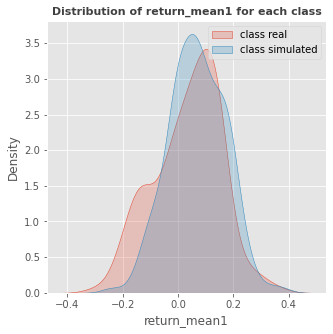

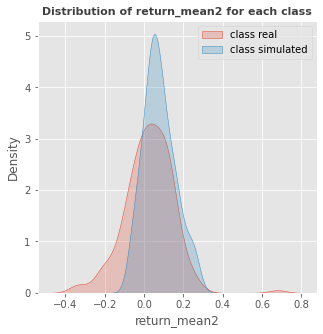

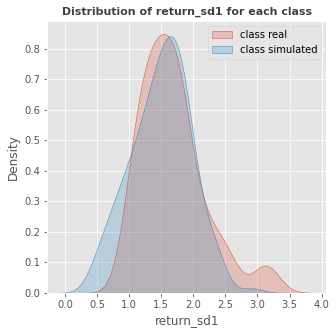

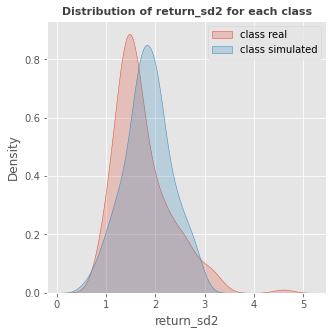

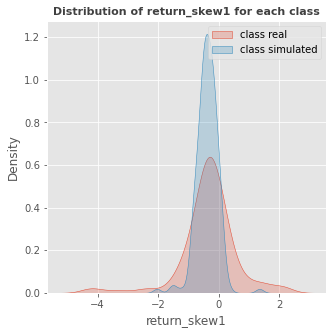

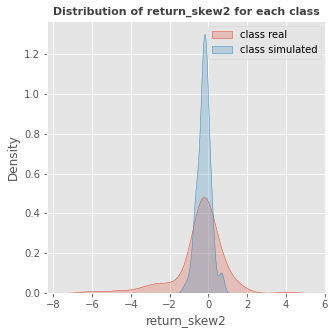

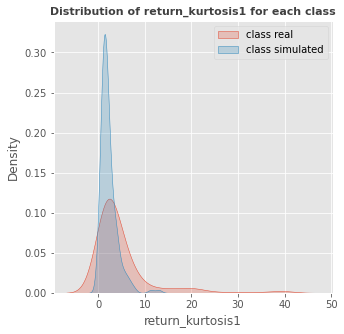

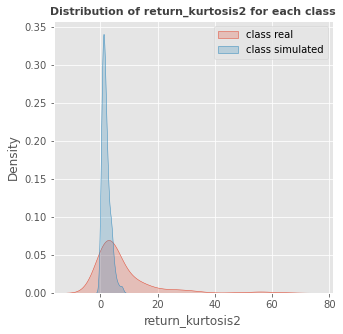

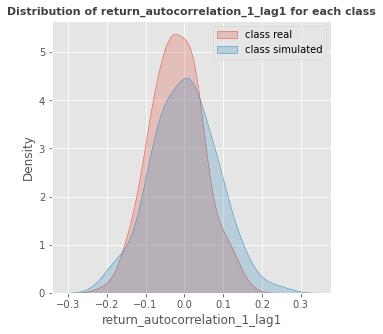

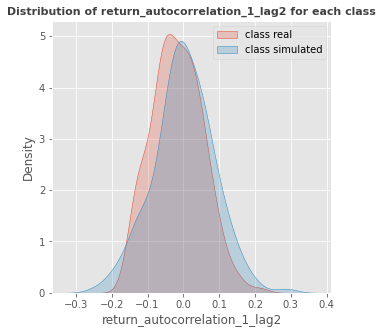

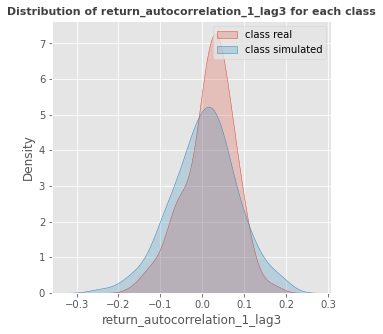

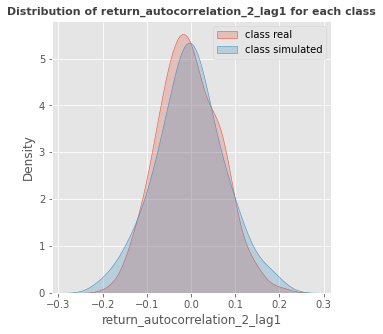

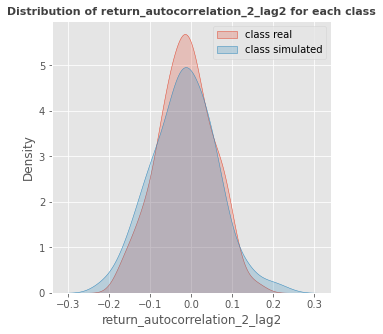

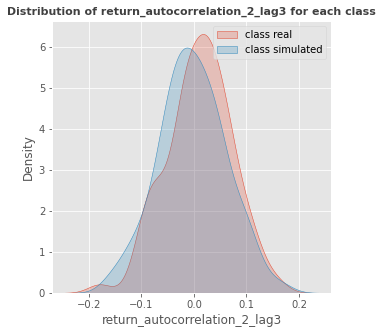

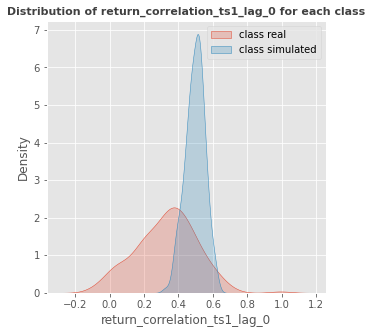

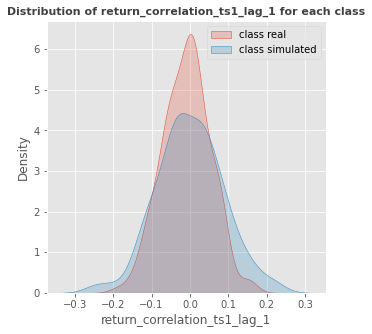

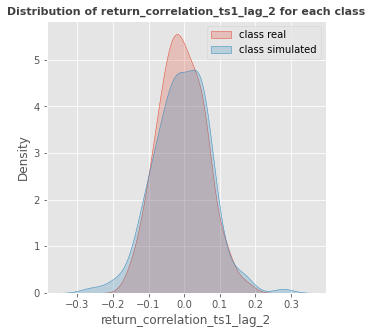

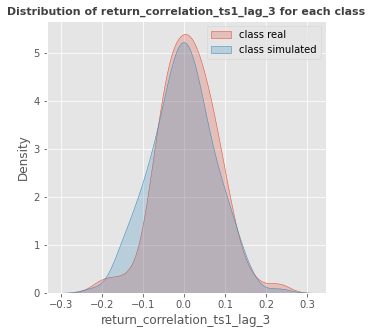

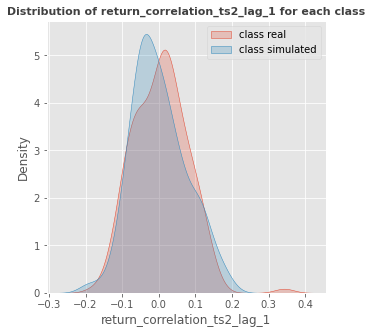

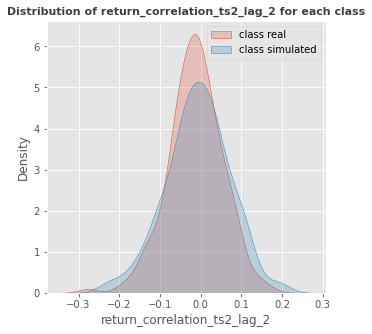

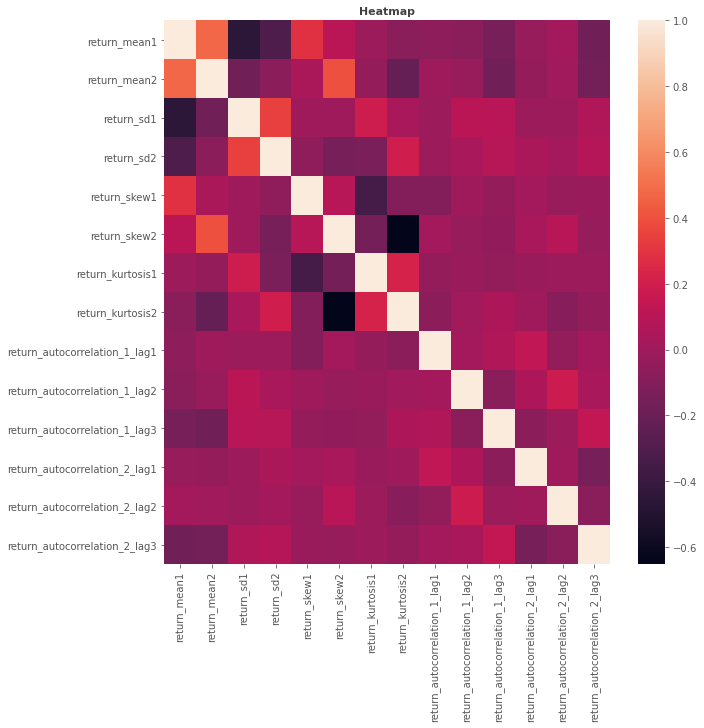

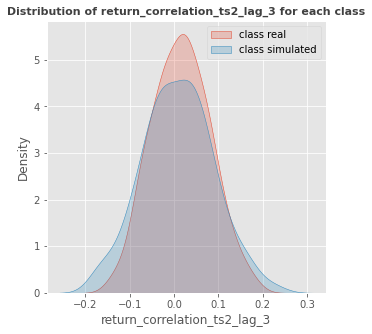

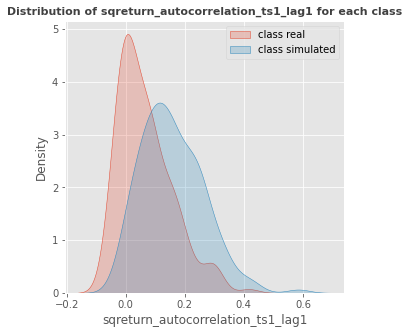

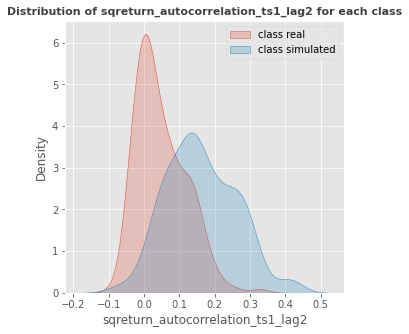

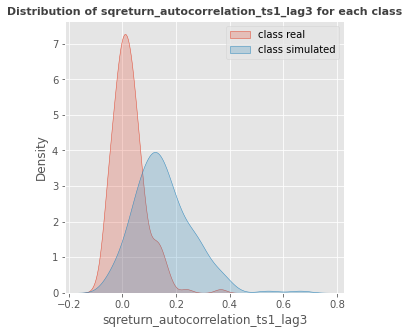

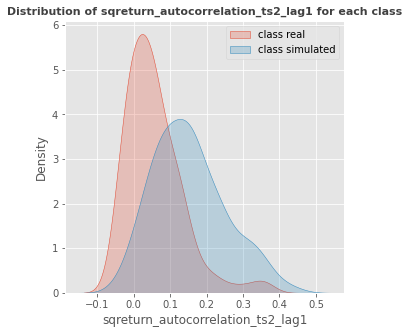

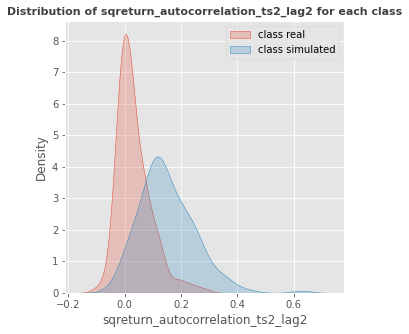

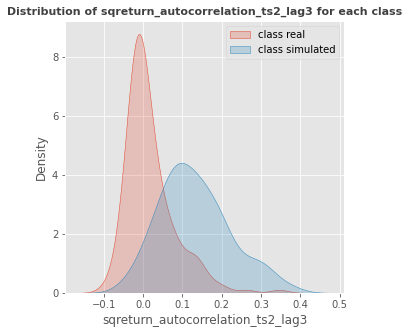

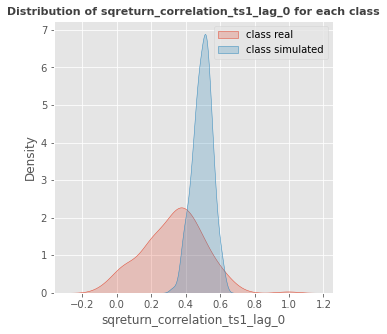

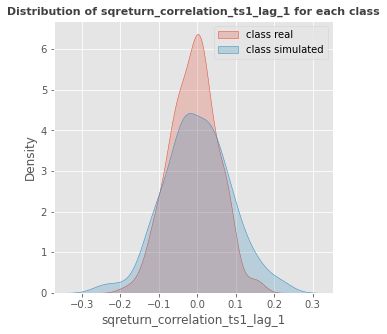

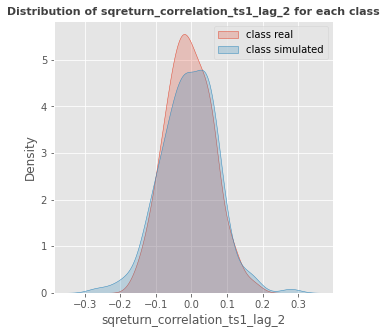

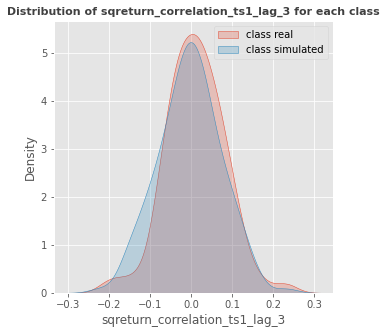

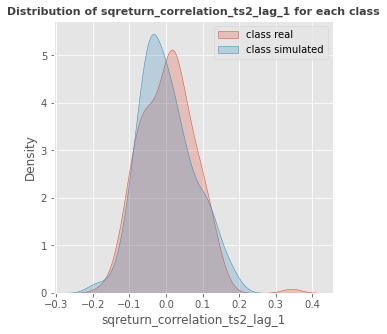

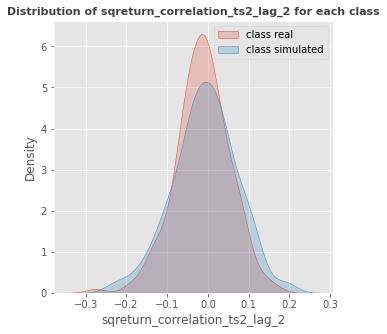

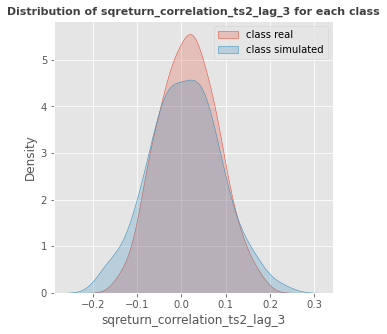

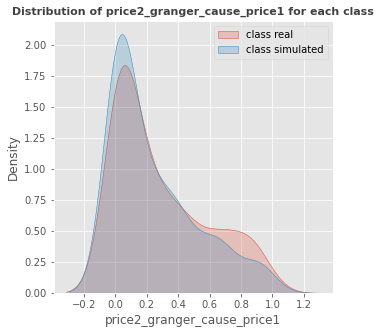

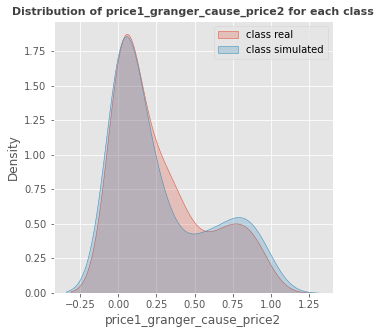

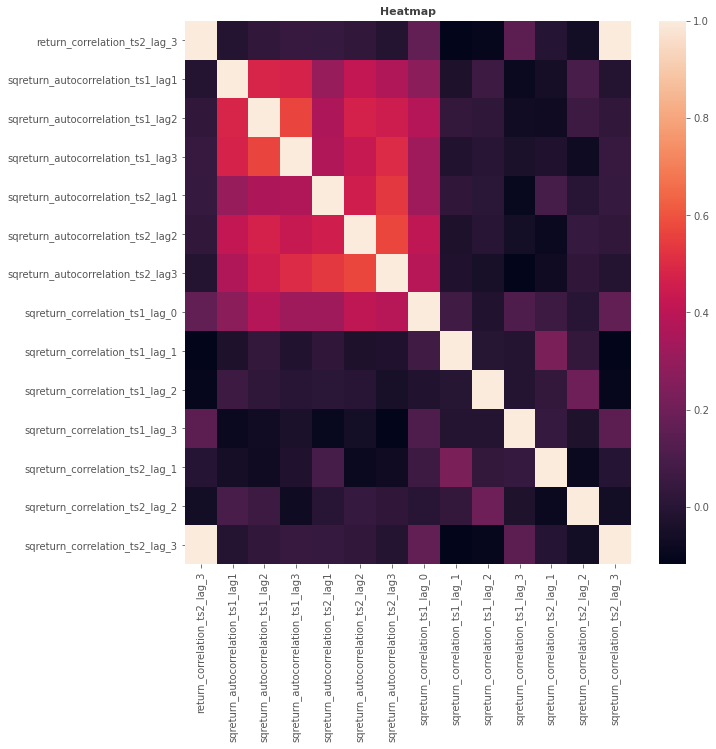

In [17]:
plt.rc('figure', max_open_warning = 0)
EDA.extensive_eda(X_train.iloc[:, 0:20], y_train, save_path="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/EDA_stvol")
EDA.extensive_eda(X_train.iloc[:, 20:36], y_train, save_path="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/EDA_stvol")

In [18]:
print(results)
print(accuracy_average)
print(accuracy_std)

[0.8926174496644296, 0.9395973154362416, 0.9463087248322147, 0.912751677852349, 0.9328859060402684]
0.9248322147651008
0.01963589105815808
